# Detección de Fraudes en Transacciones Bancarias

## 1. Introducción

Para la realización de este proyecto se explorarán y desarrollarán múltiples modelos de detección de fraudes bancarios en pagos realizados con tarjeta de crédito. Se busca crear varios modelos y evaluar su rendimiento en base a métricas adecuadas y seleccionar el que mejor funcione de cara a una futura implementación en un entorno real.


Como parte del proceso, se va a realizar un **análisis exploratorio de datos (EDA)** para estudiar los patrones y características presentes en nuestro dataset. Este paso es fundamental para que podamos adquirir un conocimiento profundo de los datos e identificar posibles problemas de cara al desarrollo de los modelos.


Uno de los principales desafios será el hecho de que el dataset utilizado está **muy desbalanceado**, ya que se tienen muchos más datos de transacciones legítimas que de fraudulentas. Como es lógico este desbalanceo dificultará notablemente la búsqueda de modelos efectivos pero tal y como se explicará más adelante se considerarán diversas técnicas y modelos específicos para hacer frente a ello.

## 2. Objetivos

Cuando se desarrolla un modelo de detección de fraudes como este, el objetivo es detectar el mayor número de fraudes (maximizando el recall) para proteger a nuestros clientes y evitar que se pierda el dinero involucrado, y hacerlo además minimizando los falsos positivos (transacciones legítimas catalogadas como fraude). Esto último es vital para garantizar una buena experiencia de nuestros clientes ya que una cancelación de pago o bloqueo de tarjeta de crédito en casos en los que no corresponde podría provocar que se sientan descontentos y se acaben pasando a la competencia. En resumen, debemos ser capaces de encontrar un **balance entre beneficio para la empresa y buena experiencia del cliente**.

De esta forma, debemos considerar las métricas adecuadas para que nuestros modelos sean capaces de cumplir nuestros objetivos. En este caso, se tendrán en cuenta el **F1-score** y el **PR-AUC** (Área Bajo la Curva de Precisión-Recall).

* **F1-Score**: Se trata de la **media armónica** entre precisión y recall. Como buscamos un balance entre ambas, esta se trata de una métrica ideal para este caso.

$$
\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

* **PR-AUC**: Mide el área bajo la curva que representa la relación entre precisión y recall a diferentes umbrales de decisión. A diferencia de ROC-AUC se enfoca en la clase positiva (fraudes en este caso), lo que la hace más adecuada para evaluar los resultados en casos con datasets desbalanceados. Permite identificar el umbral óptimo para maximizar recall sin sacrificar demasiada precisión, asegurando así que se reduzcan los falsos positivos mientras detectamos el mayor número posible de fraudes. En cuanto a los ejes:

    * **Eje Y**: Precisión de las predicciones para un valor de umbral concreto.

    * **Eje X**: Recall de las predicciones para el mismo umbral.


## 3. Análisis preliminar

En este apartado vamos a realizar un análisis básico del dataset con el fin de familiarizarnos con su estructura y contenido. En esta primera aproximación se busca poder examinar aspectos fundamentales como el número de filas y columnas (así como el significado de cada una), nombres de las variables, tipos de datos o desbalanceo de la variable objetivo entre otros. El propósito de este apartado es entender cómo son nuestros datos y poder identificar formas de transformarlos para explotar todo su valor. De esta forma, lo enfocamos como un primer paso para planificar las siguientes etapas del proyecto.

En primer lugar empezamos por hacer los imports de las librerías que nos serán necesarias para esta parte.

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

A continuación cargamos el dataset desde Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ruta al archivo en Google Drive.
file_path = '/content/drive/Shareddrives/MUCSI-ML/Proyecto/fraud.csv'

# Leer el archivo CSV en forma de un DataFrame de pandas.
df = pd.read_csv(file_path)

Veamos cómo son las primeras filas de nuestro DataFrame.

In [ ]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


Para empezar a familiarizarnos con nuestro dataset, veamos sus dimensiones.

In [ ]:
print(f"Nuestro dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

Nuestro dataset tiene 1852394 filas y 23 columnas.


En primer lugar, destaca el hecho de que contamos con casi dos millones de filas. Esto claramente va a condicionar cómo debemos proceder a la hora de diseñar los modelos ya que los tiempos de entrenamiento serán bastante elevados. Para hacer frente a este primer problema será necesaria una estrategia clara que se detallará más adelante.

En cuanto a las columnas, vemos que tenemos un total de 23. Centrémonos en ver cuáles son y qué información nos da cada una.

In [ ]:
print("Se muestran las columnas columnas de nuestro dataset:")
print(df.columns)

Se muestran las columnas columnas de nuestro dataset:
Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


A continuación se da una breve explicación del contenido de cada columna:

* **Unnamed: 0**: Simplemente se trata de un ID secuencial, exactamente igual que el que proporciona pandas al crear el DataFrame, no aporta ninguna información.

* **trans_date_trans_time**: Fecha y hora en la que se realiza la transacción.

* **cc_num**: Número de la tarjeta de crédito que realiza el pago.

* **merchant**: Comercio/Comerciante al que se realiza el pago. Por alguna razón, todos los merchant empiezan por "fraud_", esto lo tenemos en cuenta y lo solucionamos más abajo.

* **category**: Hace referencia a la categoría del gasto realizado con la tarjeta, se tienen valores como "misc_net" (Miscellaneous Netwrok, es decir, pagos de caracter general realizados en linea), o "grocery_pos" (Grocery Point of Sale, es decir, compras en supermercados realizadas en el propio punto de venta).

* **amt**: Cuantía de la transacción. Al tratarse de transacciones realizadas en EE.UU. la divisa es el dólar.

* **first y last**: Nombre y apellido de la persona que realiza la transacción.

* **gender**: Sexo de la persona que hace el pago.

* **state, city, zip y street**: Estado, ciudad, código postal y calle asociadas al domicilio del titular de la tarjeta.

* **lat, long, merch_lat y merch_long**: Latitud y longitud asociadas al cliente y al comercio.

* **city_pop**: Población de la ciudad del titular.

* **job y dob**: Empleo y fecha de nacimiento del titular.

* **trans_num**: Identificación única asocidad a cada transacción, una especie de clave primaria.

* **unix_time**: Timestamp asociado a la transacción en formato unix, es decir, se cuentan los segundos transcurridos desde el 1 de enero de 1970 a las 00:00:00 UTC.

* **is_fraud**: Variable objetivo que indica si una transacción es fraudulenta (1) o no (0).

Vemos que a pesar de tener un número bastante elevado de columnas, en realidad muchas de ellas dan información redundante o poco útil. Más adelante se eliminarán algunas columnas y se crearán otras más para poder sacar el máximo partido a los datos.

Ahora que conocemos el contenido de cada columna, veamos con qué tipos de datos tendremos que trabajar.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

Tal y como se aprecia, tenemos 5 columnas de tipo float, otras 6 de tipo entero y 12 de tipo categórico.

Otro aspecto en el que conviene fijarse es en el número de valores faltantes que se tienen. En nuestro caso en particular vemos que no hay ninguno.

In [ ]:
num_col_faltantes = df.isnull().any().sum()

print(f"En nuestro dataset hay {num_col_faltantes} columnas con datos faltantes.")

En nuestro dataset hay 0 columnas con datos faltantes.


A continuación separemos columnas numéricas y categóricas para estudiarlas por separado.

In [ ]:
columnas_numericas = df.select_dtypes(include=["float64", "int64"]).columns.to_list()

columnas_categoricas = df.select_dtypes(include=["object"]).columns.to_list()

print(f"Columnas numéricas:\n {columnas_numericas}\n")
print(f"Columnas categóricas:\n {columnas_categoricas}")

Columnas numéricas:
 ['Unnamed: 0', 'cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']

Columnas categóricas:
 ['trans_date_trans_time', 'merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num']


Al evaluar las columnas numéricas no encontramos demasiada información relevante, simplemente destacamos que

  * a) Los valores de las transacciones van desde 1 dólar hasta cerca de los 30.000, sin embargo, su valor medio es de unos 70 dólares, lo cual indica que su distribución es muy asimétrica puesto que la mayoría de pagos son de cantidades bajas.

  * b) El valor medio de la columna "if_fraud" es muy bajo, lo cual es un claro indicio de que se tiene un dataset desbalanceado, puesto que se tienen muchas más instancias de transacciones legítimas que fraudulentas.

In [ ]:
df[columnas_numericas].describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1852394.0,5.371934e+05,3.669110e+05,0.000000e+00,2.315490e+05,4.630980e+05,8.335758e+05,1.296674e+06
cc_num,1852394.0,4.173860e+17,1.309115e+18,6.041621e+10,1.800429e+14,3.521417e+15,4.642255e+15,4.992346e+18
amt,1852394.0,7.006357e+01,1.592540e+02,1.000000e+00,9.640000e+00,4.745000e+01,8.310000e+01,2.894890e+04
zip,1852394.0,4.881326e+04,2.688185e+04,1.257000e+03,2.623700e+04,4.817400e+04,7.204200e+04,9.992100e+04
lat,1852394.0,3.853931e+01,5.071470e+00,2.002710e+01,3.466890e+01,3.935430e+01,4.194040e+01,6.669330e+01
long,1852394.0,-9.022783e+01,1.374789e+01,-1.656723e+02,-9.679800e+01,-8.747690e+01,-8.015800e+01,-6.795030e+01
city_pop,1852394.0,8.864367e+04,3.014876e+05,2.300000e+01,7.410000e+02,2.443000e+03,2.032800e+04,2.906700e+06
unix_time,1852394.0,1.358674e+09,1.819508e+07,1.325376e+09,1.343017e+09,1.357089e+09,1.374581e+09,1.388534e+09
merch_lat,1852394.0,3.853898e+01,5.105604e+00,1.902742e+01,3.474012e+01,3.936890e+01,4.195626e+01,6.751027e+01
merch_long,1852394.0,-9.022794e+01,1.375969e+01,-1.666716e+02,-9.689944e+01,-8.744069e+01,-8.024511e+01,-6.695090e+01


In [ ]:
df["state"].unique()

array(['NC', 'WA', 'ID', 'MT', 'VA', 'PA', 'KS', 'TN', 'IA', 'WV', 'FL',
       'CA', 'NM', 'NJ', 'OK', 'IN', 'MA', 'TX', 'WI', 'MI', 'WY', 'HI',
       'NE', 'OR', 'LA', 'DC', 'KY', 'NY', 'MS', 'UT', 'AL', 'AR', 'MD',
       'GA', 'ME', 'AZ', 'MN', 'OH', 'CO', 'VT', 'MO', 'SC', 'NV', 'IL',
       'NH', 'SD', 'AK', 'ND', 'CT', 'RI', 'DE'], dtype=object)

Al hacer un primer análisis de las variables categóricas destacamos que

* a) Hay un número muy elevado de merchants y a juzgar por la frecuencia de aparición del más repetido, no parece haber ninguno que destaque notablemente sobre el resto.

* b) Hay un total de 14 categorías de tipos de pago, lo cual no es excesivamente alto. La categoría más presente en el dataset es "gas_transport" que está relacionado con pagos de gasolineras, servicios de transporte u otro tipo de servicios relacionados con vehículos.

* c) La mayoría de transacciones las realizan mujeres.

* d) También hay un número muy elevado de ciudades y no parece que ninguna sobresalga por encima de otra.

* e) Tenemos datos referentes a 51 estados (50 + Washington D.C. que a menudo no se cuenta como estado normal sino como distrito federal).

* f) Los clientes tienen cerca de 500 trabajos diferentes.

In [ ]:
df[columnas_categoricas].describe().T

,count,unique,top,freq
trans_date_trans_time,1852394,1819551,2019-04-22 16:02:01,4
merchant,1852394,693,fraud_Kilback LLC,6262
category,1852394,14,gas_transport,188029
first,1852394,355,Christopher,38112
last,1852394,486,Smith,40940
gender,1852394,2,F,1014749
street,1852394,999,444 Robert Mews,4392
city,1852394,906,Birmingham,8040
state,1852394,51,TX,135269
job,1852394,497,Film/video editor,13898


## 4. Creación de variables sintéticas

Tras realizar un primer análisis preliminar del dataset, a pesar de contar con información valiosa, creemos que las variables disponibles no son suficientes para capturar la complejidad del problema, razón por la cual hemos decidido crear una serie de variables sintéticas para facilitar el EDA posterior y mejorar el rendimiento de los modelos que vamos a diseñar. La creación de estas variables es clave para enriquecer nuestro dataset y sacar el máximo partido a los datos.

En nuestro caso, para crear estas nuevas variables vamos a combinar, transformar o extraer información de las variables que ya existen dependiendo del caso, permitiéndonos obtener una mayor interpretabilidad de los datos.

### 4.1. Año, mes, día y hora

En primer lugar partimos de la columna "trans_date_trans_time". Como sabemos, esta contiene la fecha y hora de la transacción, información que puede resultar muy relevante de cara a la búsqueda de patrones temporales de los fraudes. Sin embargo, para poder sacar partido a esta información necesitamos poder acceder a cantidades como el día o la hora. Para ello, primero nos fijamos en que ahora mismo las fechas son de tipo string.

In [ ]:
type_date = type(df['trans_date_trans_time'][0]).__name__
print(f"Los valores de la columna 'trans_date_trans_time' son de tipo {type_date}.")

Los valores de la columna 'trans_date_trans_time' son de tipo str.


De esta forma, lo primero que tenemos que hacer es modificar el tipo de dato de esta columna a fechas y posteriormente ya podremos extraer las cantidades que nos interesan. Para ello es importante dar el formato en el que se encuentran las fechas. Además, es importante mencionar que los valores de las nuevas columnas que hemos creado son de tipo entero

In [ ]:
# Cambiamos de formato usando el formato adecuado.
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format = '%Y-%m-%d %H:%M:%S')

type_date_new = type(df['trans_date_trans_time'][0]).__name__
print(f"Los valores de la columna 'trans_date_trans_time' son de tipo {type_date_new}.")

# Ahora podemos extraer hora, día mes y año de la transacción de forma sencilla.
df['hora'] = df['trans_date_trans_time'].dt.hour
df['dia'] = df['trans_date_trans_time'].dt.dayofweek
df['mes'] = df['trans_date_trans_time'].dt.month
df['año'] = df['trans_date_trans_time'].dt.year

Los valores de la columna 'trans_date_trans_time' son de tipo Timestamp.


### 4.2. Conversión de mes y día a variables categóricas

En relación a lo anterior, vamos a crear columnas para guardar los nombres de los días de la semana y de los meses para facilitar la interpretación de las visualizaciones de cara al **EDA** del próximo apartado.

In [ ]:
# Diccionario para mapear los valores numéricos a los nombres de los días.
dias_semana = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miércoles',
    3: 'Jueves',
    4: 'Viernes',
    5: 'Sábado',
    6: 'Domingo'
}

df['nombre_dia'] = df['dia'].map(dias_semana)

In [ ]:
# Diccionario para mapear los valores numéricos a los nombres de los meses.
meses_del_año = {
    1: 'Enero',
    2: 'Febrero',
    3: 'Marzo',
    4: 'Abril',
    5: 'Mayo',
    6: 'Junio',
    7: 'Julio',
    8: 'Agosto',
    9: 'Septiembre',
    10: 'Octubre',
    11: 'Noviembre',
    12: 'Diciembre'
}

df['nombre_mes'] = df['mes'].map(meses_del_año)

### 4.3. Edad

La fecha de nacimiento del titular de la tarjeta también puede llegar a ser útil para tratar de encontrar patrones en los rangos de edades en los que se producen más fraudes. Sin embargo, una vez más hay que convertir esta columna a fechas haciendo uso del correspondiente formato. Tras ello, restando la fecha actual a la del momento en el que se realiza la transacción.

In [ ]:
# Cambiar formato de fecha para mostrar año, mes y día.
df['fecha'] = df['trans_date_trans_time'].dt.strftime('%Y-%m-%d')

In [ ]:
# Cambiar de muevo a tipo fecha.
df['fecha'] = pd.to_datetime(df['fecha'])

# Pasar también "dob" a tipo fecha.
df['dob'] = pd.to_datetime(df['dob'])

# Obtener edad haciendo la resta de las fechas.
df['edad'] = df['fecha'].dt.year - df['dob'].dt.year

### 4.4. Partes del día

Más alla de que ya contamos con la hora en la que se realizan las transacciones, vamos a crear una nueva columna que haga referencia al momento del día, ya que también podría favorecer la búsqueda de patrones. En este caso dividimos según

* **Mañana**: Desde las 6h hasta las 13h.
* **Tarde**: Desde las 13h hasta las 21h.
* **Noche**: Desde las 21h hasta las 6h del día siguiente.

Columna que divide las horas en 3 categorías: mañana, tarde y noche.

In [ ]:
# Simplemente creamos una función divide por horas tal y como hemos comentado.
def clasificar_hora(hora):
    if 0 <= hora < 6:
        return 'noche'
    elif 6 <= hora < 13:
        return 'mañana'
    elif 13 <= hora < 21:
        return 'tarde'
    else:
        return 'noche'

# Y se lo aplicamos a la columna hora que hemos creado antes.
df['periodo_dia'] = df['hora'].apply(clasificar_hora)

### 4.5. Fin de semana

De forma similar, creamos una columna que indica si la transacción se ha producido durante el fin de semana o entre semana.

In [ ]:
def clasificar_dia(dia):
    if 0 <= dia <= 4:  # Lunes (0) a Viernes (4)
        return 0 # Entre semana
    else:  # Sábado (5) y Domingo (6)
        return 1  # Fin de semana

# Creamos la columna.
df['tipo_dia'] = df['dia'].apply(clasificar_dia)

### 4.6. Compañía a la que pertenece la tarjeta

El número de la tarjeta de crédito que realiza la transacción podría parecer poco relevante, sin embargo, es posible mapear cada uno de ellos con la compañía que le corresponde (VISA o MASTERCARD por ejemplo) a partir de los primeros dígitos de los mismos. Esto nos permite llevar a cabo un análisis para ver qué tarjetas de crédito son más propensas al fraude. Para realizar el mapeo mencionado, se parte de un dataset que hemos encontrado en el que se tiene información al respecto.

In [ ]:
# Ruta al archivo mencionado en Google Drive.
file_path = '/content/drive/Shareddrives/MUCSI-ML/Proyecto/tarjetas.csv'

# Leer el archivo CSV en forma de un DataFrame de pandas.
cred_card_id = pd.read_csv(file_path)

In [ ]:
# Pasamos los números de tarjetas a tipo string para quedarnos con los primeros dígitos.
df['cc_num'] = df['cc_num'].astype(str)
df['first_digits'] = df['cc_num'].str[:6]

# Creamos la nueva columna en la que haremos la clasificación.
df['card_type'] = None

# Del dataset de las tarjetas realizamos el mapeo entre los primeros dígitos y el tipo de tarjeta.
bin_to_brand = dict(zip(cred_card_id['BIN'].astype(str), cred_card_id['Brand']))

# Recorremos todas las filas y realizamos la clasificación.
for idx, first_digits in df['first_digits'].items():
    if first_digits in bin_to_brand:
       df.at[idx, 'card_type'] = bin_to_brand[first_digits]

# Eliminamos la columna creada arriba para separar los primeros dígitos.
df.drop('first_digits', axis = 1, inplace = True)

# En caso de que haya tarjetas que no hemos podido identificar, les asignamos la etiqueta "Other".
df['card_type'] = df['card_type'].fillna('Other').astype(str)

Para los números que caen dentro de la categoría "Other" hacemos la clasificación usando menos dígitos para buscar coincidencias en nuestro CSV.

In [ ]:
# Tomamos menos dígitos para hacer la clasificación. Los números que no hemos podido identificar
# en primer lugar son muy parecidos a otros que ya hemos identificado. Tras realizar búsquedas en
# diversas BBDD hemos visto que este parecido indica que pertenecen a la misma compañía.
for i in range(5, 0, -1):
  df['first_digits'] = df['cc_num'].str[:i]
  # Crear un diccionario de mapeo a partir de los valores conocidos.
  mapping = df[df["card_type"] != "Other"].groupby("first_digits")["card_type"].first().to_dict()

  # Rellenar los valores "Other" utilizando el mapeo
  df["card_type"] = df.apply(
      lambda row: mapping[row["first_digits"]] if row["card_type"] == "Other" and row["first_digits"] in mapping else row["card_type"],
      axis=1
  )

### 4.7. Distancia entre customer y merchant

La latitud y la longitud tanto de la persona que efectúa el pago como de la que lo recibe pueden resultar de interés. Valores inusuales de dichas cantidades pueden ser claros indicadores de fraude. Sin embargo, utilizar directamente la distancia en kilómetros puede ser más fácil de interpretar para tratar de identificar patrones de fraudes en función de la distancia.

Con este fin, se ha hecho uso de la Fórmula de Haversine, la cual permite hallar la distancia entre dos puntos del globo conocidas sus latitudes y longitudes. De esta forma, la distancia $d$ se calcula según

$$
\text{d} = 2 \text{R} \times arctan2(\sqrt{a}, \sqrt{1-a})
$$

donde $R$ es el radio de la tierra en km, $arctan2$ es la función arcotangente de dos parámetros y

$$
a = sin²(\frac{\Delta lat}{2}) + cos(lat_1) \times cos(lat_2) \times sin²(\frac{\Delta long}{2})
$$

In [ ]:
# Importamos lo necesario de la librería math.
from math import radians, sin, cos, sqrt, atan2

# Creamos una función para la implementación de la Fórmula de Haversine.
def dist_haversine(lat, lon, merch_lat, merch_lon):
  R = 6370.0 # Radio de la tierra en km para multiplicar después por diferencia en radianes.

  # Convertir long y lat de grados a radianes.
  lat, lon, merch_lat, merch_lon = map(radians, [lat, lon, merch_lat, merch_lon])
  dif_lat = merch_lat - lat
  dif_lon = merch_lon - lon

  # Aplicar la fórmula.
  aux = sin(dif_lat / 2)**2 + cos(lat) * cos(merch_lat) * sin(dif_lon / 2)**2
  arc = 2 * atan2(sqrt(aux), sqrt(1 - aux))

  # Distancia = angulo*radio
  dist = arc * R
  return dist

# Aplicamos la función anterior a nuestros datos.
df['dist_to_merch'] = df.apply(lambda row: dist_haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis = 1)

### 4.8. Historial de fraudes de un cliente

Dado que contamos con la fecha en la que se realizan las transacciones, nos es posible crear un historial de fraudes previos que se hayan cometido con una tarjeta de crédito concreta. Esto puede ser muy útil ya que permite tener contexto de transacciones realizadas con anterioridad.

Para crear esta columna debemos ordenar y agrupar por número de tarjeta y fecha, de esta forma, si hay fraudes previos a esta nueva columna le corresponderá el valor 1 y si no el 0.

In [ ]:
# Ordenar el DataFrame por número de tarjeta y fecha.
df = df.sort_values(by = ['cc_num', 'trans_date_trans_time'])

# Crear la columna. Para ello, agrupamos por número de tarjeta y nos quedamos con el valor más alto hasta esa fecha,
# es decir, que si en un momento dado se da un fraude, de ahí en adelante dicha tarjeta siempre tendrá valor 1 en esta nueva
# columna.
df['previous_fraud_client'] = df.groupby('cc_num')['is_fraud'].cummax().shift().fillna(0)

### 4.9. Historial de fraudes de un comercio

Siguiendo la misma lógica que para el caso anterior, vamos a obtener ahora un historial de fraudes previos para los comercios que reciben los pagos. La forma de crear esta columna es idéntica a la anterior.

In [ ]:
# Ordenar el DataFrame por merchant y fecha.
df = df.sort_values(by=['merchant', 'trans_date_trans_time'])

# Crear columna igual que antes.
df["previous_fraud_merchant"] = df.groupby('merchant')['is_fraud'].cummax().shift().fillna(0)

### 4.10. Modificación de los merchant

Anteriormente ya se ha comentado que por alguna razón todos los merchant del dataset tienen el prefijo 'fraud_'. A continuación, vamos a eliminarlo.

In [ ]:
# Mostramos un comercio antes de hacer el cambio.
print('Comerciante antes del cambio:')
print(df['merchant'][1] + '\n')

# Sustituimos 'is_fraud' por una cadena vacía.
df['merchant'] = df['merchant'].apply(lambda x : x.replace('fraud_',''))

# Mostramos un merchant para comprobar que se ha eliminado.
print('Comerciante tras el cambio:')
print(df['merchant'][1])

Comerciante antes del cambio:
fraud_Heller, Gutmann and Zieme

Comerciante tras el cambio:
Heller, Gutmann and Zieme


### 4.11 Modificación de las category

Traducimos la columna 'category' ya que sus valores se encuentran en inglés y con palabras abreviadas con el fin de que la visualización del EDA sea más sencilla.

In [ ]:
category_translation = {
    "gas_transport": "Transporte y gasolina",
    "grocery_pos": "Compras en supermercados presenciales",
    "home": "Hogar",
    "shopping_pos": "Compras presenciales",
    "kids_pets": "Niños y mascotas",
    "shopping_net": "Compras online",
    "entertainment": "Entretenimiento",
    "food_dining": "Alimentación y restaurantes",
    "personal_care": "Cuidado personal",
    "health_fitness": "Salud y ejercicio físico",
    "misc_pos": "Misceláneos presenciales",
    "misc_net": "Misceláneos online",
    "grocery_net": "Compras en supermercados online",
    "travel": "Viajes"
}
df['category'] = df['category'].replace(category_translation)


In [ ]:
df['category'].value_counts()

,count
category,
Transporte y gasolina,188029
Compras en supermercados presenciales,176191
Hogar,175460
Compras presenciales,166463
Niños y mascotas,161727
Compras online,139322
Entretenimiento,134118
Alimentación y restaurantes,130729
Cuidado personal,130085


### 4.12 Eliminación de columnas innecesarias

Dado que se han creado varias columnas, optamos por eliminar algunas de las que no vamos a utilizar en el **EDA** que vamos a realizar. No obstante, es importante recalcar que antes de pasar a entrenar los modelos se hará otro análisis de qué columnas merece la pena mantener y cuáles no. Comencemos por ver todas las columnas con las que contamos actualmente.

In [ ]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'hora', 'dia', 'mes', 'año',
       'nombre_dia', 'nombre_mes', 'fecha', 'edad', 'periodo_dia', 'tipo_dia',
       'card_type', 'first_digits', 'dist_to_merch', 'previous_fraud_client',
       'previous_fraud_merchant'],
      dtype='object')

Eliminamos las columnas que no aportan valor como el identificador, el nombre, el apellido, la dirección y el número de transacción entre otros.

In [ ]:
# Creamos una lista de columnas a eliminar.
columns_drop = ['Unnamed: 0', 'first', 'last', 'street', 'zip',
                'dob', 'trans_num', 'unix_time', 'trans_date_trans_time',
                'first_digits']

df.drop(columns_drop, axis = 1, inplace = True)

print(f'Se han eliminado {len(columns_drop)} columnas.')

Se han eliminado 10 columnas.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 1251 to 1851734
Data columns (total 28 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   cc_num                   object        
 1   merchant                 object        
 2   category                 object        
 3   amt                      float64       
 4   gender                   object        
 5   city                     object        
 6   state                    object        
 7   lat                      float64       
 8   long                     float64       
 9   city_pop                 int64         
 10  job                      object        
 11  merch_lat                float64       
 12  merch_long               float64       
 13  is_fraud                 int64         
 14  hora                     int32         
 15  dia                      int32         
 16  mes                      int32         
 17  año                      int3

## 5. EDA

En este apartado se va a realizar un **EDA** para tratar de detectar patrones y relaciones entre variables. El objetivo es entender aún mejor nuestros datos y ver qué variables pueden resultar de interés de cara al entrenamiento de los modelos. En primer lugar, se importan las bibliotecas necesarias.

In [ ]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

### 5.1. Distribución de la variable objetivo

Tras el análisis preliminar hemos visto que existe un desbalance entre los casos fraudulentos y legítimos. A continuación, vamos a visualizar cómo de grande es la diferencia.

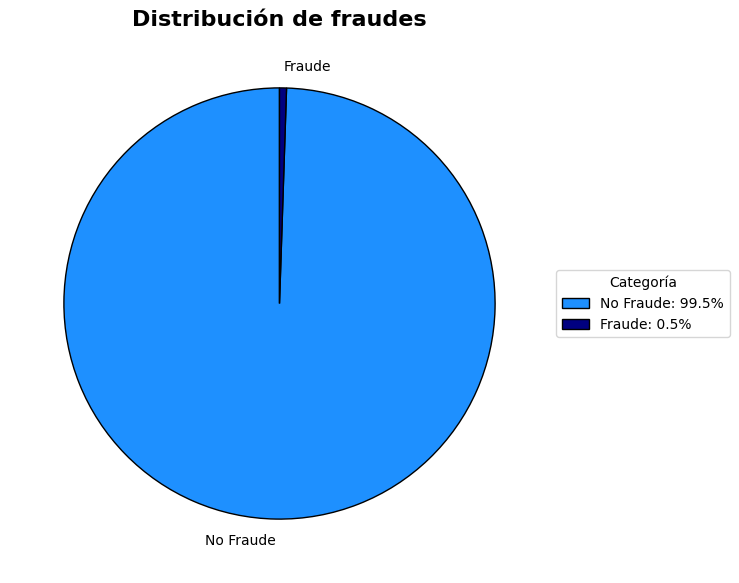

In [ ]:
# Calcular los porcentajes de fraude vs no fraude.
counts = df['is_fraud'].value_counts()
percentages = counts / counts.sum() * 100

# Colores personalizados.
colors = ["#1E90FF", "#000080"]

# Crear pie chart.
plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(percentages, labels=['No Fraude', 'Fraude'],
                                   startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, autopct='%1.1f%%')

# Eliminar porcentajes de dentro de la figura.
for autotext in autotexts:
    autotext.set_text('')

# Título.
plt.title("Distribución de fraudes", fontsize=16, fontweight='bold')

# Colocar porcentajes en la leyenda.
plt.legend(wedges, [f'{label}: {perc:.1f}%' for label, perc in zip(['No Fraude', 'Fraude'], percentages)],
           title="Categoría", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Mostrar pie chart.
plt.show()

Como adelantabamos, solo un 0.5% de los datos son transacciones fraudulentas, por lo que más adelante se deberán aplicar diversas técnicas para hacer frente al desbalanceo y que nuestros modelos sean capaces de detectar los fraudes correctamente.

### 5.2. Importes de transacciones fraudulentas vs no fraudulentas

Queremos visualizar si el importe de las transacciones guarda relación con el hecho de que se produzca un fraude. Para ello, mostramos la cuantía de las transacciones tanto fraudulentas como legítimas. Se ha usado un histograma para cada caso, donde en el eje Y se muestra el porcentaje dentro de cada bin del total de fraudes/ no fraudes según el caso.

Es importante recalcar que se ha limitado el valor de las transacciones a un máximo de 1400 dólares ya que para el caso de las transacciones legítimas había unos cuantos outliers correspondientes a pagos de hasta cerca de 30.000 dólares que dificultaban la interpretabilidad de la figura.

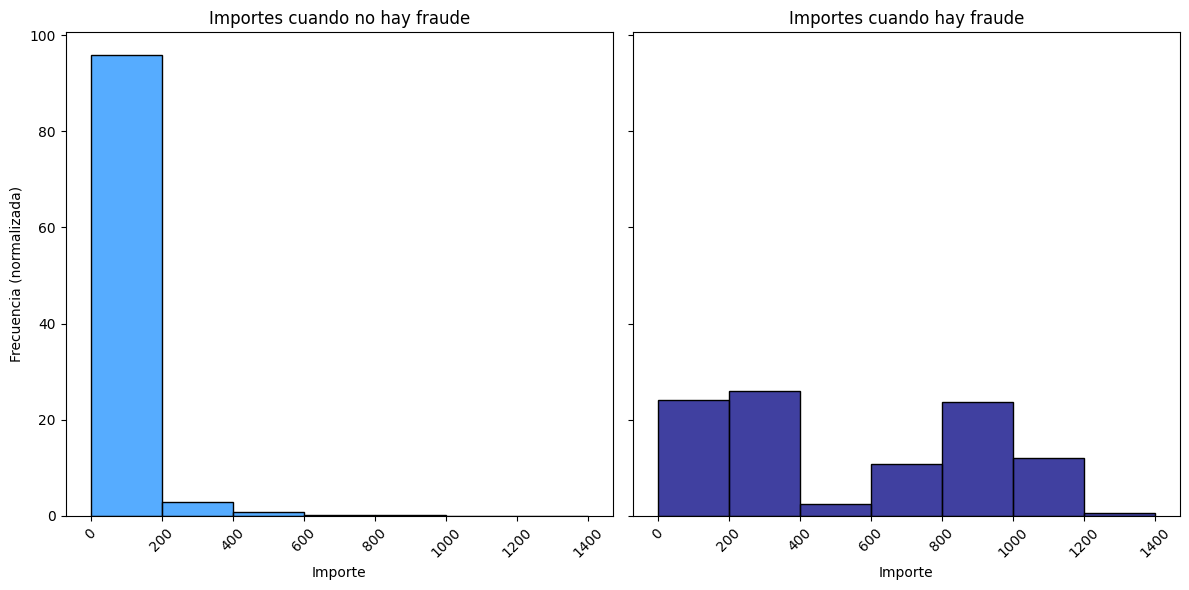

In [ ]:
# Filtramos los datos para no incluir importes demasiado elevados porque estos son muy escasos y
# pueden dificultar la visualización de los resultados
non_fraud_data = df[(df['is_fraud'] == 0) & (df['amt'] < 1401)]
fraud_data = df[(df['is_fraud'] == 1) & (df['amt'] < 1401)]

# Calcular los bins usando el rango de valores para 'amt'.
bins = np.arange(0, 1401, 200)

# Crear subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

# Histograma para is_fraud == 0.
sns.histplot(non_fraud_data['amt'], bins=bins, kde=False, color='#1E90FF', ax=axes[0], stat="percent")
axes[0].set_title('Importes cuando no hay fraude')
axes[0].set_xlabel('Importe')
axes[0].set_ylabel('Frecuencia (normalizada)')
axes[0].set_xticks(bins)

# Histograma para is_fraud == 1.
sns.histplot(fraud_data['amt'], bins=bins, kde=False, color='#000080', ax=axes[1], stat="percent")
axes[1].set_title('Importes cuando hay fraude')
axes[1].set_xlabel('Importe')
axes[1].set_ylabel('Porcentaje')
axes[1].set_xticks(bins)

# Ajustar las etiquetas del eje x para que no se superpongan.
for ax in axes:
    ax.set_xticklabels([f'{int(bin)}' for bin in bins], rotation=45)

# Mostrar resultado.
plt.tight_layout()
plt.show()

En la figura se diferencia claramente como los importes de transacciones fraudulentas tienden a ser mayores. La distribución en estos casos está mucho más dispersa, a diferencia de las transacciones legales donde la inmensa mayoría de los pagos son inferiores a 200 dólares.

También podemos visualizar esto mismo haciendo uso de violin plots.

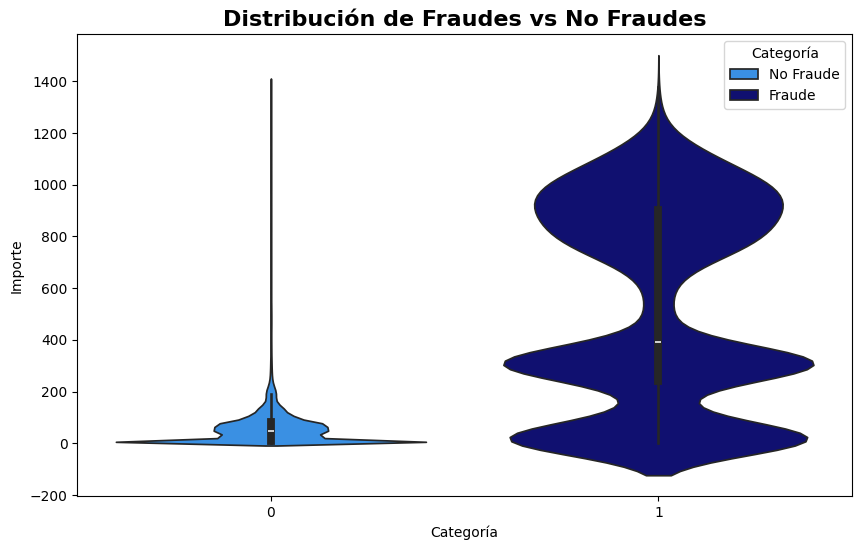

In [ ]:
# Especificamos los colores a utilizar.
colors = ["#1E90FF", "#000080"]

# Crear el gráfico de violín.
plt.figure(figsize=(10, 6))
sns.violinplot(x='is_fraud', y='amt', data=df.loc[df['amt'] < 1401], palette=colors, hue='is_fraud')

# Título y etiquetas de ejes.
plt.title("Distribución de Fraudes vs No Fraudes", fontsize=16, fontweight='bold')
plt.xlabel("Categoría")
plt.ylabel("Importe")

# Leyenda.
handles, labels = plt.gca().get_legend_handles_labels()  # Obtener los handles y etiquetas
plt.legend(handles, ['No Fraude', 'Fraude'], title="Categoría", loc='upper right')

plt.show()

Aquí se apreciará aún mejor la diferencia entre las distribuciones. De hecho, se ve que la gran mayoría de transacciones no fraudulentas son de unos pocos dólares. En las fraudulentas en cambio, se ven tres picos, el primero también para transacciones de pocos dólares, el segundo alrededor de los 400 dólares y el último cerca de los 1000.

### 5.3. Importancia de la edad

Vamos a comprobar cómo varía la cantidad de fraudes/transacciones legales en función de la edad de los titulares de las tarjetas. El objetivo principal de este análisis es explorar si la edad del titular está correlacionada con la probabilidad de que una transacción sea fraudulenta. Para ello, se muestra una comparación de la distribución de edades de los titulares de tarjetas de crédito en transacciones fraudulentas frente a transacciones no fraudulentas, utilizando una gráfica de densidad estimada. Dicha densidad no representa un número absoluto de personas, sino la probabilidad relativa de encontrar clientes en cada rango de edad.

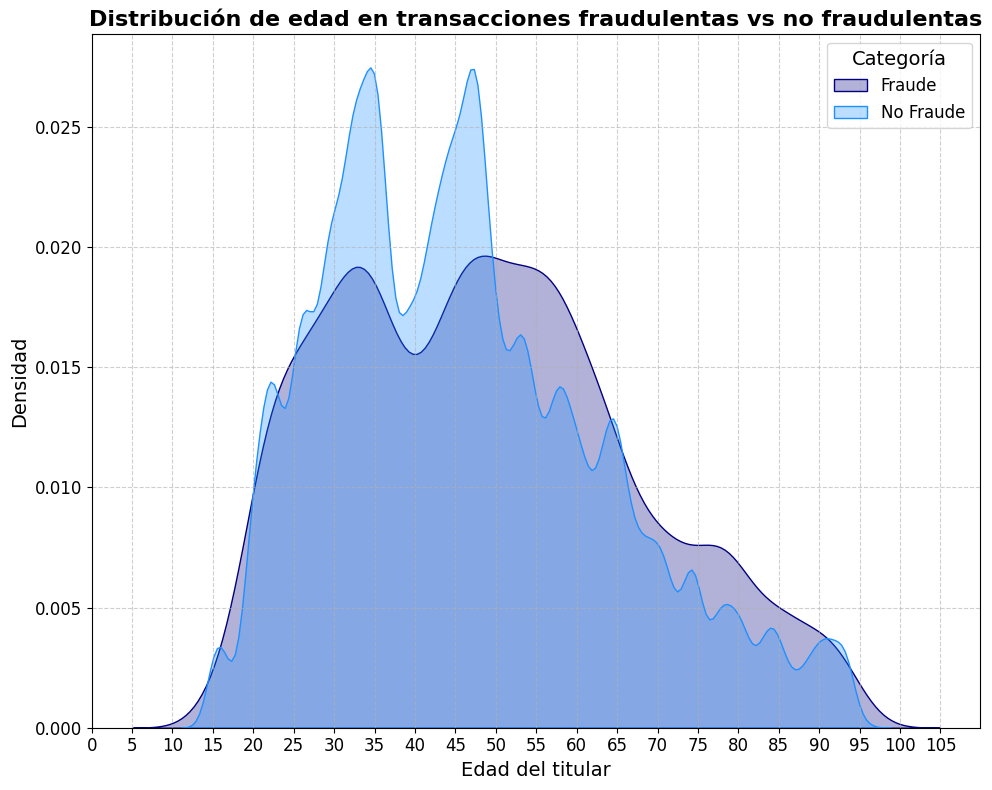

In [ ]:
# Establecemos el tamaño de la figura.
plt.figure(figsize=(10, 8))

# Crear gráfica de densidad.
ax = sns.kdeplot(
    x='edad',
    data=df,
    hue='is_fraud',
    common_norm=False,
    palette=["#1E90FF", "#000080"],
    fill=True,  # Rellena las áreas bajo las curvas.
    alpha=0.3   # Ajustar la transparencia del fill.
)

# Título y demás.
ax.set_xlabel('Edad del titular', fontsize=14)
ax.set_ylabel('Densidad', fontsize=14)
plt.xticks(np.arange(0, 110, 5), fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribución de edad en transacciones fraudulentas vs no fraudulentas', fontsize=16, fontweight='bold')

# Leyenda.
plt.legend(
    title='Categoría',
    labels=['Fraude', 'No Fraude'],
    fontsize=12,
    title_fontsize=14,
    loc='upper right'
)

# Agregar cuadrículas.
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar resultado.
plt.tight_layout()
plt.show()


De esta gráfica se puede extraer información bastante interesante. Por un lado, la mayoría de transacciones las realizan personas de alrededor de 35 o 45 años, independientemente de si son fraudulentas o no. Para personas de alrededor de 40 años se produce una bajada importante de transacciones.

Además, la probabilidad relativa de fraude es mayor para personas de más de 50 años. Aunque esto no indica el número absoluto de fraudes, sí muestra que entre los casos registrados, los titulares de más de 50 años están representados con mayor frecuencia en transacciones fraudulentas. Esto podría deberse a que:

1.   Las personas mayores pueden ser más susceptibles a engaños o fraudes digitales debido a una menor familiaridad con nuevas tecnologías.
2.   Los atacantes podrían orientar sus estrategias hacia este grupo demográfico por considerarlo más vulnerable.

### 5.4. Balance de fraudes por categoría

Para ver si la categoría de gasto a la que corresponden las transacciones es de interés, mostramos un barplot en el que se muestra el porcentaje de fraudes dentro de cada categoría. Además, la línea discontinua que se ve, representa la media de porcentaje de fraude teniendo en cuenta las 14 categorías presentadas.

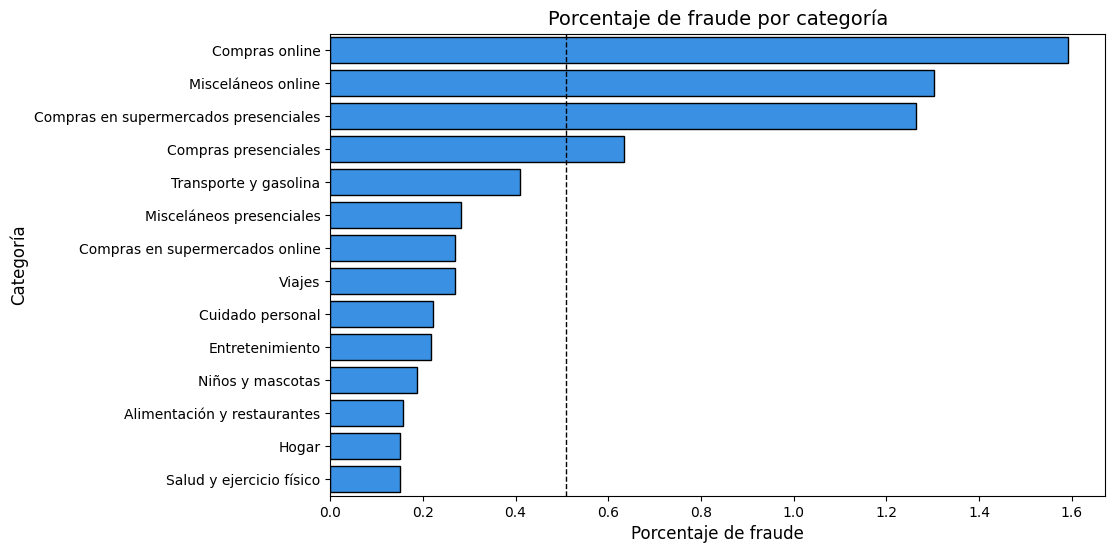

In [ ]:
# Obtenemos un nuevo dataset que resulta de quedarnos con las categorías y agrupar por fraude/no fraude.
# Es importante mencionar que se ha normalizado la cantidad de fraudes/no fraudes para quedarnos con sendas proporciones
# para cada categoría.
grouped_by_category = df.groupby('category')['is_fraud'].value_counts(normalize=True).to_frame().reset_index()

# A continuación nos quedamos solo con las cantidades correspondientes a fraudes, que son las que nos interesan de cara a la
# visualización.
fraud_per_category = grouped_by_category[grouped_by_category['is_fraud'] == 1].reset_index().drop(columns=['index'], axis=1)

# Calculamos porcentajes en lugar de proporciones para mayor claridad.
fraud_per_category['percentage'] = fraud_per_category['proportion'] * 100

# Ordenamos de mayor a menor porcentaje.
fraud_per_category.sort_values(by=['percentage'], ascending=False, inplace=True)

# Creamos la visualización.
plt.figure(figsize=(10, 6))
sns.barplot(data=fraud_per_category, x='percentage', y='category', color='#1E90FF', edgecolor='black')

plt.xlabel('Porcentaje de fraude', fontsize=12)
plt.ylabel('Categoría', fontsize=12)
plt.title('Porcentaje de fraude por categoría', fontsize=14)
plt.axvline(x=fraud_per_category['percentage'].mean(), color='black', linestyle='--', linewidth=1)

plt.show()

Se puede ver que las categorías más propensas al fraude por un margen bastante amplio son compras online en general: ropa, electrónica, etc, misceláneos y compras en supermercados de forma presencial. Por otro lado, las categorías menos comunes son salud y ejercicio físico, hogar y alimentación y restaurantes.

Una vez visualizado el porcentaje de fraude de cada categoría, vemos conveniente mostrar el coste promedio por cada una.

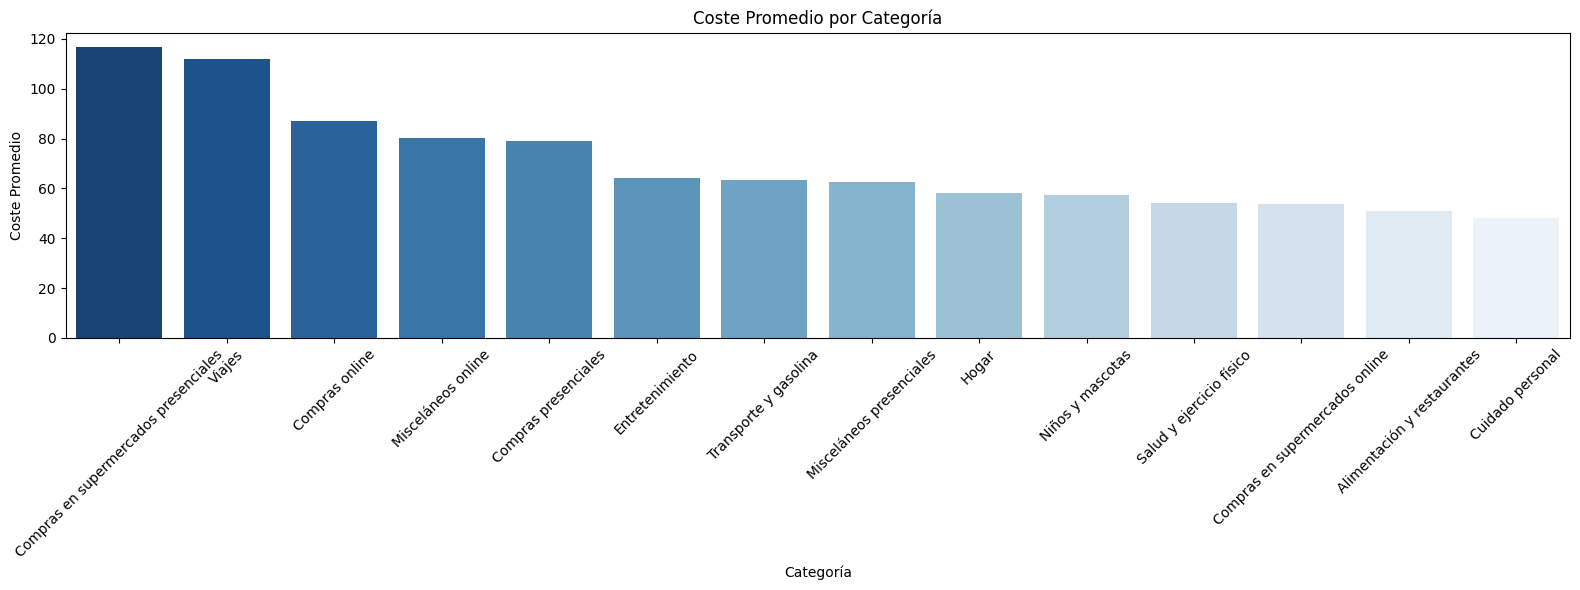

In [ ]:
# Calculamos el coste promedio por categoría y ordenamos de mayor a menor.
average_cost_by_category = df.groupby('category')['amt'].mean().sort_values(ascending=False)

# Creamos un gráfico de barras.
plt.figure(figsize=(16, 6))
sns.barplot(x=average_cost_by_category.index, y=average_cost_by_category.values, palette='Blues_r', hue=average_cost_by_category.index)

# Añadir título y etiquetas.
plt.title('Coste Promedio por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Coste Promedio')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el resultado.
plt.show()

Lo interesante de esta gráfica es ver que las categorías con mayor proporción de fraudes son también en las que hay, de media, transacciones de mayor valor.

### 5.5. Distribución de fraudes en función del tiempo

Comenzamos ahora a fijarnos en datos temporales para tratar de identificar patrones. En primer lugar, vemos el número de fraudes cometidos en las fechas de las que disponemos para tratar de ver si hay algún momento concreto en el que por alguna razón sube el número de los mismos.

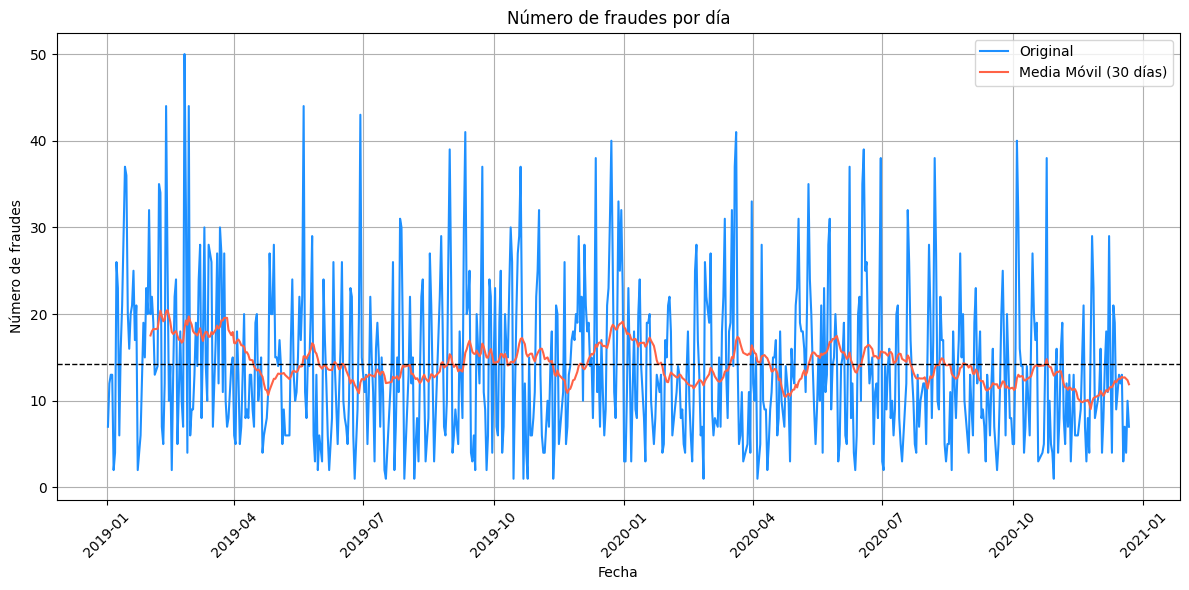

In [ ]:
# Agrupamos para quedarnos con la cantidad de fraudes por día.
frauds_per_day = df[df['is_fraud'] == 1].groupby(df['fecha'].dt.date).size().reset_index(name='n_transacciones')
# Calculamos también el resultado de una media móvil para reducir el ruido de la gráfica.
frauds_per_day['media_movil'] = frauds_per_day['n_transacciones'].rolling(window=30).mean()

# Creamos figura en la que se muestran métricas por día y cada 30 días.
plt.figure(figsize=(12, 6))
sns.lineplot(x='fecha', y='n_transacciones', data=frauds_per_day, label='Original', color='#1E90FF')
sns.lineplot(x='fecha', y='media_movil', data=frauds_per_day, label='Media Móvil (30 días)', color='#FF6347')
plt.axhline(y=frauds_per_day['n_transacciones'].mean(), color='black', linestyle='--', linewidth=1)

plt.xticks(rotation=45)
plt.xlabel('Fecha')
plt.ylabel('Número de fraudes')
plt.title('Número de fraudes por día')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

Tal y como se puede ver, es complicado sacar conclusiones a partir de la figura dada la cantidad de ruido que hay. Es por ello que se ha decidido incluir una media móvil (color naranja), gracias a la cual vemos la cantidad de fraudes calculada cada 30 días. De nuevo en este caso es complicado sacar conclusiones claras pero sí que destacan dos cuestiones:

* La cantidad de fraudes oscila mucho de un día para otro, por ejemplo, el pico máximo se produjo a principios de 2019 con 50 fraudes pero al día siguiente se produjeron menos de 10. Sin embargo, al promediar cada 30 días vemos que el número de fraudes siempre está entre los 10 y 20.

* Si nos fijamos en la media móvil veremos que los máximos parecen producirse a principios de año, mientras que a finales, la cantidad de fraudes parece decaer ligeramente (conviene fijarse en la línea discontinua mostrada que representa el promedio de fraudes diarios para todo nuestro conjunto de datos).

Veamos ahora qué porcentaje de los fraudes totales se produce cada año.

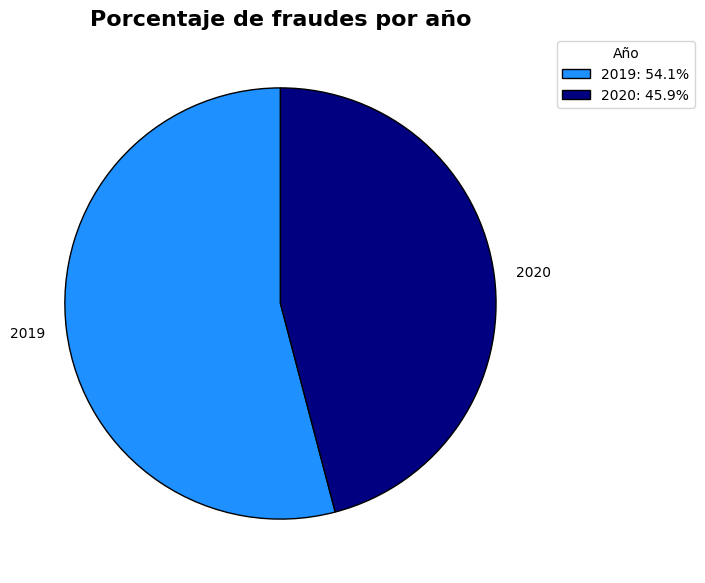

In [ ]:
# Agrupamos transacciones por año.
grouped_by_year = df.groupby('año')['is_fraud'].value_counts().to_frame().reset_index()

# Nos quedamos únicamente con los fraudes.
frauds_per_year = grouped_by_year[grouped_by_year['is_fraud'] == 1]

# Calculamos el porcentaje de fraudes por año para mostrarlo en el gráfico.
frauds_per_year = frauds_per_year.assign(percentage=frauds_per_year['count'] / frauds_per_year['count'].sum() * 100)

# Colores a utilizar.
colors = ["#1E90FF", "#000080"]

# Crear pie chart.
plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(frauds_per_year['count'], labels=frauds_per_year['año'],
                                   startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, autopct='%1.1f%%')

# Eliminar porcentajes de dentro de la figura.
for autotext in autotexts:
    autotext.set_text('')

# Título.
plt.title("Porcentaje de fraudes por año", fontsize=16, fontweight='bold')

# Colocar porcentajes en la leyenda.
plt.legend(wedges, [f'{label}: {perc:.1f}%' for label, perc in zip(['2019', '2020'], frauds_per_year['percentage'])],
           title="Año", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

# Mostrar pie chart.
plt.show()

Vemos en la figura que la cantidad de fraudes en 2019 (54.1%) es algo mayor que en 2020 (45.9%).

Para seguir con nuestro análisis en función del tiempo, nos fijamos ahora en el porcentaje de fraudes por cada mes.

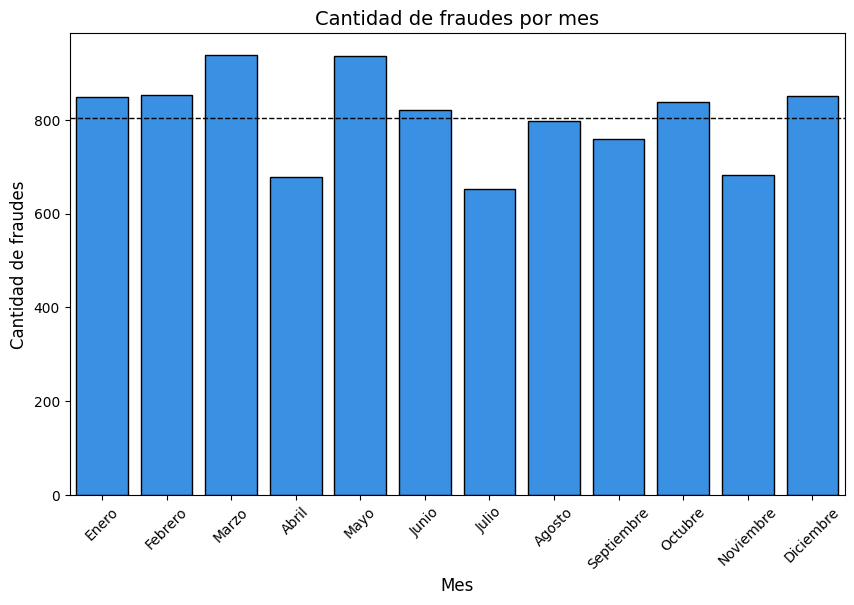

In [ ]:
# Agrupamos transacciones por mes.
grouped_by_month = df.groupby(['nombre_mes', 'mes'])['is_fraud'].value_counts().to_frame().reset_index()

# Nos quedamos con las fraudulentas.
frauds_per_month = grouped_by_month[grouped_by_month['is_fraud'] == 1].reset_index().drop(columns=['index', 'is_fraud'], axis=1)

# Ordenar por mes.
frauds_per_month.sort_values(by=['mes'], inplace=True)

# Crear gráfico de barras.
plt.figure(figsize=(10, 6))
sns.barplot(data=frauds_per_month, x='nombre_mes', y='count', color='#1E90FF', edgecolor='black')

plt.xticks(rotation=45)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Cantidad de fraudes', fontsize=12)
plt.title('Cantidad de fraudes por mes', fontsize=14)
plt.axhline(y=frauds_per_month['count'].mean(), color='black', linestyle='--', linewidth=1)

plt.show()

Vemos que

* Los meses con mayor cantidad de fraudes son marzo y mayo. En abril, julio y noviembre en cambio se tienen los mínimos.

* Teniendo en cuenta los datos de 2019 y 2020 que tenemos, se produjeron unos 800 fraudes de media por cada mes.

* Se cometen más fraudes durante la primera mitad del año que durante la segunda.

Veamos si existen diferencias en función del día de la semana. De nuevo hacemos uso de un gráfico de barras para estudiar la cantidad de fraudes.

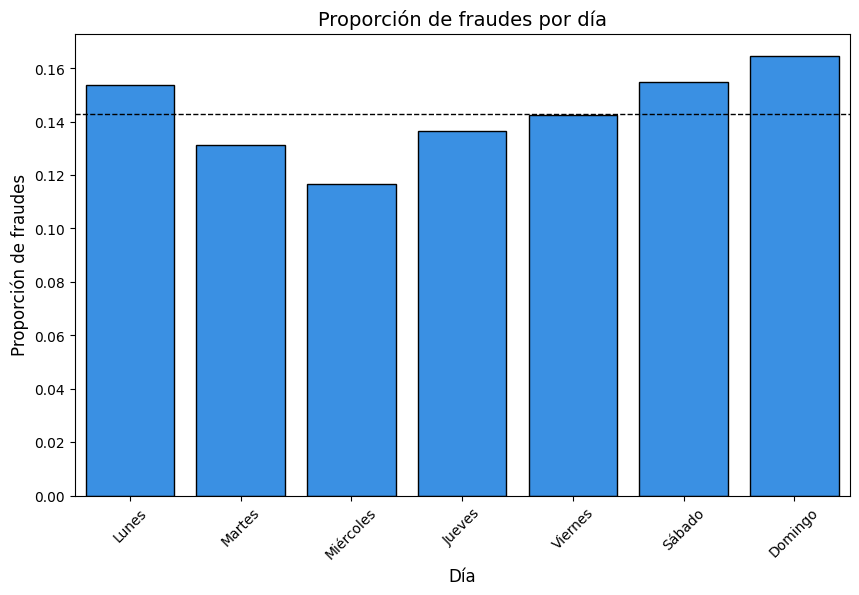

In [ ]:
# Agrupamos transacciones por día.
grouped_by_day = df.groupby(['nombre_dia', 'dia'])['is_fraud'].value_counts().to_frame().reset_index()

# Nos quedamos con las fraudulentas.
frauds_per_day = grouped_by_day[grouped_by_day['is_fraud'] == 1].reset_index().drop(columns=['index', 'is_fraud'], axis=1)

# Ordenar por mes.
frauds_per_day.sort_values(by=['dia'], inplace=True)

# Contar total de fraudes/no fraudes.
total_frauds = df[df['is_fraud'] == 1].shape[0]

# Calcular proporciones por categoría.
frauds_per_day['proportion'] = frauds_per_day['count'] / total_frauds

# Crear gráfico de barras.
plt.figure(figsize=(10, 6))
sns.barplot(data=frauds_per_day, x='nombre_dia', y='proportion', color='#1E90FF', edgecolor='black')

plt.xticks(rotation=45)
plt.xlabel('Día', fontsize=12)
plt.ylabel('Proporción de fraudes', fontsize=12)
plt.title('Proporción de fraudes por día', fontsize=14)
plt.axhline(y=frauds_per_day['proportion'].mean(), color='black', linestyle='--', linewidth=1)

plt.show()

Vemos que los días con mayor cantidad de fraudes son los sábados, domingos y lunes. El resto de la semana se produce una bajada bastante importante. Parece ser que una cantidad bastante importante de fraudes se produce durante los fines de semana.

Centrémonos ahora en las horas a las que se producen las transacciones. Para ello, de nuevo hacemos uso de un gráfico de barras en el que por cada hora se tiene la frecuencia relativa de cada tipo de transacción.

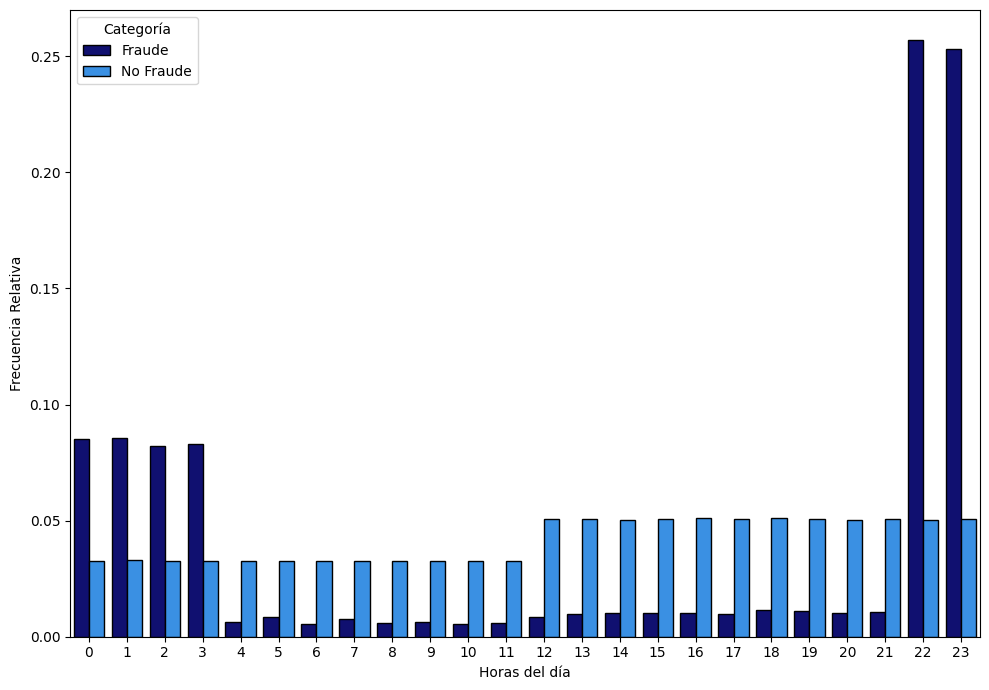

In [ ]:
# Calculamos las frecuencias relativas por hora y tipo de transacción.
hour_fraud = df[df['is_fraud'] == 1]['hora'].value_counts(normalize=True).sort_index()
hour_non_fraud = df[df['is_fraud'] == 0]['hora'].value_counts(normalize=True).sort_index()

# Unimos todo en un DataFrame.
freq_df = pd.DataFrame({
    'Hora': hour_fraud.index.union(hour_non_fraud.index),
    'Fraude': hour_fraud.reindex(hour_fraud.index.union(hour_non_fraud.index), fill_value=0),
    'No Fraude': hour_non_fraud.reindex(hour_fraud.index.union(hour_non_fraud.index), fill_value=0)
}).melt(id_vars='Hora', value_vars=['Fraude', 'No Fraude'], var_name='Tipo de Transacción', value_name='Frecuencia Relativa')

# Creamos el gráfico de barras.
plt.figure(figsize=(10, 7))
ax = sns.barplot(
    x='Hora',
    y='Frecuencia Relativa',
    hue='Tipo de Transacción',
    data=freq_df,
    palette=['#000080', '#1E90FF'],
    edgecolor='black'
)

ax.set_ylabel('Frecuencia Relativa')
ax.set_xlabel('Horas del día')

# Leyenda
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Fraude', 'No Fraude'], title="Categoría", loc='upper left')

# Mostrar resultado.
plt.tight_layout()
plt.show()

Se observan patrones muy diferenciados en la gráfica anterior:

* Para las transacciones legítimas se tiene una distribución que solo varía a partir del mediodía, donde se ve cierto aumento en el número de transacciones.

* Para los fraudes, se aprecia que se producen muy pocos durante la mañana y la tarde. Sin embargo, durante la noche se disparan, sobre todo a las 22h y las 23h, en las que se registra la mitad del total de los fraudes.

Por último, visualicemos más detenidamente la proporción de fraudes que se realiza en cada momento del día (mañana, tarde, noche).

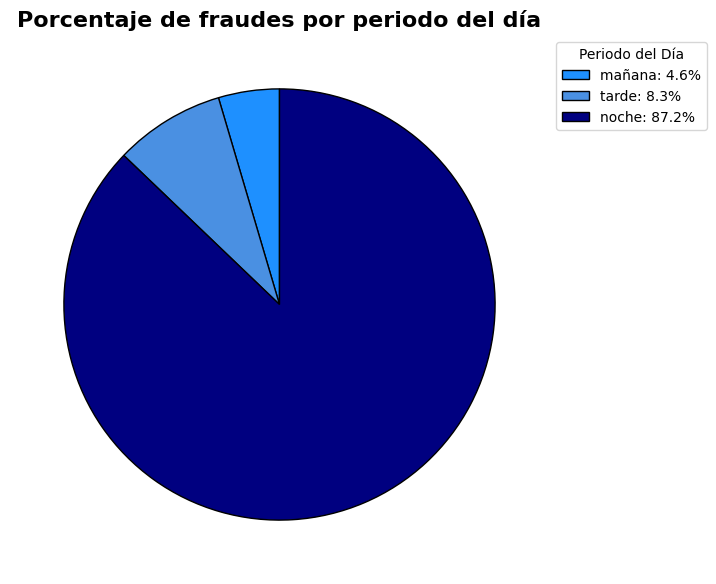

In [ ]:
# Calculamos la proporciones de fraudes según el periodo del día.
frauds_per_period = (df[df['is_fraud'] == 1].groupby('periodo_dia').size().reindex(['mañana', 'tarde', 'noche']).reset_index(name='count'))
frauds_per_period['proportion'] = frauds_per_period['count'] / frauds_per_period['count'].sum()

# Ponemos los colores a utilizar.
colors = ["#1E90FF", '#4A90E2', "#000080"]

# Crear pie chart.
plt.figure(figsize=(7, 7))
wedges, texts = plt.pie(
    frauds_per_period['proportion'],
    labels=None,  # Sin etiquetas en el gráfico
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)

# Poner título.
plt.title("Porcentaje de fraudes por periodo del día", fontsize=16, fontweight='bold')

# Colocar porcentajes en la leyenda.
plt.legend(
    wedges,
    [f"{label}: {perc * 100:.1f}%" for label, perc in zip(frauds_per_period['periodo_dia'], frauds_per_period['proportion'])],
    title="Periodo del Día",
    loc="upper left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

# Mostrar resultado.
plt.show()

Volvemos a visualizar como la gran mayoría de fraudes se cometen durante la noche.

### 5.6. Tarjetas con mayor probabilidad de fraude

Queremos visualizar con qué tarjetas se producen más fraudes.

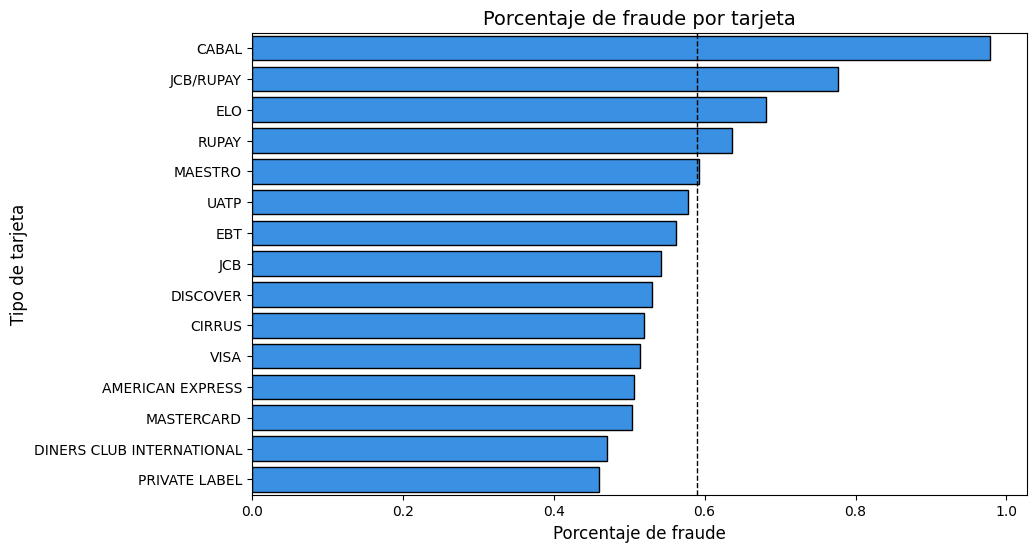

In [ ]:
# Obtenemos un nuevo dataset que resulta de quedarnos con los tipos de tarjeta y agrupar por fraude/no fraude.
# Es importante mencionar que se ha normalizado la cantidad de fraudes/no fraudes para quedarnos con sendas proporciones
# para cada categoría.
grouped_by_card_type = df.groupby('card_type')['is_fraud'].value_counts(normalize=True).to_frame().reset_index()

# A continuación nos quedamos sólo con las cantidades correspondientes a fraudes, que son las que nos interesan de cara a la
# visualización.
fraud_per_card_type = grouped_by_card_type[grouped_by_card_type['is_fraud'] == 1].reset_index().drop(columns=['index'], axis=1)

# Calculamos porcentajes en lugar de proporciones para mayor claridad.
fraud_per_card_type['percentage'] = fraud_per_card_type['proportion'] * 100

# Ordenamos de mayor a menor porcentaje.
fraud_per_card_type.sort_values(by=['percentage'], ascending=False, inplace=True)

# Creamos la visualización.
plt.figure(figsize=(10, 6))
sns.barplot(data=fraud_per_card_type, x='percentage', y='card_type', color='#1E90FF', edgecolor='black')

plt.xlabel('Porcentaje de fraude', fontsize=12)
plt.ylabel('Tipo de tarjeta', fontsize=12)
plt.title('Porcentaje de fraude por tarjeta', fontsize=14)
plt.axvline(x=fraud_per_card_type['percentage'].mean(), color='black', linestyle='--', linewidth=1)

# Mostramos el resultado.
plt.show()

Vemos que:

* CABAl es el tipo de tarjeta que tiene el mayor porcentaje de los fraudes de nuestro dataset.

* JCB/RUPAY, ELO RUPAY y MAESTRO son los demás tipos de tarjeta que también superan la media de porcentaje de fraudes.

* PRIVATE LABEL y DINERS CLUB INTERNATIONAL son los tipos de tarjeta que menos porcentaje de fraude tienen.

### 5.7. Comercios con más fraudes

Mostramos algunos de los comercios asociados a una mayor cantidad de fraudes.

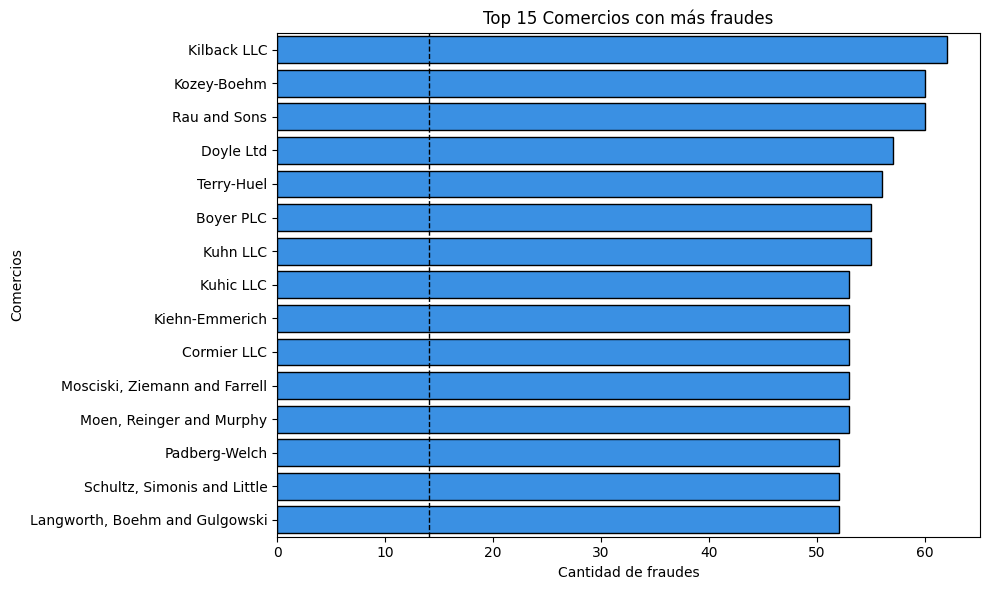

In [ ]:
# Filtramos los fraudes
fraud_data = df[df['is_fraud'] == 1]

# Contamos fraudes por merchant
fraud_counts = fraud_data['merchant'].value_counts()

# Seleccionamos los 10 comerciantes con más fraudes
top_merchants = fraud_counts.head(15)

# Crear un nuevo DataFrame con los resultados
top_merchants_df = top_merchants.reset_index()
top_merchants_df.columns = ['merchant', 'fraud_count']

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(data=top_merchants_df, x='fraud_count', y='merchant', color='#1E90FF', edgecolor='black')
plt.axvline(fraud_counts.mean(), color='black', linestyle='--', linewidth=1)
plt.title('Top 15 Comercios con más fraudes')
plt.xlabel('Cantidad de fraudes')
plt.ylabel('Comercios')
plt.tight_layout()
plt.show()

En la gráfica se muestran los 15 comercios involucrados en más fraudes. Vemos que todos ellos tienen un número de fraudes mucho mayor que la media, que es de alrededor de 15.

### 5.8. Fraudes por ubicación geográfica





Dado que contamos con información sobre la ubicación geográfica de los clientes, creemos que puede resultar interesante crear una visualización en la que podamos ver desde dónde se producen más transacciones/fraudes.

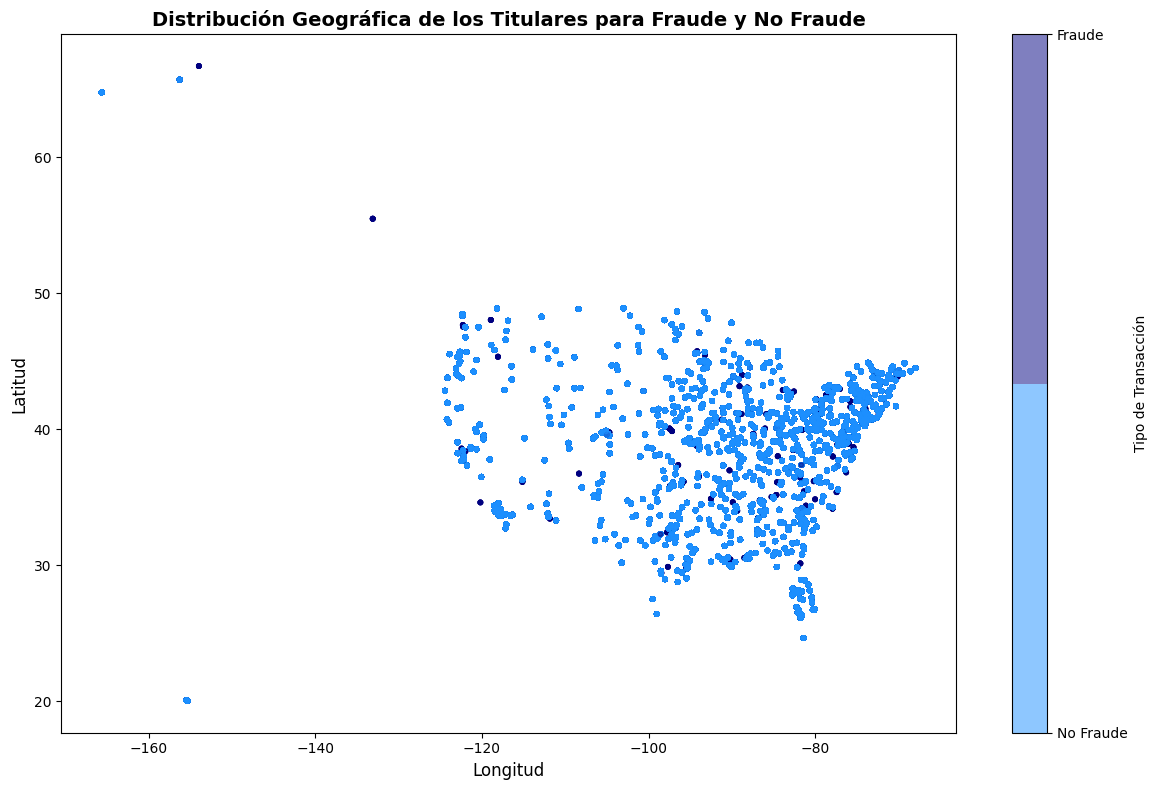

In [ ]:
from matplotlib.colors import ListedColormap

# Definimos mapa de colores para la visualización.
cmap = ListedColormap(["#1E90FF", "#000080"])

# Creamos la figura.
plt.figure(figsize=(12, 8))
sc = plt.scatter(df['long'], df['lat'], c=df['is_fraud'], cmap=cmap, alpha=0.5, s=10)

# Añadimos título y etiquetas.
plt.title('Distribución Geográfica de los Titulares para Fraude y No Fraude', fontsize=14, fontweight='bold')
plt.xlabel('Longitud', fontsize=12)
plt.ylabel('Latitud', fontsize=12)

# Configuramos la barra de color con etiquetas personalizadas.
cbar = plt.colorbar(sc, label='Tipo de Transacción')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['No Fraude', 'Fraude'])

# Mostramos el resultado.
plt.tight_layout()
plt.show()

En la figura anterior, se aprecia la distribución geográfica de transacciones en el territorio de EE.UU. Se ve que hay una mayor densidad de transacciones (y también de fraudes) en la mitad este del país.

### 5.9. Importancia de la distancia.

Para ver si la distancia entre cliente y comercio es relevante, visualizamos las distribuciones correspondientes por medio de un box plot.

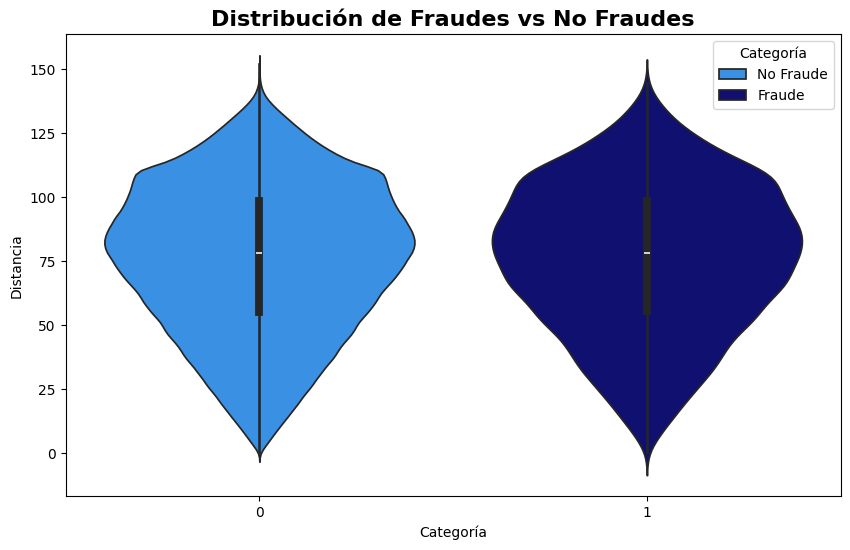

In [ ]:
# Especificamos los colores a utilizar.
colors = ["#1E90FF", "#000080"]

# Creamos el gráfico de violín.
plt.figure(figsize=(10, 6))
sns.violinplot(x='is_fraud', y='dist_to_merch', data=df.loc[df['amt'] < 1401], palette=colors, hue='is_fraud')

# Título y etiquetas de ejes.
plt.title("Distribución de Fraudes vs No Fraudes", fontsize=16, fontweight='bold')
plt.xlabel("Categoría")
plt.ylabel("Distancia")

# Leyenda.
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['No Fraude', 'Fraude'], title="Categoría", loc='upper right')

# Mostrar el resultado.
plt.show()

No parecen existir diferencias entre las distribuciones de distancias para fraudes/no fraudes. Por tanto, es posible que esta variable no resulte de interés de cara al modelo de predicción.

### 5.10. Historial de fraudes de clientes y comercios

Anteriormente, hemos creado variables que nos indican si a la fecha en la que se realiza una transacción el cliente o el comercio se han visto involucrados en fraudes. Pretendemos ver si estas variables resultan relevantes para detectar fraudes.

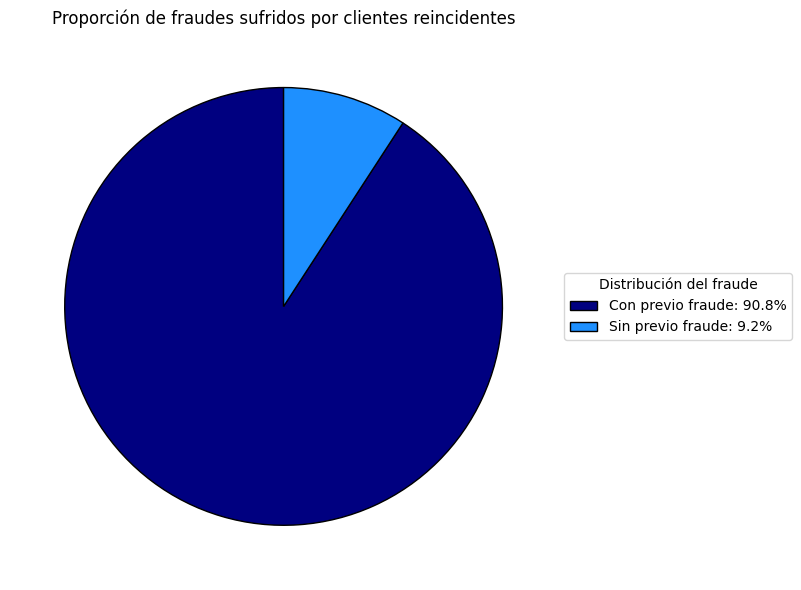

In [ ]:
# Separamos la información correspondiente a fraudes.
fraud_data = df[df['is_fraud'] == 1]

# Calculamos proporciones de fraudes de clientes según si han cometido fraudes anteriormente.
fraud_counts = fraud_data['previous_fraud_client'].value_counts(normalize=True) * 100

# Especificamos labels y colores para la gráfica.
labels = ['Con previo fraude', 'Sin previo fraude']
colors = ["#000080", "#1E90FF"]

# Creamos el pie chart.
plt.figure(figsize=(8, 6))
wedges, texts = plt.pie(
    fraud_counts,
    labels=None,
    autopct=None,
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'black'},
)

# Leyenda.
plt.legend(
    wedges,
    [f'{label}: {percentage:.1f}%' for label, percentage in zip(labels, fraud_counts)],
    title="Distribución del fraude",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

# Título.
plt.title('Proporción de fraudes sufridos por clientes reincidentes')

# Mostramos el resultado.
plt.tight_layout()
plt.show()

Vemos que en el 90.8% de los fraudes, están involucrados números de tarjetas que ya habían cometido fraudes anteriormente. Esto resulta de gran interés ya que el hecho de contar con esta variable podría ayudarnos a evitar un gran número de fraudes.

Hacemos lo mismo para la variable asociada a los comercios.

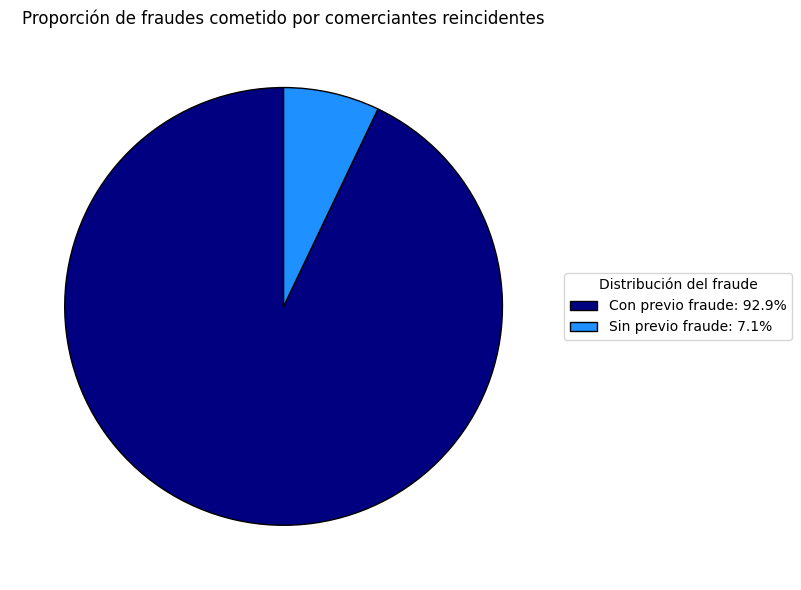

In [ ]:
# Calculamos proporciones de fraudes de comerciantes según si han cometido fraudes anteriormente.
fraud_counts = fraud_data['previous_fraud_merchant'].value_counts(normalize=True) * 100

# Configuramos datos para el gráfico.
labels = ['Con previo fraude', 'Sin previo fraude']
colors = ["#000080", "#1E90FF"]

# Creamos pi chart.
plt.figure(figsize=(8, 6))
wedges, texts = plt.pie(
    fraud_counts,
    labels=None,
    autopct=None,
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'black'},
)

# Leyenda.
plt.legend(
    wedges,
    [f'{label}: {percentage:.1f}%' for label, percentage in zip(labels, fraud_counts)],
    title="Distribución del fraude",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

# Título.
plt.title('Proporción de fraudes cometido por comerciantes reincidentes')

# Mostrar resultado.
plt.tight_layout()
plt.show()

En este caso, vemos que en el 92.9% de los casos se tienen comercios que ya se habían visto involucrados anteriormente en transacciones fraudulentas.

De esta forma, nos preguntamos finalmente si el porcentaje de fraudes que podríamos detectar aumenta si tenemos en cuenta las dos variables anteriores.

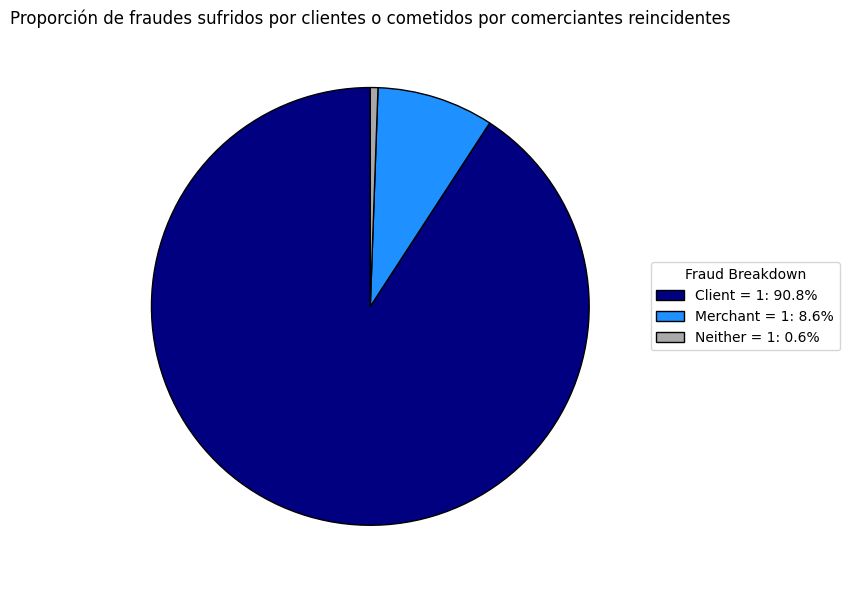

In [ ]:
# Crear categorías según las combinaciones de previous_fraud_client y previous_fraud_merchant.
fraud_data['fraud_category'] = fraud_data.apply(lambda row: 'Client = 1' if row['previous_fraud_client'] == 1 else ('Merchant = 1' if row['previous_fraud_merchant'] == 1 else 'Neither = 1'), axis=1)

# Calcular proporciones de cada categoría.
fraud_category_counts = fraud_data['fraud_category'].value_counts(normalize=True) * 100

# Especificar labels y colores.
labels = fraud_category_counts.index
colors = ["#000080", "#1E90FF", "#A9A9A9"]  # Colores personalizados

# Creamos pie chart.
plt.figure(figsize=(8, 6))
wedges, texts = plt.pie(
    fraud_category_counts,
    labels=None,
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'black'},
)

# Leyenda.
plt.legend(
    wedges,
    [f'{label}: {percentage:.1f}%' for label, percentage in zip(labels, fraud_category_counts)],
    title="Fraud Breakdown",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

# Título.
plt.title('Proporción de fraudes sufridos por clientes o cometidos por comerciantes reincidentes')

# Mostramos resultados.
plt.tight_layout()
plt.show()

Visualizamos que de todos los fraudes el 99.4% es cometido o sufrido por un cliente o comerciante que ya se había visto envuelto en otro fraude anteriormente. La conclusión es clara, poniendo el foco en ellos, seremos capaces de detectar muchos más fraudes.

## 6. Encoding y escalado

### 6.1. Eliminación de columnas no útiles

Mostramos todas las columnas que tenemos hasta ahora.

In [ ]:
df.columns

Index(['cc_num', 'merchant', 'category', 'amt', 'gender', 'city', 'state',
       'lat', 'long', 'city_pop', 'job', 'merch_lat', 'merch_long', 'is_fraud',
       'hora', 'dia', 'mes', 'año', 'nombre_dia', 'nombre_mes', 'fecha',
       'edad', 'periodo_dia', 'tipo_dia', 'card_type', 'dist_to_merch',
       'previous_fraud_client', 'previous_fraud_merchant'],
      dtype='object')

Eliminamos las columnas que no son útiles de cara a entrenar modelos.



*   cc_num: No nos interesa mantenerla, ya que al contar con el historial de fraudes de cada cliente sería redundante.
*   nombre_dia y nombre_mes: Estas son variables que creamos únicamente de cara a las visualizaciones del apartado 5.
*   city y city_pop: El número de ciudades era tan elevado y las transacciones estaban tan repartidas que no tendría sentido considerarlo.
*   job: De nuevo había demasiados trabajos como para poder extraer información valiosa o patrones significativos.
*   año: Al dividir entre train y test en función del momento de la transacción, las del 2020 estarían divididas y no tendría sentido esperar que esta columna nos fuera a servir.
*   dist_to_merch: A pesar de pensar que esta podría ser una variable de interés a la hora de crear variables sintéticas, vimos que no había diferencias en las distancia entre cliente y comercio en los casos de fraude y no fraude.



In [ ]:
# Creamos una lista de columnas a eliminar.
columns_drop = ['cc_num', 'nombre_dia', 'nombre_mes',
                'city', 'job', 'año', 'city_pop', 'dist_to_merch']

df.drop(columns_drop, axis = 1, inplace = True)
print(f'Se han eliminado {len(columns_drop)} columnas.')

Se han eliminado 8 columnas.


Las columnas restantes son las siguientes.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 1251 to 1851734
Data columns (total 20 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   merchant                 object        
 1   category                 object        
 2   amt                      float64       
 3   gender                   object        
 4   state                    object        
 5   lat                      float64       
 6   long                     float64       
 7   merch_lat                float64       
 8   merch_long               float64       
 9   is_fraud                 int64         
 10  hora                     int32         
 11  dia                      int32         
 12  mes                      int32         
 13  fecha                    datetime64[ns]
 14  edad                     int32         
 15  periodo_dia              object        
 16  tipo_dia                 int64         
 17  card_type                obje

### 6.2. Encoding de columnas categóricas

Pasamos ahora a codificar las columnas categóricas. Dependiendo de las características de cada una, vamos a utilizar una estrategia u otra. Por ejemplo, para columnas con pocas categorías, haremos uso de One Hot Encoding.

In [ ]:
df = pd.get_dummies(df, columns=['gender', 'periodo_dia'], drop_first=True)

Antes de continuar con el encoding, separamos en conjuntos de train y de test para que no se produzca data leakage. Dado que estamos teniendo en cuenta datos históricos de clientes, optamos por dividir los datos en función de la fecha. Para ello, definimos una fecha límite, tal que datos con fechas anteriores pertenezcan al conjunto de train y el resto al de test. Esto lo hacemos de modo que se reserve alrededor del 20% del total de los datos para test.

In [ ]:
# Nos aseguramos de que la columna 'fecha' esté en formato datetime.
df['fecha'] = pd.to_datetime(df['fecha'])

# Ordenamos el DataFrame por fecha.
df_sorted = df.sort_values(by='fecha')

# Definir la fecha límite.
fecha_limite = '2020-08-15'

# Dividir el DataFrame en entrenamiento y prueba.
train_df = df_sorted[df_sorted['fecha'] < fecha_limite]
test_df = df_sorted[df_sorted['fecha'] >= fecha_limite]

# Calculamos el total de muestras.
total_samples = df.shape[0]

# Calculamos los tamaños de cada conjunto.
train_size = train_df.shape[0]
test_size = test_df.shape[0]

# Calculamos porcentajes.
train_percentage = (train_size / total_samples) * 100
test_percentage = (test_size / total_samples) * 100

# Imprimimos resultados.
print(f"Conjunto de entrenamiento: {train_size} muestras ({train_percentage:.2f}%)")
print(f"Conjunto de prueba: {test_size} muestras ({test_percentage:.2f}%)")

Conjunto de entrenamiento: 1452377 muestras (78.41%)
Conjunto de prueba: 400017 muestras (21.59%)


Ahora que hemos dividido en dos conjuntos de datos, podemos eliminar la columna de fecha y desordenamos las filas ya que hasta ahora estaban ordenadas por fecha.

In [ ]:
train_df.drop('fecha', axis = 1, inplace = True)
test_df.drop('fecha', axis = 1, inplace = True)

train_df.sample(frac=1).reset_index(drop=True)
test_df.sample(frac=1).reset_index(drop=True)

,merchant,category,amt,state,lat,long,merch_lat,merch_long,is_fraud,hora,dia,mes,edad,tipo_dia,card_type,previous_fraud_client,previous_fraud_merchant,gender_M,periodo_dia_noche,periodo_dia_tarde
0,Ratke and Sons,health_fitness,42.04,TX,32.9276,-97.2489,32.333572,-97.753778,0,17,5,12,33,1,VISA,1.0,1.0,True,False,True
1,Gislason Group,misc_pos,595.27,OH,39.1657,-84.2330,38.387981,-83.402371,0,20,6,8,24,1,JCB,1.0,1.0,False,False,True
2,"Hahn, Douglas and Schowalter",travel,3.63,WY,41.4247,-105.4781,41.031832,-104.860698,0,20,0,12,32,0,VISA,1.0,1.0,False,False,True
3,Berge-Ullrich,home,16.36,MS,32.1530,-90.1217,32.071238,-89.878563,0,17,1,10,36,0,MASTERCARD,1.0,1.0,False,False,True
4,Beer-Jast,kids_pets,88.68,DC,38.9087,-77.0414,39.391861,-77.997060,0,22,0,10,34,0,EBT,1.0,1.0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400012,Predovic Inc,shopping_net,6.86,MI,46.3535,-86.6345,46.286153,-86.620554,0,12,0,12,48,0,MAESTRO,1.0,1.0,False,False,False
400013,Osinski Inc,personal_care,62.72,TX,32.1482,-99.1872,31.628163,-100.026601,0,20,6,12,67,1,DINERS CLUB INTERNATIONAL,1.0,1.0,True,False,True
400014,Auer LLC,personal_care,57.67,ND,48.8856,-103.0098,48.953175,-103.953375,0,19,0,10,52,0,DINERS CLUB INTERNATIONAL,1.0,1.0,False,False,True
400015,"Durgan, Gislason and Spencer",home,50.33,NC,36.2017,-81.1286,36.902256,-81.919600,0,18,4,8,36,0,AMERICAN EXPRESS,1.0,1.0,False,False,True


Para las demás variables categóricas, vamos a realizar un target encoding, ya que tienen muchas categorías.

El target encoding es una técnica de preprocesamiento utilizada para convertir variables categóricas en valores numéricos, basándose en la relación estadística entre cada categoría y la variable objetivo. En lugar de crear múltiples columnas binarias, el target encoding asigna a cada categoría un único valor numérico calculado como la media del target asociado a esa categoría.

In [ ]:
# Definir las columnas categóricas para aplicar target encoding y el target.
categorical_columns = ['card_type', 'merchant', 'category', 'state']
target_column = 'is_fraud'

for col in categorical_columns:
    # Calcular la media del target por categoría en el conjunto de entrenamiento.
    target_mean = train_df.groupby(col)[target_column].mean()

    # Reemplazar las categorías con la media correspondiente en el conjunto de entrenamiento.
    train_df[col] = train_df[col].map(target_mean)

    # Aplicar la misma transformación al conjunto de prueba.
    test_df[col] = test_df[col].map(target_mean)

### 6.3. Matriz de correlación

Ahora que nuestros datos son de tipo numérico, podemos mostrar la matriz de correlación.

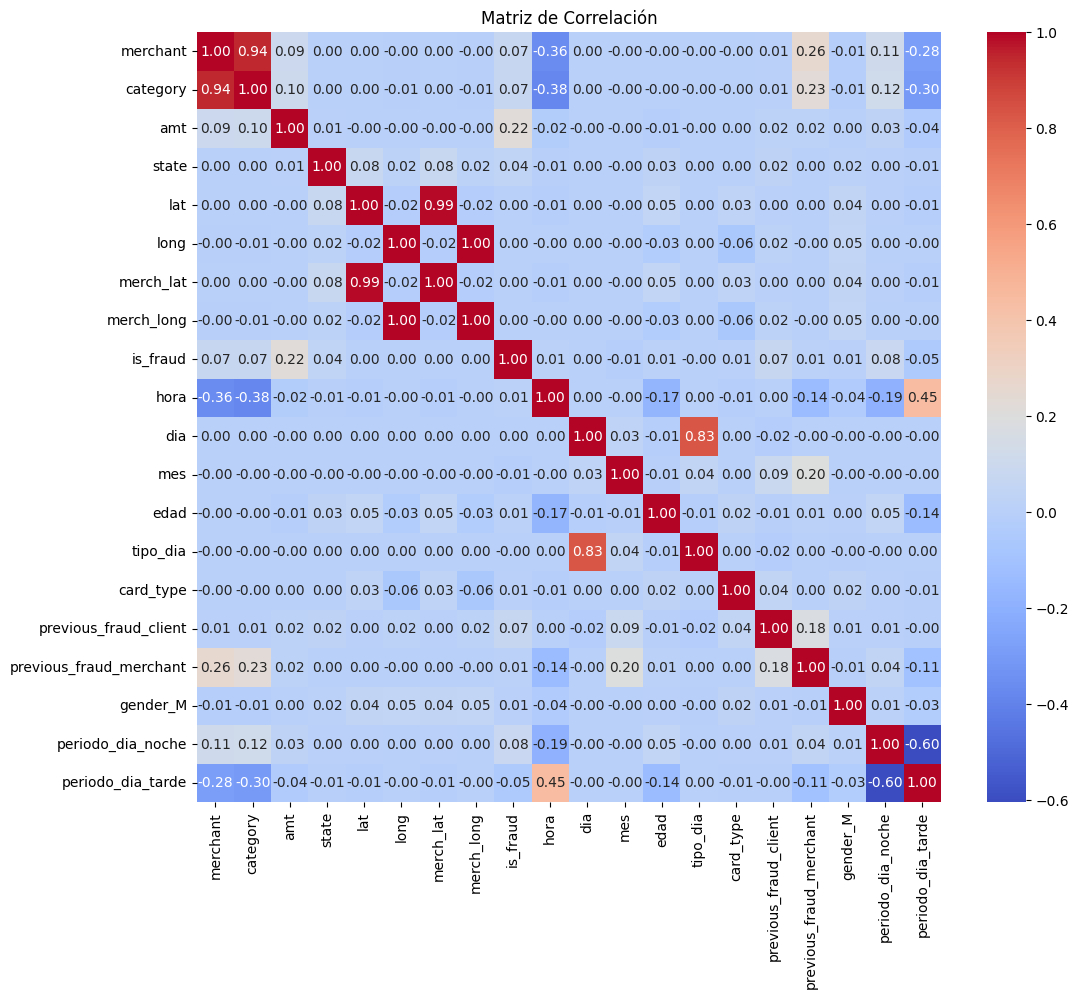

In [ ]:
# Calcular la matriz de correlación.
correlation_matrix = train_df.corr()

# Creamos un heatmap.
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlación")
plt.show()

Eliminamos columnas con alta correlación.

In [ ]:
train_df.drop(['merchant', 'merch_lat', 'merch_long', 'tipo_dia'], axis = 1, inplace = True)
test_df.drop(['merchant', 'merch_lat', 'merch_long', 'tipo_dia'], axis = 1, inplace = True)

Guardamos los dataframes de train y test.

In [ ]:
train_df.to_csv('/content/drive/Shareddrives/MUCSI-ML/Proyecto/train_df.csv', index=False)
test_df.to_csv('/content/drive/Shareddrives/MUCSI-ML/Proyecto/test_df.csv', index=False)

### 6.4. Escalado de datos

Por último llegamos al escalado de datos. Por ahora vamos a utilizar un StandardScaler ya que es un escalado muy popular que siempre da buenos resultados. No obstante, en un apartado futuro se hará uso también de MaxMinScaler.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
train_df = pd.read_csv('/content/drive/Shareddrives/MUCSI-ML/Proyecto/train_df.csv')
test_df = pd.read_csv('/content/drive/Shareddrives/MUCSI-ML/Proyecto/test_df.csv')

In [ ]:
from sklearn.preprocessing import StandardScaler

# Dividimos según variables.
x_train = train_df.drop('is_fraud', axis = 1)
y_train = train_df['is_fraud']

x_test = test_df.drop('is_fraud', axis = 1)
y_test = test_df['is_fraud']

# Configurar el escalador
scaler = StandardScaler()

# Obtener los datos escalados.
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
x_train.reset_index(drop=True, inplace=True)
x_train.head()

,category,amt,state,lat,long,hora,dia,mes,edad,card_type,previous_fraud_client,previous_fraud_merchant,gender_M,periodo_dia_noche,periodo_dia_tarde
0,0.002404,74.63,0.007670,41.0233,-98.9041,14,1,1,45,0.005652,0.0,0.0,True,False,True
1,0.001627,14.41,0.005000,35.1791,-91.2594,19,1,1,61,0.005652,0.0,0.0,False,False,True
2,0.001627,64.23,0.005095,41.2001,-92.1354,21,1,1,50,0.005559,0.0,0.0,True,True,False
3,0.001627,87.06,0.004802,38.5319,-93.9221,22,1,1,69,0.005559,0.0,0.0,False,True,False
4,0.013720,50.57,0.006017,39.0298,-77.0793,1,1,1,43,0.006142,1.0,1.0,True,True,False


## 7. Modelos

Tras procesar los datos ya estamos listos para empezar a entrenar los modelos. En este apartado vamos a considerar modelos basados en árboles. Dado el gran volumen de datos y los tiempos de entrenamiento que vamos a tener, hemos decidido escoger cuatro modelos que suelen funcionar bien en casos como el nuestro, concretamente Decision Tree, Random Forest, XGBoost y Balanced Random Forest. A la hora de entrenarlos vamos a seguir un enfoque incremental en cuanto a la complejidad de modelos, respondiendo siempre a puntos de mejora que vayamos identificando.

### 7.1. Modelos Base

En primer lugar, vamos a utilizar una única combinación de hiperparámetros para cada modelo y así tratar de ver en qué punto estamos y a partir de ahí tratar de mejorar los resultados. Al finalizar el entrenamiento de cada modelo, vamos a guardarlo en formato pickle. Esto lo hacemos para evitar que al desconectar el entorno de trabajo de colab se pierdan los avances realizados ya que tendriamos una especie de "checkpoint" cada vez que finaliza un entrenamiento.

In [ ]:
# Instalamos las librerías que vamos a necesitar para esta parte del proyecto.
!pip install xgboost imblearn scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 1.7 MB/s eta 0:00:00


In [ ]:
# Importamos los diferentes modelos y herramientas para obtención de métricas.
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, matthews_corrcoef, precision_recall_curve, auc, roc_curve, average_precision_score
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import joblib
import pickle
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier

Antes de pasar a mostrar los diferentes modelos, es importante explicar que se han creado una serie de funciones para organizar mejor el código y los resultados. A continuación se detalla el funcionamiento de cada una.



*   **get_metrics**: Devuelve un DataFrame con las métricas de interés de los modelos que queramos.

  **INPUTS:**
  - models: Diccionario con nombres de modelos y modelos considerados.
  - x_test e y_test: Datos de test considerados.

  **OUTPUTS**:
  - DataFrame con valores de precisión, recall y F1 de cada modelo.



In [ ]:
def get_metrics(models, x_test, y_test):
    results = []

    for name, model in models.items():
        y_pred = model.predict(x_test)

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results.append({
            "Model": name,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        })

    return pd.DataFrame(results)



*   plot_mcm: Permite visualizar la correspondiente matriz de confusión, que nos permite conocer el número de falsos positivos y falsos negativos.

  **INPUTS**:
  - model: Modelo entrenado.
  - x_test e y_test: Datos de test.

  **OUTPUT**:
  - Visualización de la matriz de confusión para una mejor interpretación.


In [ ]:
def plot_cm(model, x_test, y_test):
    y_pred = model.predict(x_test)

    # Calcular matriz de confusión.
    mcm = confusion_matrix(y_test, y_pred)

    # Graficar la matriz de confusión.
    plt.figure(figsize=(8, 6))
    sns.heatmap(mcm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.title(f'Matriz de confusión del modelo: {model.__class__.__name__}')
    plt.show()


*   plot_pr_curve: Permite mostrar las curvas precision-recall de los modelos que especifiquemos.


  **INPUTS**:
  - models: Diccionario con nombres y modelos considerados.
  - x_test e y_test: Conjunto de datos de test.


  **OUTPUT**:
  - Visualización de las curvas precision-recall.

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plot_pr_curve(models, x_test, y_test):
  for name, model in models.items():
      y_pred = model.predict(x_test)
      y_prob = model.predict_proba(x_test)[:, 1]

      # Calcular métricas.
      model_precision = precision_score(y_test, y_pred)
      model_recall = recall_score(y_test, y_pred)
      model_f1 = f1_score(y_test, y_pred)

      # Generar curva precisión-recall.
      precision, recall, _ = precision_recall_curve(y_test, y_prob)
      pr_auc = auc(recall, precision)
      plt.plot(recall, precision, label=f'{name}: {round(pr_auc, 2)}')

  # Mostrar resultados.
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title("Curvas Precisión-Recall")
  plt.legend()
  plt.grid()

#### 7.1.1. Decision Tree

Este modelo crea una estructura similar a un árbol donde cada nodo representa una pregunta o condición sobre los datos, y cada rama representa un posible resultado o decisión basándose en esa pregunta. El proceso continúa dividiendo los datos en subconjuntos hasta llegar a un nodo final o "hoja", que contiene la predicción o respuesta final. A continuación se citan los hiperparámetros utilizados:

* max_depth: Especifica la profundidad máxima del árbol. Una mayor profundidad
permite que el modelo aprenda patrones más complejos, pero también aumenta el riesgo de sobreajuste (overfitting). En este caso, se están probando tres valores: 10, 30 y 50.

* min_samples_split: Define el número mínimo de muestras necesarias para dividir un nodo. Si un nodo tiene menos muestras que el valor especificado, no se dividirá y se convertirá en una hoja. Valores mayores ayudan a evitar divisiones innecesarias y a reducir el sobreajuste. Aquí se prueban valores de 2, 5 y 10.

* min_samples_leaf: Determina el número mínimo de muestras que debe tener cada hoja. Esto asegura que las hojas no contengan pocas muestras, lo cual también ayuda a prevenir el sobreajuste. Se prueban valores de 1, 2 y 5.

* max_features: Controla cuántas variables se consideran para buscar la mejor división en cada nodo. La opción 'sqrt' usa la raíz cuadrada del número total de características, mientras que 'log2' utiliza el logaritmo en base 2. Esta restricción reduce la variabilidad del modelo y puede mejorar su generalización.

* criterion: Define la función de criterio usada para medir la calidad de la división en cada nodo. 'gini' y 'entropy' son las dos métricas más comunes. 'gini' intenta minimizar la probabilidad de clasificación incorrecta, mientras que 'entropy' busca minimizar la entropía, promoviendo divisiones con mayor "pureza" de clase en cada nodo.



In [ ]:
# Especificamos los hiperparámetros.
hyperparameters_dt_base = {
    "criterion": "gini",
    "max_depth": 30,
    "min_samples_split": 2,
    "min_samples_leaf": 5,
    "max_features": None,
    "random_state": 42
}

# Creación del modelo con los hiperparámetros.
model_dt = DecisionTreeClassifier(**hyperparameters_dt_base)

In [ ]:
# Entrenar modelo.
model_dt.fit(x_train_scaled, y_train)

# Realiza predicciones.
y_pred = model_dt.predict(x_test_scaled)
y_prob = model_dt.predict_proba(x_test_scaled)[:, 1]

# Calcula las métricas.
model_accuracy = accuracy_score(y_test, y_pred)
model_precision = precision_score(y_test, y_pred, average="binary")
model_recall = recall_score(y_test, y_pred, average="binary")
model_f1 = f1_score(y_test, y_pred, average="binary")
model_roc_auc = roc_auc_score(y_test, y_prob)
model_mcc = matthews_corrcoef(y_test, y_pred)
model_pr_auc = average_precision_score(y_test, y_prob)

# Guarda las métricas en un diccionario.
dict_metrics_dt = {
    "Model": model_dt.__class__.__name__ + "Base",
    "Accuracy": model_accuracy,
    "Precision": model_precision,
    "Recall": model_recall,
    "F1 Score": model_f1,
    "ROC AUC": model_roc_auc,
    "MCC": model_mcc,
    "PR AUC": model_pr_auc
}

print(dict_metrics_dt)

{'Model': 'DecisionTreeClassifierBase', 'Accuracy': 0.9982375749030666, 'Precision': 0.7359444093493367, 'Recall': 0.8023415977961432, 'F1 Score': 0.7677100494233937, 'ROC AUC': 0.932297344858288, 'MCC': 0.7675479106465577, 'PR AUC': 0.7627465772483762}


Mostramos la matriz de confusión correpondiente.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


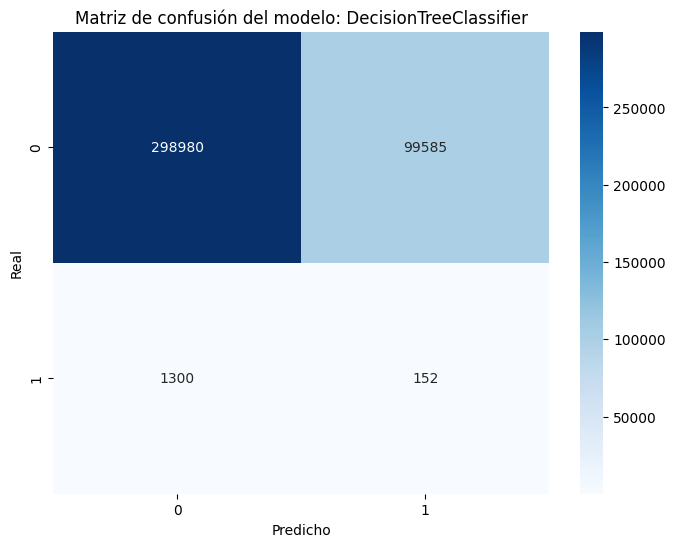

In [ ]:
plot_cm(model_dt, x_test, y_test)

Guardamos el modelo entrenado.

In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/decision_tree_model_base.pkl', 'wb') as file:
    pickle.dump(model_dt, file)
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


Cargamos el modelo.

In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/decision_tree_model_base.pkl', 'rb') as file:
    model_dt = pickle.load(file)
print("Modelo cargado exitosamente.")

Modelo cargado exitosamente.


#### 7.1.2. Random Forest

El RandomForestClassifier es un tipo de modelo de ensamble que consiste en múltiples árboles de decisión entrenados en distintas porciones de los datos. Un Random Forest mejora la precisión y la estabilidad de las predicciones al combinar los resultados de múltiples árboles de decisión, generados aleatoriamente a partir de diferentes subconjuntos de datos y características. En este proceso, cada árbol es entrenado de manera independiente, y la predicción final del bosque es la votación mayoritaria para clasificación. La técnica de aleatorización de datos y características, junto con la combinación de múltiples árboles, ayuda a reducir el sobreajuste. A continuación se citan los hiperparámetros utilizados:

* n_estimators: Especifica el número de árboles en el bosque. Cuantos más árboles, mayor es la capacidad del modelo para capturar patrones complejos, aunque a costa de un mayor tiempo de entrenamiento. Aquí se prueban valores de 100 y 200 árboles.

* max_depth: Controla la profundidad máxima de cada árbol de decisión en el bosque. Limitar la profundidad ayuda a reducir el sobreajuste, ya que árboles más profundos capturan más detalles de los datos pero pueden llegar a memorizar los ejemplos específicos. Se prueban valores de 10, 20 y 30.

* min_samples_split: Define el número mínimo de muestras necesario para dividir un nodo. Aquí se prueban valores de 2 y 5.

* min_samples_leaf: Especifica el número mínimo de muestras que debe contener una hoja (nodo final). Esto previene que el modelo genere hojas con muy pocas muestras, que pueden ser propensas al ruido. Aquí se prueban valores de 1, 2 y 4.

* max_features: Controla cuántas características se consideran al dividir un nodo en cada árbol. Al igual que para el DecisionTreeClassifier inicial, se usan 'log2' y 'sqrt'.

* bootstrap: Determina si se utiliza el muestreo con reemplazo (bootstrap) para crear los subconjuntos de datos de entrenamiento de cada árbol. Al elegir True, cada árbol se entrena en un conjunto de datos distinto, lo que contribuye a reducir la varianza y mejorar la estabilidad del modelo.

* criterion: Define la función utilizada para medir la calidad de la división en cada nodo del árbol. De nuevo se usan 'gini' y 'entropy'.

In [ ]:
# Especificamos los hiperparámetros.
hyperparameters_rf_base = {
    "n_estimators": 50,
    "criterion": "gini",
    "max_depth": 10,
    "min_samples_split": 2,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "bootstrap": True,
    "random_state": 42
}


# Creación del modelo con los hiperparámetros
model_rf = RandomForestClassifier(**hyperparameters_rf_base)

In [ ]:
# Entrenar modelo.
model_rf.fit(x_train_scaled, y_train)

# Realiza predicciones.
y_pred = model_rf.predict(x_test_scaled)
y_prob = model_rf.predict_proba(x_test_scaled)[:, 1]

# Calcula las métricas.
model_accuracy = accuracy_score(y_test, y_pred)
model_precision = precision_score(y_test, y_pred, average="binary")
model_recall = recall_score(y_test, y_pred, average="binary")
model_f1 = f1_score(y_test, y_pred, average="binary")
model_roc_auc = roc_auc_score(y_test, y_prob)
model_mcc = matthews_corrcoef(y_test, y_pred)
model_pr_auc = average_precision_score(y_test, y_prob)

# Guarda las métricas en un diccionario.
dict_metrics_rf = {
    "Model": model_rf.__class__.__name__,
    "Accuracy": model_accuracy,
    "Precision": model_precision,
    "Recall": model_recall,
    "F1 Score": model_f1,
    "ROC AUC": model_roc_auc,
    "MCC": model_mcc,
    "PR AUC": model_pr_auc
}

print(dict_metrics_rf)

{'Model': 'RandomForestClassifier', 'Accuracy': 0.9981400790466405, 'Precision': 0.890728476821192, 'Recall': 0.5557851239669421, 'F1 Score': 0.6844783715012722, 'ROC AUC': 0.9787069254891316, 'MCC': 0.7028048018785137, 'PR AUC': 0.717654510910281}


Mostramos la matriz de confusión correpondiente.

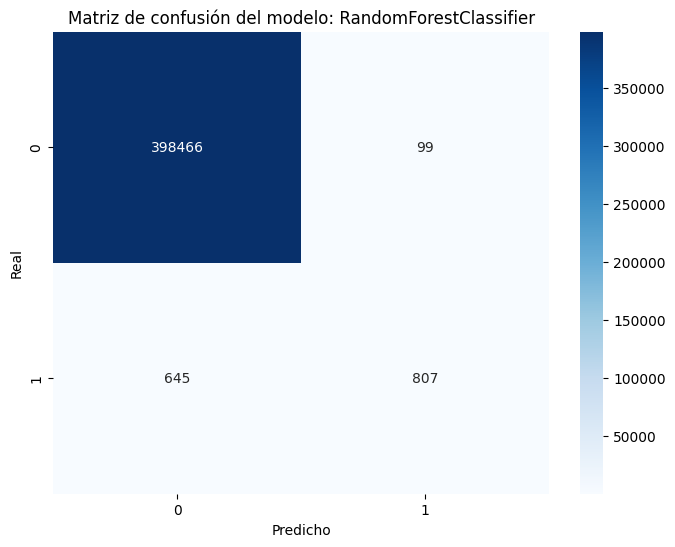

In [ ]:
plot_cm(model_rf, x_test_scaled, y_test)

Guardar el modelo entrenado.

In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/random_forest_model_base.pkl', 'wb') as file:
    pickle.dump(model_rf, file)
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


Cargar el modelo entrenado.

In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/random_forest_model_base.pkl', 'rb') as file:
    model_rf = pickle.load(file)
print("Modelo cargado exitosamente.")

Modelo cargado exitosamente.


#### 7.1.3. XGBoost

El modelo XGBClassifier es otro algoritmo de boosting muy eficiente y popular. XGBoost implementa técnicas avanzadas que permiten manejar grandes conjuntos de datos y optimizar la precisión del modelo. Se basa en el principio de construir un modelo fuerte a partir de múltiples modelos débiles (generalmente árboles de decisión) de manera secuencial. A continuación se citan los hiperparámetros utilizados:

* n_estimators: Especifica el número de árboles que se entrenarán en el modelo. Se prueban valores de 50, 100 y 200.

* learning_rate: Controla la contribución de cada árbol al modelo final. Un valor más bajo (como 0.01) puede mejorar la capacidad de generalización del modelo, pero generalmente se necesitarán más árboles (n_estimators) para lograr un rendimiento comparable. Los valores probados son 0.01 y 0.1.

* max_depth: Establece la profundidad máxima de cada árbol. Aquí se prueban profundidades de 5, 7 y 10.

* subsample: Define la proporción de muestras que se utilizarán para entrenar cada árbol. Un valor menor a 1.0 reduce el riesgo de sobreajuste y mejora la generalización al introducir aleatoriedad en el proceso de entrenamiento. Se prueban valores de 0.7 (70% de las muestras) y 1.0 (100% de las muestras).

* colsample_bytree: Controla la proporción de características que se utilizarán al construir cada árbol. Un valor menor a 1.0 puede ayudar a evitar el sobreajuste al agregar variabilidad a la construcción de los árboles. Aquí se están probando 0.7 y 1.0.

* gamma: También conocido como "min_split_loss", es un parámetro de regularización que especifica la reducción mínima de la función de pérdida requerida para hacer una división en un nodo. Un valor mayor de gamma significa que se requiere una mayor mejora para realizar una división, lo que puede ayudar a prevenir el sobreajuste. Se prueban valores de 0, 0.1 y 0.3.

* reg_alpha: Este es el término de regularización L1. Un valor mayor puede ayudar a hacer que el modelo sea más robusto al reducir la complejidad de los árboles. Los valores probados son 0, 0.1 y 1.

* reg_lambda: Este es el término de regularización L2. Similar al reg_alpha, pero se basa en una penalización cuadrática. Se prueban valores de 1 y 1.5 para observar su efecto en el rendimiento del modelo.

In [ ]:
# Selección de hiperparámetros.
hyperparameters_xgb_base = {
    "n_estimators": 50,
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 0.7,
    "colsample_bytree": 0.8,
    "gamma": 0,
    "min_child_weight": 1,
    "reg_alpha": 0,
    "reg_lambda": 1,
    "random_state": 42
}

# Creación del modelo con los hiperparámetros.
model_xgb = XGBClassifier(**hyperparameters_xgb_base)

In [ ]:
# Entrenar modelo.
model_xgb.fit(x_train_scaled, y_train)

# Realiza predicciones.
y_pred = model_xgb.predict(x_test_scaled)
y_prob = model_xgb.predict_proba(x_test_scaled)[:, 1]

# Calcula las métricas.
model_accuracy = accuracy_score(y_test, y_pred)
model_precision = precision_score(y_test, y_pred, average="binary")
model_recall = recall_score(y_test, y_pred, average="binary")
model_f1 = f1_score(y_test, y_pred, average="binary")
model_roc_auc = roc_auc_score(y_test, y_prob)
model_mcc = matthews_corrcoef(y_test, y_pred)
model_pr_auc = average_precision_score(y_test, y_prob)

# Guarda las métricas en un diccionario.
dict_metrics_xgb = {
    "Model": model_xgb.__class__.__name__,
    "Accuracy": model_accuracy,
    "Precision": model_precision,
    "Recall": model_recall,
    "F1 Score": model_f1,
    "ROC AUC": model_roc_auc,
    "MCC": model_mcc,
    "PR AUC": model_pr_auc
}

print(dict_metrics_xgb)

{'Model': 'XGBClassifier', 'Accuracy': 0.9984925640660272, 'Precision': 0.8398718975180144, 'Recall': 0.7224517906336089, 'F1 Score': 0.7767493520918178, 'ROC AUC': 0.9853460964764813, 'MCC': 0.7782132718939601, 'PR AUC': 0.7980811278326724}


Mostramos la matriz de confusión correpondiente.

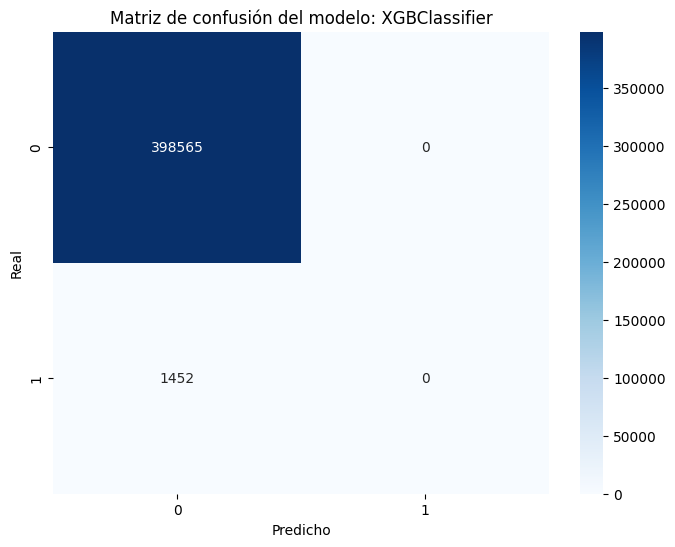

In [ ]:
plot_cm(model_xgb, x_test, y_test)

Guardar el modelo entrenado.

In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/xgb_model_base.pkl', 'wb') as file:
    pickle.dump(model_xgb, file)
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


Cargar el modelo entrenado.

In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/xgb_model_base.pkl', 'rb') as file:
    model_xgb = pickle.load(file)
print("Modelo cargado exitosamente.")

Modelo cargado exitosamente.


#### 7.1.4. Balanced Random Forest


El Balanced Random Forest es una variante del Random Forest diseñada para problemas de clasificación con datos desbalanceados. En lugar de entrenar cada árbol del bosque con una muestra aleatoria del conjunto de datos, este método crea subconjuntos balanceados seleccionando aleatoriamente la misma cantidad de muestras de cada clase. Esto asegura que todas las clases estén representadas equitativamente durante el entrenamiento, reduciendo el sesgo hacia la clase mayoritaria. Este modelo es muy popular para casos como el nuestro, con lo que queremos probar si nos da buenos resultados.

In [ ]:
# Seleccionamos los hiperparámetros.
hyperparameters_brf_base = {
    "n_estimators": 50,
    "max_depth": 5,
    "min_samples_split": 4,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "sampling_strategy": "auto",
    "replacement": False,
    "random_state": 42
}

# Creación del modelo con los hiperparámetros.
model_brf = BalancedRandomForestClassifier(**hyperparameters_brf_base)

In [ ]:
# Entrenar modelo
model_brf.fit(x_train_scaled, y_train)

# Realiza predicciones
y_pred = model_brf.predict(x_test_scaled)
y_prob = model_brf.predict_proba(x_test_scaled)[:, 1]

# Calcula las métricas
model_accuracy = accuracy_score(y_test, y_pred)
model_precision = precision_score(y_test, y_pred, average="binary")
model_recall = recall_score(y_test, y_pred, average="binary")
model_f1 = f1_score(y_test, y_pred, average="binary")
model_roc_auc = roc_auc_score(y_test, y_prob)
model_mcc = matthews_corrcoef(y_test, y_pred)
model_pr_auc = average_precision_score(y_test, y_prob)

# Guarda las métricas en un diccionario
dict_metrics_brf = {
    "Model": model_brf.__class__.__name__,
    "Accuracy": model_accuracy,
    "Precision": model_precision,
    "Recall": model_recall,
    "F1 Score": model_f1,
    "ROC AUC": model_roc_auc,
    "MCC": model_mcc,
    "PR AUC": model_pr_auc
}

print(dict_metrics_brf)

{'Model': 'BalancedRandomForestClassifier', 'Accuracy': 0.8790551401565434, 'Precision': 0.027107098230480874, 'Recall': 0.9263085399449036, 'F1 Score': 0.0526728020364206, 'ROC AUC': 0.9589043297858615, 'MCC': 0.14690312358039334, 'PR AUC': 0.512486293918525}


Mostramos la matriz de confusión correpondiente.

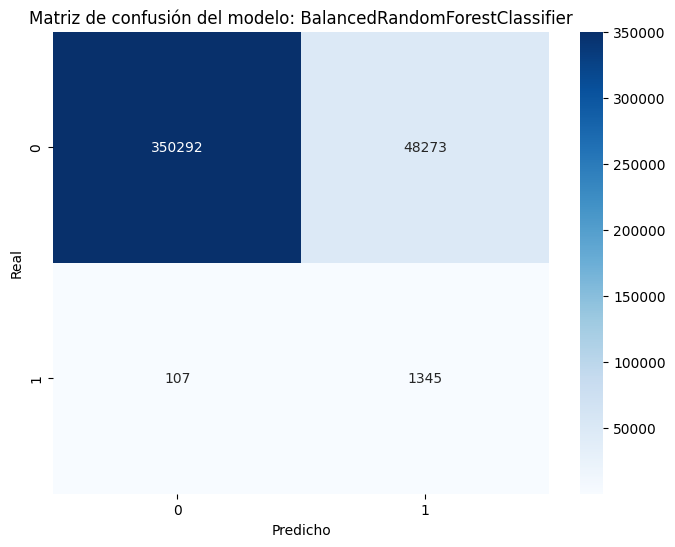

In [ ]:
plot_cm(model_brf, x_test_scaled, y_test)

Guardar el modelo entrenado.

In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/brf_model_base.pkl', 'wb') as file:
    pickle.dump(model_brf, file)
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


Cargar el modelo entrenado.

In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/brf_model_base.pkl', 'rb') as file:
    model_brf = pickle.load(file)
print("Modelo cargado exitosamente.")

Modelo cargado exitosamente.


Una vez ya hemos entrenado todos los modelos de esta primera tanda, ya podemos hacer uso de las funciones get_metrics y plot_pr_curve para comparar los resultados obtenidos.


En cuanto a los valores de precisión, recall y F1, vemos que todos los modelos obtienen puntuaciones bastante decentes teniendo en cuenta que esta no es más que una primera aproximación. Sin embargo, el Balanced Random Forest es de momento el peor con diferencia. Sospechamos que esto ocurre porque dicho modelo, al balancear los datos en un caso tan extremo como el nuestro, causa un sesgo hacia la clase de fraudes que hemos aumentado. Esto provoca que nuestro modelo piense que siempre se darán situaciones similares y por eso cuando después le pasamos datos de test de nuevo desbalanceados cataloga como fraudulentas muchas más transacciones que las que debería. No obstante, veremos si somos capaces de mejorar dicho rendimiento en apartados posteriores.

In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/decision_tree_model_base.pkl', 'rb') as file:
    model_dt = pickle.load(file)
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/random_forest_model_base.pkl', 'rb') as file:
    model_rf = pickle.load(file)
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/xgb_model_base.pkl', 'rb') as file:
    model_xgb = pickle.load(file)
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/brf_model_base.pkl', 'rb') as file:
    model_brf = pickle.load(file)

In [ ]:
models = {
    'Decision Tree': model_dt,
    'Random Forest': model_rf,
    'XGBoost': model_xgb,
    'Balanced Random Forest': model_brf
}

get_metrics(models, x_test_scaled, y_test)

,Model,Precision,Recall,F1-Score
0,Decision Tree,0.735944,0.802342,0.767710
1,Random Forest,0.890728,0.555785,0.684478
2,XGBoost,0.839872,0.722452,0.776749
3,Balanced Random Forest,0.027107,0.926309,0.052673


En cuanto a las curvas precision-recall y el área bajo las mismas, vemos que de momento el mejor resultado lo tiene el Decision Tree (0.83), aunque seguido muy de cerca por el XGBoost (0.8)

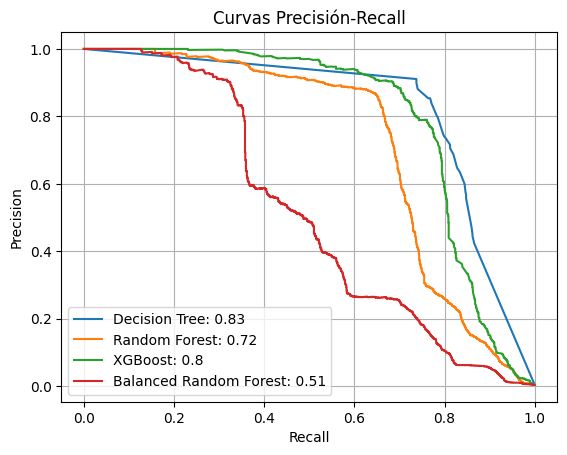

In [ ]:
plot_pr_curve(models, x_test_scaled, y_test)

### 7.2 Modelos con GridSearch

Ahora que somos conscientes de cual es el punto de partida con cada uno de los modelos, vamos a ver si somos capaces de mejorar lo que ya tenemos tratando de encontrar la combinación más óptima de hiperparámetros con GridSearch.

#### 7.2.1. Decision Tree

In [ ]:
model_dt_gs = DecisionTreeClassifier(random_state=42)

# Definimos los hiperparámetros.
param_grid_dt_gs = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": [None, "sqrt", "log2"]
}

# Configuramos el Grid Search.
grid_search_dt = GridSearchCV(
    estimator=model_dt_gs,
    param_grid=param_grid_dt_gs,
    scoring="f1",
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [ ]:
grid_search_dt.fit(x_train_scaled, y_train)

# Obtener el mejor modelo y parámetros.
best_model_dt = grid_search_dt.best_estimator_
best_params_dt = grid_search_dt.best_params_

print("Mejores hiperparámetros:", best_params_dt)

# Realizar predicciones con el mejor modelo.
y_pred = best_model_dt.predict(x_test_scaled)
y_prob = best_model_dt.predict_proba(x_test_scaled)[:, 1]

# Calcular las métricas.
model_accuracy = accuracy_score(y_test, y_pred)
model_precision = precision_score(y_test, y_pred, average="binary")
model_recall = recall_score(y_test, y_pred, average="binary")
model_f1 = f1_score(y_test, y_pred, average="binary")
model_roc_auc = roc_auc_score(y_test, y_prob)
model_mcc = matthews_corrcoef(y_test, y_pred)
model_pr_auc = average_precision_score(y_test, y_prob)

# Guardar las métricas en un diccionario.
dict_metrics_dt_gs = {
    "Model": best_model_dt.__class__.__name__ + " Grid Search",
    "Accuracy": model_accuracy,
    "Precision": model_precision,
    "Recall": model_recall,
    "F1 Score": model_f1,
    "ROC AUC": model_roc_auc,
    "MCC": model_mcc,
    "PR AUC": model_pr_auc
}

print(dict_metrics_dt_gs)

Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}

Métricas: {'Model': 'DecisionTreeClassifier Grid Search', 'Accuracy': 0.9986700565225978, 'Precision': 0.8484848484848485, 'Recall': 0.7713498622589532, 'F1 Score': 0.8080808080808081, 'ROC AUC': 0.9815007275239038, 'MCC': 0.8083384231062574, 'PR AUC': 0.8119608776484706}


In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/decision_tree_model_gs.pkl', 'wb') as file:
    pickle.dump(best_model_dt, file)
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/decision_tree_model_gs.pkl', 'rb') as file:
    model_dt_gs = pickle.load(file)
print("Modelo cargado exitosamente.")

Modelo cargado exitosamente.


Mostramos la matriz de confusión.

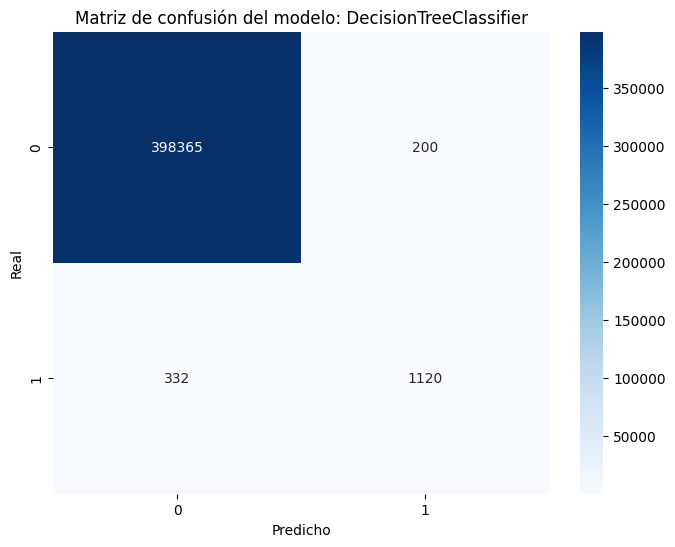

In [ ]:
plot_cm(model_dt_gs, x_test_scaled, y_test)

#### 7.2.2. Random Forest

In [ ]:
model_rf_gs = RandomForestClassifier(random_state=42)

# Definimos hiperparámetros
param_grid_rf_gs = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False]
}

# Configurar el Grid Search
grid_search_rf = GridSearchCV(
    estimator=model_rf_gs,
    param_grid=param_grid_rf_gs,
    scoring="f1",
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [ ]:
grid_search_rf.fit(x_train_scaled, y_train)

# Obtener el mejor modelo y parámetros.
best_model_rf = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_

print("Mejores hiperparámetros:", best_params_rf)

# Realizar predicciones con el mejor modelo.
y_pred = best_model_rf.predict(x_test_scaled)
y_prob = best_model_rf.predict_proba(x_test_scaled)[:, 1]

# Calcular las métricas.
model_accuracy = accuracy_score(y_test, y_pred)
model_precision = precision_score(y_test, y_pred, average="binary")
model_recall = recall_score(y_test, y_pred, average="binary")
model_f1 = f1_score(y_test, y_pred, average="binary")
model_roc_auc = roc_auc_score(y_test, y_prob)
model_mcc = matthews_corrcoef(y_test, y_pred)
model_pr_auc = average_precision_score(y_test, y_prob)

# Guardar las métricas en un diccionario.
dict_metrics_rf_gs = {
    "Model": best_model_rf.__class__.__name__ + " Grid Search",
    "Accuracy": model_accuracy,
    "Precision": model_precision,
    "Recall": model_recall,
    "F1 Score": model_f1,
    "ROC AUC": model_roc_auc,
    "MCC": model_mcc,
    "PR AUC": model_pr_auc
}

print(dict_metrics_rf_gs)

Mejores hiperparámetros: {'bootstrap': True, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

Métricas: {'Model': 'RandomForestClassifier', 'Accuracy': 0.9989100463230313, 'Precision': 0.8836858006042296, 'Recall': 0.8057851239669421, 'F1 Score': 0.8429394812680115, 'ROC AUC': 0.9843707914401868, 'MCC': 0.843296958921084, 'PR AUC': 0.8761751489316907}


In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/random_forest_model_gs.pkl', 'wb') as file:
    pickle.dump(best_model_rf, file)
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/random_forest_model_gs.pkl', 'rb') as file:
    model_rf_gs = pickle.load(file)
print("Modelo cargado exitosamente.")

Modelo cargado exitosamente.


Mostramos la matriz de confusión.

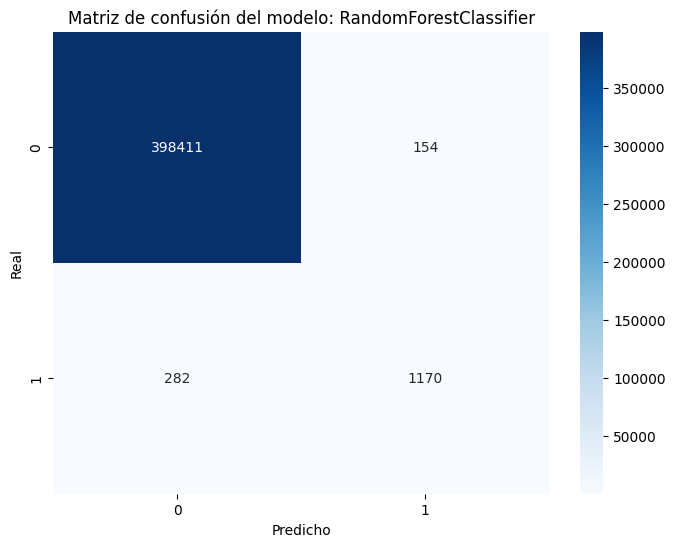

In [ ]:
plot_cm(model_rf_gs, x_test_scaled, y_test)

#### 7.2.3. XGBoost

In [ ]:
model_xgb_gs = XGBClassifier(random_state=42, use_label_encoder=False)

# Definimos hiperparámetros.
param_grid_xgb_gs = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 10],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2],
    "min_child_weight": [1, 3, 5]
}

# Configurar el Grid Search.
grid_search_xgb = GridSearchCV(
    estimator=model_xgb_gs,
    param_grid=param_grid_xgb_gs,
    scoring="f1",
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [ ]:
grid_search_xgb.fit(x_train_scaled, y_train)

# Obtener el mejor modelo y parámetros.
best_model_xgb = grid_search_xgb.best_estimator_
best_params_xgb = grid_search_xgb.best_params_

print("Mejores hiperparámetros:", best_params_xgb)

# Realizar predicciones con el mejor modelo.
y_pred = best_model_xgb.predict(x_test_scaled)
y_prob = best_model_xgb.predict_proba(x_test_scaled)[:, 1]

# Calcular las métricas.
model_accuracy = accuracy_score(y_test, y_pred)
model_precision = precision_score(y_test, y_pred, average="binary")
model_recall = recall_score(y_test, y_pred, average="binary")
model_f1 = f1_score(y_test, y_pred, average="binary")
model_roc_auc = roc_auc_score(y_test, y_prob)
model_mcc = matthews_corrcoef(y_test, y_pred)
model_pr_auc = average_precision_score(y_test, y_prob)

# Guardar las métricas en un diccionario.
dict_metrics_xgb_gs = {
    "Model": best_model_xgb.__class__.__name__ + " Grid Search",
    "Accuracy": model_accuracy,
    "Precision": model_precision,
    "Recall": model_recall,
    "F1 Score": model_f1,
    "ROC AUC": model_roc_auc,
    "MCC": model_mcc,
    "PR AUC": model_pr_auc
}

print(dict_metrics_xgb_gs)

Mejores hiperparámetros: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.8}

Métricas: {'Model': 'XGBClassifier', 'Accuracy': 0.9988375494041504, 'Precision': 0.8970233306516492, 'Recall': 0.7679063360881543, 'F1 Score': 0.8274582560296846, 'ROC AUC': 0.9954922677322526, 'MCC': 0.8293932357767996, 'PR AUC': 0.8801855411128309}


In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/xgb_model_gs.pkl', 'wb') as file:
    pickle.dump(best_model_xgb, file)
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/xgb_model_gs.pkl', 'rb') as file:
    model_xgb_gs = pickle.load(file)
print("Modelo cargado exitosamente.")

Modelo cargado exitosamente.


Mostramos la matriz de confusión.

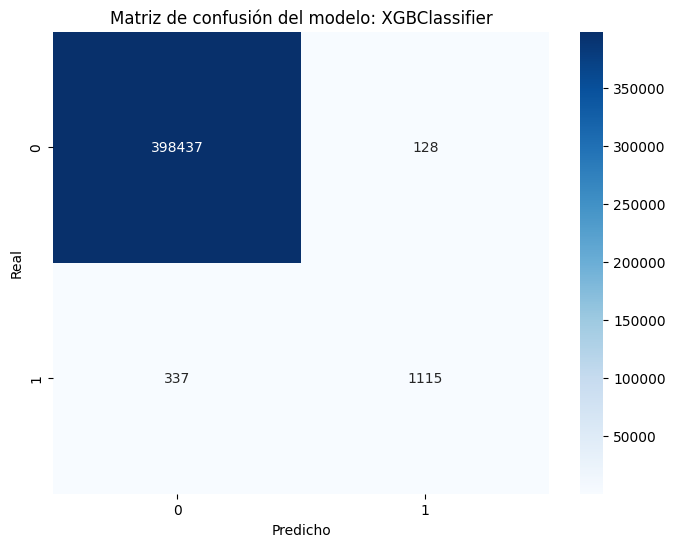

In [ ]:
plot_cm(model_xgb_gs, x_test_scaled, y_test)

#### 7.2.4 Balanced Random Forest

In [ ]:
model_brd_gs = BalancedRandomForestClassifier(random_state=42)

# Definimos hiperparámetros.
param_grid_xgb_gs = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False],
    "sampling_strategy": ["auto", 0.5, 0.7]
}

# Configurar el Grid Search.
grid_search_brf = GridSearchCV(
    estimator=model_brd_gs,
    param_grid=param_grid_xgb_gs,
    scoring="f1",
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [ ]:
grid_search_brf.fit(x_train_scaled, y_train)

# Obtener el mejor modelo y parámetros.
best_model_brf = grid_search_brf.best_estimator_
best_params_brf = grid_search_brf.best_params_

print("Mejores hiperparámetros:", best_params_brf)

# Realizar predicciones con el mejor modelo.
y_pred = best_model_brf.predict(x_test_scaled)
y_prob = best_model_brf.predict_proba(x_test_scaled)[:, 1]

# Calcular las métricas.
model_accuracy = accuracy_score(y_test, y_pred)
model_precision = precision_score(y_test, y_pred, average="binary")
model_recall = recall_score(y_test, y_pred, average="binary")
model_f1 = f1_score(y_test, y_pred, average="binary")
model_roc_auc = roc_auc_score(y_test, y_prob)
model_mcc = matthews_corrcoef(y_test, y_pred)
model_pr_auc = average_precision_score(y_test, y_prob)

# Guardar las métricas en un diccionario.
dict_metrics_brf_gs = {
    "Model": best_model_brf.__class__.__name__ + " Grid Search",
    "Accuracy": model_accuracy,
    "Precision": model_precision,
    "Recall": model_recall,
    "F1 Score": model_f1,
    "ROC AUC": model_roc_auc,
    "MCC": model_mcc,
    "PR AUC": model_pr_auc
}

print(dict_metrics_brf_gs)

Mejores hiperparámetros: {'bootstrap': True, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'sampling_strategy': 0.5}

Métricas: {'Model': 'BalancedRandomForestClassifier', 'Accuracy': 0.9796058667506631, 'Precision': 0.14705263157894738, 'Recall': 0.9621212121212122, 'F1 Score': 0.25511322132943753, 'ROC AUC': 0.9929837893995674, 'MCC': 0.37196797079088084, 'PR AUC': 0.7444849956934613}


In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/brf_model_gs.pkl', 'wb') as file:
    pickle.dump(best_model_brf, file)
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/brf_model_gs.pkl', 'rb') as file:
    model_brf_gs = pickle.load(file)
print("Modelo cargado exitosamente.")

Modelo cargado exitosamente.


Mostramos la matriz de confusión.

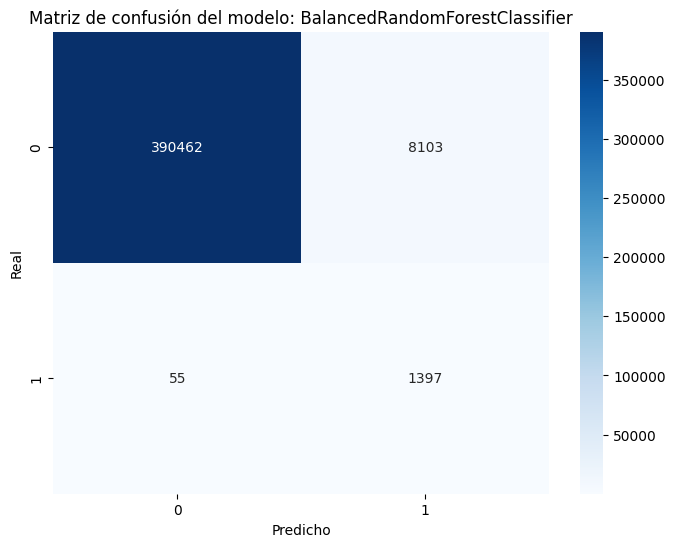

In [ ]:
plot_cm(model_brf_gs, x_test_scaled, y_test)

Analicemos ahora los resultados de los modelos de este apartado. Atendiendo a los valores de precisión, recall y F1, de nuevo vemos que el peor es el Balanced Random Forest, como los datos que utiliza para el train estan muy sesgados, clasifica como fraude muchas más transacciones que las que debería, por eso su recall es tan alto pero su precisión tan baja. Por el contrario, el resto de modelos han mejorado de manera muy notable, tanto así que todos ellos superan la barrera de 0.8 de F1. Destaca sobre todo el Random Forest, cuyo valor de F1 incluso se acerca a 0.85. Dicho modelo además es capaz de detectar más del 80% de los fraudes y lo hace con una precisión de casi el 90%.

In [ ]:
models = {
    'Decision Tree': model_dt_gs,
    'Random Forest': model_rf_gs,
    'XGBoost': model_xgb_gs,
    'Balanced Random Forest': model_brf_gs
}

get_metrics(models, x_test_scaled, y_test)

,Model,Precision,Recall,F1-Score
0,Decision Tree,0.848485,0.771350,0.808081
1,Random Forest,0.883686,0.805785,0.842939
2,XGBoost,0.897023,0.767906,0.827458
3,Balanced Random Forest,0.147053,0.962121,0.255113


En cuanto a las curvas de precision-recall ocurre algo similar, aunque en este
caso Random Forest y XGBoost empatan con valores de 0.88.

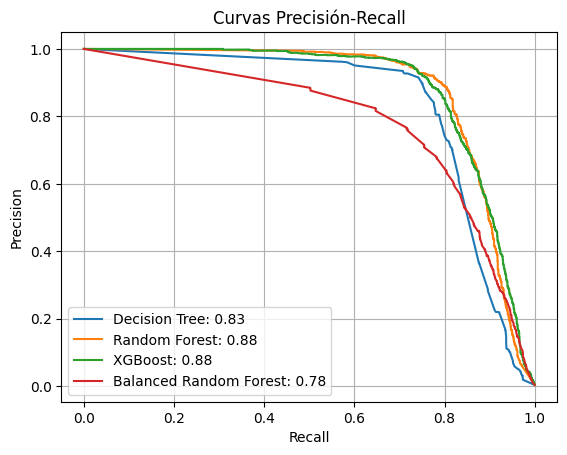

In [ ]:
plot_pr_curve(models, x_test_scaled, y_test)

### 7.3. Pruebas con SMOTE

Ahora que ya hemos podido obtener resultados bastante sólidos tras los GridSearch, vamos a tratar de utilizar un método de balanceo de datos llamado SMOTE para ver si conseguimos refinar un poco más nuestros modelos. SMOTE se encarga de balancear la clase minoritaria de fraudes creando puntos de datos sintéticos a partir de los que ya existen. A continuación, vamos a ver cuál es su impacto en algunos de los modelos que estamos considerando.

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(random_state=42, sampling_strategy=0.006, k_neighbors=3)

x_train_bal, y_train_bal = smote.fit_resample(x_train_scaled, y_train)

# Verificamos la nueva distribución.
print("Distribución de clases después de submuestreo y SMOTE:", pd.Series(y_train_bal).value_counts())

Distribución de clases después de submuestreo y SMOTE: is_fraud
0    1444178
1       8665
Name: count, dtype: int64


#### 7.3.1. Random Forest

In [ ]:
# Especificamos los mejores hiperparámetros obtenidos en el GridSearch.
hyperparameters_rf_smote = {
    "n_estimators": 100,
    "max_depth": 30,
    "min_samples_split": 10,
    "min_samples_leaf": 2,
    "max_features": None,
    "bootstrap": True,
    "random_state": 42
}

# Creación del modelo con los hiperparámetros
model_rf_smote = RandomForestClassifier(**hyperparameters_rf_smote)

In [ ]:
model_rf_smote.fit(x_train_bal, y_train_bal)

# Realizar predicciones con el modelo.
y_pred = model_rf_smote.predict(x_test_scaled)
y_prob = model_rf_smote.predict_proba(x_test_scaled)[:, 1]

# Calcular las métricas.
model_accuracy = accuracy_score(y_test, y_pred)
model_precision = precision_score(y_test, y_pred, average="binary")
model_recall = recall_score(y_test, y_pred, average="binary")
model_f1 = f1_score(y_test, y_pred, average="binary")
model_roc_auc = roc_auc_score(y_test, y_prob)
model_mcc = matthews_corrcoef(y_test, y_pred)
model_pr_auc = average_precision_score(y_test, y_prob)

# Guardar las métricas en un diccionario.
dict_metrics_rf_smote = {
    "Model": model_rf_smote.__class__.__name__ + " Smote",
    "Accuracy": model_accuracy,
    "Precision": model_precision,
    "Recall": model_recall,
    "F1 Score": model_f1,
    "ROC AUC": model_roc_auc,
    "MCC": model_mcc,
    "PR AUC": model_pr_auc
}

print(dict_metrics_rf_smote)

{'Model': 'RandomForestClassifier Smote', 'Accuracy': 0.9989050465355223, 'Precision': 0.8823529411764706, 'Recall': 0.8057851239669421, 'F1 Score': 0.8423326133909287, 'ROC AUC': 0.9832578879139381, 'MCC': 0.842657611766178, 'PR AUC': 0.873711094640476}


In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/random_forest_model_smote.pkl', 'wb') as file:
    pickle.dump(model_rf_smote, file)
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/random_forest_model_smote.pkl', 'rb') as file:
    model_rf_smote = pickle.load(file)
print("Modelo cargado exitosamente.")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Modelo cargado exitosamente.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Mostramos la matriz de confusión.

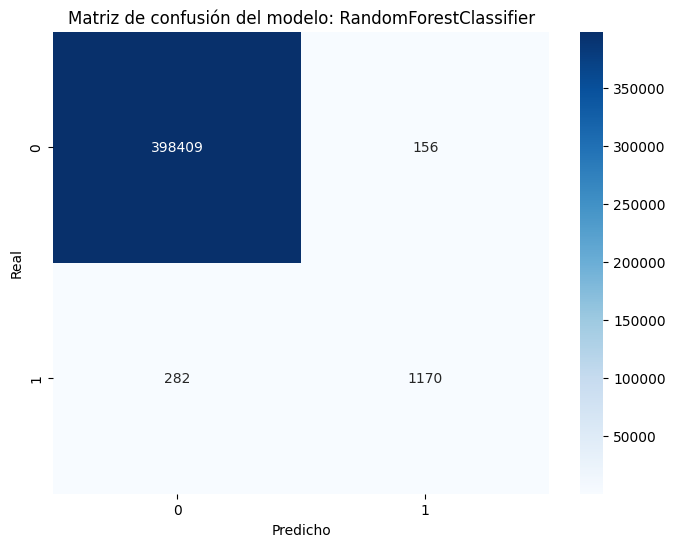

In [ ]:
plot_cm(model_rf_smote, x_test_scaled, y_test)

#### 7.3.2. XGBoost

In [ ]:
# Especificamos los mejores hiperparámetros obtenidos en el GridSearch.
hyperparameters_xgb_smote = {
    "n_estimators": 50,
    "max_depth": 10,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "gamma": 0,
    "min_child_weight": 1,
    "random_state": 42
}

# Creación del modelo con los hiperparámetros.
model_xgb_smote = XGBClassifier(**hyperparameters_xgb_smote)

In [ ]:
model_xgb_smote.fit(x_train_bal, y_train_bal)

# Realizar predicciones con el modelo.
y_pred = model_xgb_smote.predict(x_test_scaled)
y_prob = model_xgb_smote.predict_proba(x_test_scaled)[:, 1]

# Calcular las métricas.
model_accuracy = accuracy_score(y_test, y_pred)
model_precision = precision_score(y_test, y_pred, average="binary")
model_recall = recall_score(y_test, y_pred, average="binary")
model_f1 = f1_score(y_test, y_pred, average="binary")
model_roc_auc = roc_auc_score(y_test, y_prob)
model_mcc = matthews_corrcoef(y_test, y_pred)
model_pr_auc = average_precision_score(y_test, y_prob)

# Guardar las métricas en un diccionario.
dict_metrics_xgb_smote = {
    "Model": model_xgb_smote.__class__.__name__ + " Smote",
    "Accuracy": model_accuracy,
    "Precision": model_precision,
    "Recall": model_recall,
    "F1 Score": model_f1,
    "ROC AUC": model_roc_auc,
    "MCC": model_mcc,
    "PR AUC": model_pr_auc
}

print(dict_metrics_xgb_smote)

{'Model': 'XGBClassifier Smote', 'Accuracy': 0.998850048872923, 'Precision': 0.8924050632911392, 'Recall': 0.7768595041322314, 'F1 Score': 0.8306332842415317, 'ROC AUC': 0.9948868459537986, 'MCC': 0.8320684455129694, 'PR AUC': 0.8833409092380098}


In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/XGBoost_model_smote.pkl', 'wb') as file:
    pickle.dump(model_xgb_smote, file)
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/XGBoost_model_smote.pkl', 'rb') as file:
    model_xgb_smote = pickle.load(file)
print("Modelo cargado exitosamente.")

Modelo cargado exitosamente.


Mostramos la matriz de confusión.

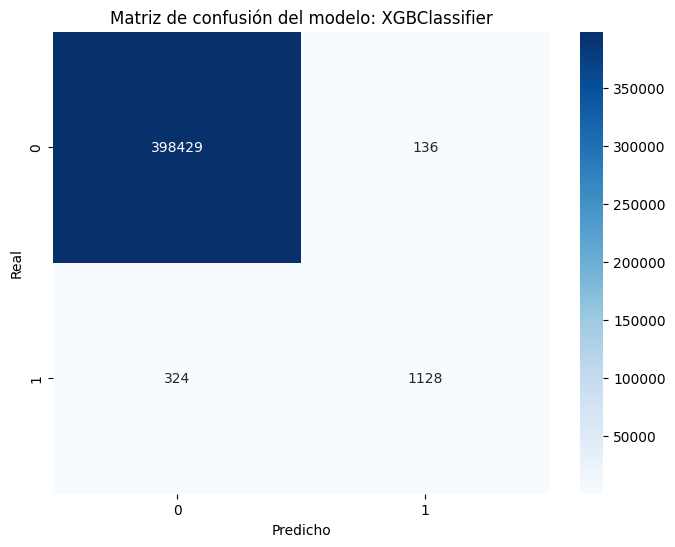

In [ ]:
plot_cm(model_xgb_smote, x_test_scaled, y_test)

Analizamos los resultados obtenidos y vemos como solo el XGBoost ha conseguido mejorar. Añadir ruido no ha conseguido que el Random Forest prediga mejor sino que aumentan los falsos positivos.

In [ ]:
models = {
    'Random Forest': model_rf_smote,
    'XGBoost': model_xgb_smote
}

get_metrics(models, x_test_scaled, y_test)

,Model,Precision,Recall,F1-Score
0,Random Forest,0.882353,0.805785,0.842333
1,XGBoost,0.892405,0.776860,0.830633


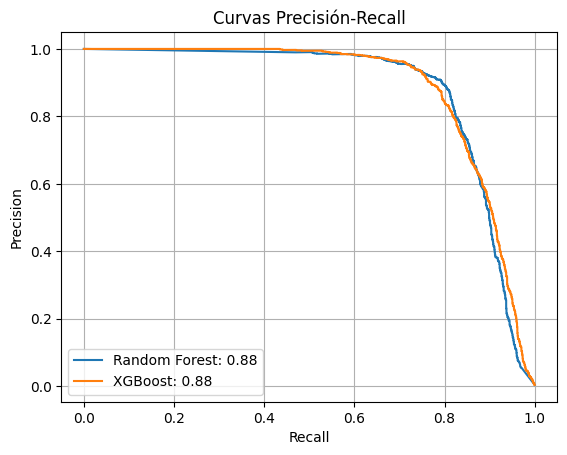

In [ ]:
plot_pr_curve(models, x_test_scaled, y_test)

### 7.4. Unión de modelos

Como último intento de mejorar los resultados que ya tenemos con los modelos basados en árboles, vamos a tratar de combinar los dos mejores modelos utilizando VotingClassifier. Se combinan las predicciones de los modelos utilizando probabilidades ponderadas y se le da mayor peso al Random Forest.

In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/xgb_model_gs.pkl', 'rb') as file:
    model_xgb_gs = pickle.load(file)
print("Modelo cargado exitosamente.")

Modelo cargado exitosamente.


In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/random_forest_model_gs.pkl', 'rb') as file:
    model_rf_gs = pickle.load(file)
print("Modelo cargado exitosamente.")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Modelo cargado exitosamente.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
from sklearn.ensemble import VotingClassifier
voting_model = VotingClassifier(
    estimators=[
        ('xgb', model_xgb_gs),
        ('rf', model_rf_gs)
    ],
    voting='soft',
    weights=[1, 1.5]
)

# Ajustar el modelo de votación
voting_model.fit(x_train_scaled, y_train)

# Realiza predicciones
y_pred = voting_model.predict(x_test_scaled)
y_prob = voting_model.predict_proba(x_test_scaled)[:, 1]

# Calcula las métricas
model_accuracy = accuracy_score(y_test, y_pred)
model_precision = precision_score(y_test, y_pred, average="binary")
model_recall = recall_score(y_test, y_pred, average="binary")
model_f1 = f1_score(y_test, y_pred, average="binary")
model_roc_auc = roc_auc_score(y_test, y_prob)
model_mcc = matthews_corrcoef(y_test, y_pred)
model_pr_auc = average_precision_score(y_test, y_prob)

# Guarda las métricas en un diccionario
dict_metrics_voting = {
    "Model": voting_model.__class__.__name__,
    "Accuracy": model_accuracy,
    "Precision": model_precision,
    "Recall": model_recall,
    "F1 Score": model_f1,
    "ROC AUC": model_roc_auc,
    "MCC": model_mcc,
    "PR AUC": model_pr_auc
}

print(dict_metrics_voting)

{'Model': 'VotingClassifier', 'Accuracy': 0.9989400450480854, 'Precision': 0.9015625, 'Recall': 0.7947658402203857, 'F1 Score': 0.8448023426061494, 'ROC AUC': 0.995302094265934, 'MCC': 0.8459623652277287, 'PR AUC': 0.8875972581956736}


In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/voting_model.pkl', 'wb') as file:
    pickle.dump(voting_model, file)
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/voting_model.pkl', 'rb') as file:
    voting_model = pickle.load(file)
print("Modelo cargado exitosamente.")

Modelo cargado exitosamente.


Mostramos la matriz de confusión.

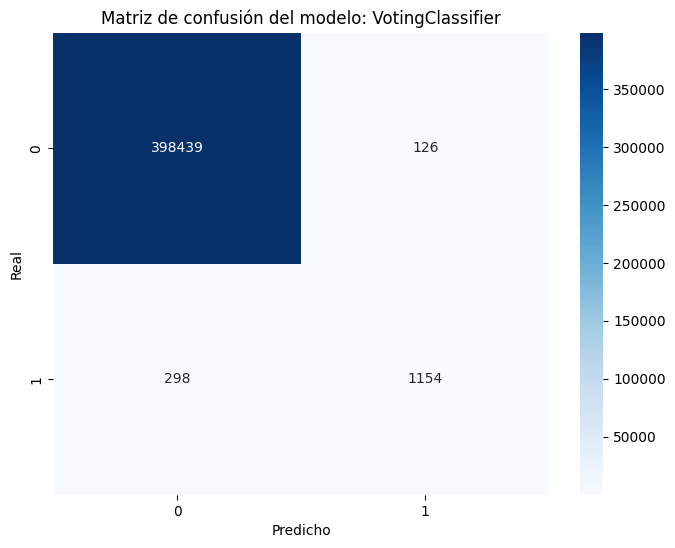

In [ ]:
plot_cm(voting_model, x_test_scaled, y_test)

Visualizamos y comparamos los resultados obtenidos.

In [ ]:
models = {
    'Random Forest': model_rf_gs,
    'XGBoost': model_xgb_gs,
    'Voting Classifier': voting_model
}

get_metrics(models, x_test_scaled, y_test)

,Model,Precision,Recall,F1-Score
0,Random Forest,0.883686,0.805785,0.842939
1,XGBoost,0.897023,0.767906,0.827458
2,Voting Classifier,0.901563,0.794766,0.844802


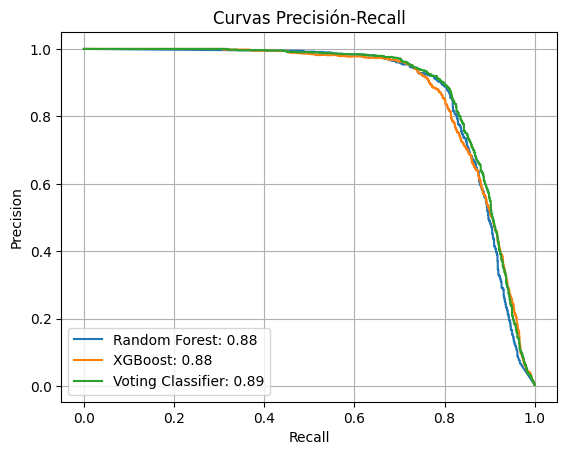

In [ ]:
plot_pr_curve(models, x_test_scaled, y_test)

## 8. Redes Neuronales

### 8.1. Redes Neuronales Base

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Una vez exploradas diferentes posibilidades con los modelos de sklearn e imbalanced learn que hemos considerado más adecuados, vamos a proceder a utilizar una serie de redes neuronales para ver si somos capaces de mejorar los resultados obtenidos. Para ello, ya que estamos usando Google Colab, vamos a hacer uso de las GPU que hay disponibles para acelerar el entrenamiento.

In [ ]:
# Vemos que en efecto Tensorflow está usando la GPU.
print("Dispositivos disponibles:", tf.config.list_physical_devices('GPU'))

Dispositivos disponibles: []


Con el fin de sacar el máximo partido a las redes neuronales, vamos a utilizar MinMaxScaler en lugar de StandardScaler, para garantizar que los valores de entrada estén entre 0 y 1 y facilitar así el aprendizaje de las redes.

In [ ]:
train_df = pd.read_csv('/content/drive/Shareddrives/MUCSI-ML/Proyecto/train_df.csv')
test_df = pd.read_csv('/content/drive/Shareddrives/MUCSI-ML/Proyecto/test_df.csv')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Dividimos según variables.
x_train = train_df.drop('is_fraud', axis = 1)
y_train = train_df['is_fraud']

x_test = test_df.drop('is_fraud', axis = 1)
y_test = test_df['is_fraud']

# Configurar el escalador.
scaler = MinMaxScaler()

# Obtener los datos escalados.
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Una vez se han escalado los datos y dado que estamos usando el F1-score como una de las métricas de referencia, tenemos que crear una función que nos permita calcular dicho valor ya que Keras no lo considera como métrica base. Esto es inmediato dado que ya conocemos cómo calcularlo.

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable(package='Custom', name='f1_score_custom')

def f1_score_custom(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(y_pred)
    y_pred = tf.cast(y_pred, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1


También calculamos una función sencilla que nos permita obtener las métricas de rendimiento sobre el conjunto de test una vez finalizado el entrenamiento de las redes. La función nos permite extraer los resultados de precisión, recall y F1-score para cada una de las redes entrenadas y almacenar dichos valores en un DataFrame para mostrar el resultado. Además, también calcula y muestra las curvas precisión-recall calculadas sobre el conjunto de test para cada modelo.

De esta forma, esta función nos permite comparar los modelos entrenados y ver qué medidas se podrían tomar para tratar de mejorar los resultados.

In [ ]:
def evaluate_models(models, X_test, y_test):
  # Crear un DataFrame vacío para los resultados.
  results = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1 Score'])

  # Lista para almacenar las curvas de precisión-recall.
  pr_curves = {}

  # Evaluar cada modelo en la lista.
  for model_name, model in models.items():
    # Hacer predicciones en el conjunto de test.
    y_pred_prob = model.predict(X_test)

    if y_pred_prob.shape[1] == 1:
        y_pred_prob = y_pred_prob[:, 0]
    y_pred = (y_pred_prob >= 0.5).astype(int)

    # Calcular precisión, recall y F1.
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    # Crear un DataFrame para los resultados del modelo actual.
    model_results = pd.DataFrame({
        'Model': [model_name],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1]
    })

    # Concatenar los resultados con el DataFrame principal.
    results = pd.concat([results, model_results], ignore_index=True)

    # Calcular y guardar la curva de precision-recall.
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_curves[model_name] = (precision_curve, recall_curve)

    pr_auc = auc(recall_curve, precision_curve)

    # Graficar la curva de precision-recall.
    plt.plot(recall_curve, precision_curve, label=f'{model_name}: {round(pr_auc, 2)}')

  # Mostrar la gráfica con las curvas de precision-recall.
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Curvas Precision-Recall')
  plt.legend()
  plt.show()

  return results, pr_curves

Al igual que en el apartado anterior de modelos, vamos a seguir un enfoque incremental en la dificultad de los mismos para poder saber de dónde partimos y hasta qué punto somos capaces de mejorar nuestras predicciones. Para ello, en primer lugar vamos a considerar tres arquitecturas sencillas, sin hacer oversampling ni undersampling y sin utilizar regularización.

La primera de las redes que consideramos cuenta únicamente con dos capas intermedias de 128 y 64 neuronas respectivamente. Para ellas se utiliza la función de activación ReLU, puesto que es una función que típicamente se utiliza para problemas como el nuestro y además es computacionalmente más eficiente que la tangente hiperbólica. La segunda cuenta con tres capas ocultas de 256, 64 y 32 neuronas y la última es algo más compleja con 5 capas de 512, 256, 128, 64 y 32 neuronas, para tratar de hallar patrones más complejos.

In [ ]:
model1 = Sequential([
    Dense(128, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model1.fit(x_train_scaled, y_train, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
5674/5674 [==============================] - 7s 1ms/step - loss: 0.0239 - f1_score_custom: 0.1645
Epoch 2/20
5674/5674 [==============================] - 7s 1ms/step - loss: 0.0167 - f1_score_custom: 0.3281
Epoch 3/20
5674/5674 [==============================] - 6s 1ms/step - loss: 0.0151 - f1_score_custom: 0.3672
Epoch 4/20
5674/5674 [==============================] - 7s 1ms/step - loss: 0.0139 - f1_score_custom: 0.3911
Epoch 5/20
5674/5674 [==============================] - 7s 1ms/step - loss: 0.0132 - f1_score_custom: 0.4158
Epoch 6/20
5674/5674 [==============================] - 7s 1ms/step - loss: 0.0126 - f1_score_custom: 0.4429
Epoch 7/20
5674/5674 [==============================] - 6s 1ms/step - loss: 0.0122 - f1_score_custom: 0.4531
Epoch 8/20
5674/5674 [==============================] - 6s 1ms/step - loss: 0.0119 - f1_score_custom: 0.4628
Epoch 9/20
5674/5674 [==============================] - 6s 1ms/step - loss: 0.0116 - f1_score_custom: 0.4689
Epoch 10/20
5674/56

In [ ]:
model1.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model1.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model1 = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model1.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


In [ ]:
model2 = Sequential([
    Dense(256, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model2.fit(x_train_scaled, y_train, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
5674/5674 [==============================] - 9s 1ms/step - loss: 0.0211 - f1_score_custom: 0.2329
Epoch 2/20
5674/5674 [==============================] - 8s 1ms/step - loss: 0.0154 - f1_score_custom: 0.3730
Epoch 3/20
5674/5674 [==============================] - 8s 1ms/step - loss: 0.0141 - f1_score_custom: 0.4056
Epoch 4/20
5674/5674 [==============================] - 8s 1ms/step - loss: 0.0132 - f1_score_custom: 0.4251
Epoch 5/20
5674/5674 [==============================] - 8s 1ms/step - loss: 0.0125 - f1_score_custom: 0.4437
Epoch 6/20
5674/5674 [==============================] - 8s 1ms/step - loss: 0.0120 - f1_score_custom: 0.4564
Epoch 7/20
5674/5674 [==============================] - 8s 1ms/step - loss: 0.0116 - f1_score_custom: 0.4671
Epoch 8/20
5674/5674 [==============================] - 8s 1ms/step - loss: 0.0111 - f1_score_custom: 0.4853
Epoch 9/20
5674/5674 [==============================] - 8s 1ms/step - loss: 0.0108 - f1_score_custom: 0.4896
Epoch 10/20
5674/56

In [ ]:
model2.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model2.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model2 = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model2.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


In [ ]:
model3 = Sequential([
    Dense(512, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model3.fit(x_train_scaled, y_train, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
5674/5674 [==============================] - 17s 3ms/step - loss: 0.0205 - f1_score_custom: 0.2525
Epoch 2/20
5674/5674 [==============================] - 16s 3ms/step - loss: 0.0155 - f1_score_custom: 0.3731
Epoch 3/20
5674/5674 [==============================] - 16s 3ms/step - loss: 0.0139 - f1_score_custom: 0.4165
Epoch 4/20
5674/5674 [==============================] - 16s 3ms/step - loss: 0.0127 - f1_score_custom: 0.4512
Epoch 5/20
5674/5674 [==============================] - 16s 3ms/step - loss: 0.0121 - f1_score_custom: 0.4652
Epoch 6/20
5674/5674 [==============================] - 16s 3ms/step - loss: 0.0116 - f1_score_custom: 0.4838
Epoch 7/20
5674/5674 [==============================] - 16s 3ms/step - loss: 0.0112 - f1_score_custom: 0.4765
Epoch 8/20
5674/5674 [==============================] - 16s 3ms/step - loss: 0.0109 - f1_score_custom: 0.4904
Epoch 9/20
5674/5674 [==============================] - 16s 3ms/step - loss: 0.0107 - f1_score_custom: 0.4919
Epoch 10/2

In [ ]:
model3.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model3 = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


Una vez entrenados los modelos, vemos cuáles han sido los resultados. En la gráfica de debajo se observan valores bastantes similares, en los tres casos el área bajo la curva precision-recall es de alrededor de 0.7

12501/12501 [==============================] - 11s 866us/step


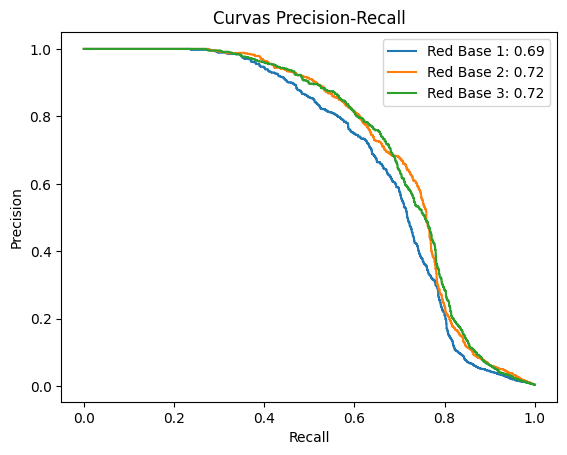

In [ ]:
models = {'Red Base 1': model1, 'Red Base 2': model2, 'Red Base 3': model3}

metrics, pr_curves = evaluate_models(models, x_test_scaled, y_test)

Echando un vistazo algo más detallado a las métricas extraídas vemos que en todos los casos se obtienen valores más altos de precisión que de recall. Por ejemplo en el caso de la red más sencilla se obtiene un valor de precisión superior a 0.8, aunque su recall es bastante bajo.

In [ ]:
metrics

,Model,Precision,Recall,F1 Score
0,Red Base 1,0.834812,0.518595,0.639762
1,Red Base 2,0.777015,0.623967,0.692131
2,Red Base 3,0.768404,0.639807,0.698234


### 8.2. Ajuste de Impacto de Clase Minoritaria

Para este siguiente enfoque, vamos a tratar de mejorar los resultados obtenidos, asignando un peso mayor a la clase menos representada. Pretendemos equilibrar el impacto de cada clase, lo cual podría ayudar al modelo a evitar sesgos con un dataset tan desbalanceado como el nuestro. En cuanto a la arquitectura de las redes, no hemos modificado nada.

De esta forma lo que hacemos es obtener los pesos correspondientes, teniendose 0.5 para transacciones legítimas y 88.6 para las fraudulentas. Tras ello, volvemos a entrenar pero esta vez añadiendo los valores mencionados al parámetro class_weight de los fit.

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(class_weight_dict)

{0: 0.5028386390043332, 1: 88.57037443590681}


In [ ]:
model1_weight = Sequential([
    Dense(128, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model1_weight.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model1_weight.fit(x_train_scaled, y_train, epochs=20, batch_size=256, verbose=1, class_weight=class_weight_dict)

Epoch 1/20
5674/5674 [==============================] - 8s 1ms/step - loss: 0.3424 - f1_score_custom: 0.0572
Epoch 2/20
5674/5674 [==============================] - 7s 1ms/step - loss: 0.2634 - f1_score_custom: 0.0794
Epoch 3/20
5674/5674 [==============================] - 7s 1ms/step - loss: 0.2433 - f1_score_custom: 0.0853
Epoch 4/20
5674/5674 [==============================] - 7s 1ms/step - loss: 0.2311 - f1_score_custom: 0.0890
Epoch 5/20
5674/5674 [==============================] - 7s 1ms/step - loss: 0.2172 - f1_score_custom: 0.0930
Epoch 6/20
5674/5674 [==============================] - 7s 1ms/step - loss: 0.2092 - f1_score_custom: 0.0980
Epoch 7/20
5674/5674 [==============================] - 7s 1ms/step - loss: 0.2032 - f1_score_custom: 0.1023
Epoch 8/20
5674/5674 [==============================] - 7s 1ms/step - loss: 0.1978 - f1_score_custom: 0.1068
Epoch 9/20
5674/5674 [==============================] - 7s 1ms/step - loss: 0.1959 - f1_score_custom: 0.1107
Epoch 10/20
5674/56

In [ ]:
model1_weight.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model1_weight.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model1_weight = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model1_weight.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


In [ ]:
model2_weight = Sequential([
    Dense(256, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model2_weight.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model2_weight.fit(x_train_scaled, y_train, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
5674/5674 [==============================] - 9s 2ms/step - loss: 0.0214 - f1_score_custom: 0.2330
Epoch 2/20
5674/5674 [==============================] - 8s 1ms/step - loss: 0.0153 - f1_score_custom: 0.3673
Epoch 3/20
5674/5674 [==============================] - 8s 1ms/step - loss: 0.0141 - f1_score_custom: 0.4005
Epoch 4/20
5674/5674 [==============================] - 9s 1ms/step - loss: 0.0133 - f1_score_custom: 0.4215
Epoch 5/20
5674/5674 [==============================] - 8s 1ms/step - loss: 0.0127 - f1_score_custom: 0.4339
Epoch 6/20
5674/5674 [==============================] - 8s 1ms/step - loss: 0.0122 - f1_score_custom: 0.4535
Epoch 7/20
5674/5674 [==============================] - 8s 1ms/step - loss: 0.0117 - f1_score_custom: 0.4680
Epoch 8/20
5674/5674 [==============================] - 8s 1ms/step - loss: 0.0114 - f1_score_custom: 0.4760
Epoch 9/20
5674/5674 [==============================] - 8s 1ms/step - loss: 0.0110 - f1_score_custom: 0.4824
Epoch 10/20
5674/56

In [ ]:
model2_weight.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model2_weight.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model2_weight = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model2_weight.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


In [ ]:
model3_weight = Sequential([
    Dense(512, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model3_weight.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model3_weight.fit(x_train_scaled, y_train, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
5674/5674 [==============================] - 16s 3ms/step - loss: 0.0207 - f1_score_custom: 0.2469
Epoch 2/20
5674/5674 [==============================] - 16s 3ms/step - loss: 0.0155 - f1_score_custom: 0.3697
Epoch 3/20
5674/5674 [==============================] - 16s 3ms/step - loss: 0.0141 - f1_score_custom: 0.4073
Epoch 4/20
5674/5674 [==============================] - 16s 3ms/step - loss: 0.0129 - f1_score_custom: 0.4481
Epoch 5/20
5674/5674 [==============================] - 16s 3ms/step - loss: 0.0123 - f1_score_custom: 0.4642
Epoch 6/20
5674/5674 [==============================] - 16s 3ms/step - loss: 0.0117 - f1_score_custom: 0.4772
Epoch 7/20
5674/5674 [==============================] - 16s 3ms/step - loss: 0.0113 - f1_score_custom: 0.4883
Epoch 8/20
5674/5674 [==============================] - 16s 3ms/step - loss: 0.0110 - f1_score_custom: 0.4869
Epoch 9/20
5674/5674 [==============================] - 16s 3ms/step - loss: 0.0109 - f1_score_custom: 0.4853
Epoch 10/2

In [ ]:
model3_weight.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_weight.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model3_weight = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_weight.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


En general se tienen resultados muy parecidos, excepto para la primera red, para la que se ha obtenido un rendimiento notablemente peor.

12501/12501 [==============================] - 11s 865us/step


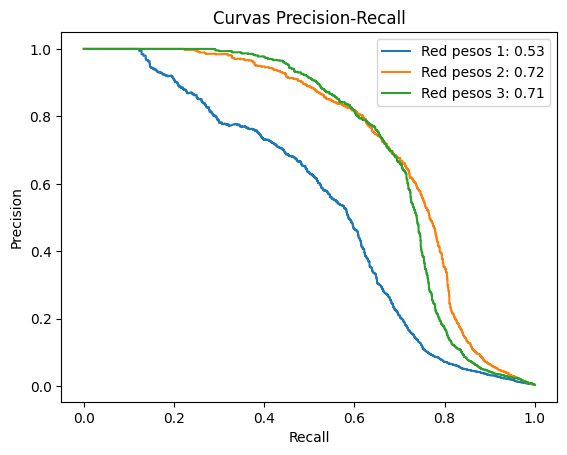

In [ ]:
models = {'Red pesos 1': model1_weight, 'Red pesos 2': model2_weight, 'Red pesos 3': model3_weight}

metrics, pr_curves = evaluate_models(models, x_test_scaled, y_test)

Fijándonos en los valores de precisión y recall, nos damos cuenta de que el problema en la primera red viene de que a pesar un excelente recall cercano a 0,9, la precisión obtenida es muy mala. En definitva, el ajuste de los pesos por clase no nos ha servido y vamos a tratar de dar con otra alternativa.

In [ ]:
metrics

,Model,Precision,Recall,F1 Score
0,Red pesos 1,0.022621,0.935262,0.044174
1,Red pesos 2,0.768140,0.634298,0.694832
2,Red pesos 3,0.787326,0.624656,0.696621


### 8.3. Remuestreo de datos

Tal y como se ha hecho para los modelos basados en árboles, vamos a estudiar el impacto de balancear los datos mediante diversas técnicas. En primer lugar vamos a hacer uso del sobremuestreo.

#### 8.3.1. Random Undersampling

Como siempre, modificamos nuestros datos y después procedemos a entrenar las redes de nuevo. Hemos optado por no reducir demasiado las instancias de la clase mayoritaria ya que si no los resultados empeoraban mucho, hemos decidido quedarnos con un valor de 0.01, que indica que se tienen 100 veces más casos de transacciones legítimas que de fraudes, cuando inicialmente la proporción era de 200 a uno.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, sampling_strategy=0.01)

x_train_rus, y_train_rus = rus.fit_resample(x_train_scaled, y_train)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x79411ef17010>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error


In [ ]:
model1_rus = Sequential([
    Dense(128, activation='relu', input_shape=(x_train_rus.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model1_rus.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model1_rus.fit(x_train_rus, y_train_rus, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
3235/3235 [==============================] - 4s 1ms/step - loss: 0.0373 - f1_score_custom: 0.2269
Epoch 2/20
3235/3235 [==============================] - 4s 1ms/step - loss: 0.0271 - f1_score_custom: 0.4281
Epoch 3/20
3235/3235 [==============================] - 4s 1ms/step - loss: 0.0245 - f1_score_custom: 0.4633
Epoch 4/20
3235/3235 [==============================] - 4s 1ms/step - loss: 0.0224 - f1_score_custom: 0.5063
Epoch 5/20
3235/3235 [==============================] - 4s 1ms/step - loss: 0.0211 - f1_score_custom: 0.5453
Epoch 6/20
3235/3235 [==============================] - 4s 1ms/step - loss: 0.0204 - f1_score_custom: 0.5616
Epoch 7/20
3235/3235 [==============================] - 4s 1ms/step - loss: 0.0199 - f1_score_custom: 0.5842
Epoch 8/20
3235/3235 [==============================] - 4s 1ms/step - loss: 0.0195 - f1_score_custom: 0.5935
Epoch 9/20
3235/3235 [==============================] - 4s 1ms/step - loss: 0.0190 - f1_score_custom: 0.5981
Epoch 10/20
3235/32

In [ ]:
model1_rus.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model1_rus.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model1_rus = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model1_rus.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


In [ ]:
model2_rus = Sequential([
    Dense(256, activation='relu', input_shape=(x_train_rus.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model2_rus.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model2_rus.fit(x_train_rus, y_train_rus, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
3235/3235 [==============================] - 6s 2ms/step - loss: 0.0337 - f1_score_custom: 0.3034
Epoch 2/20
3235/3235 [==============================] - 5s 1ms/step - loss: 0.0240 - f1_score_custom: 0.4902
Epoch 3/20
3235/3235 [==============================] - 5s 1ms/step - loss: 0.0215 - f1_score_custom: 0.5409
Epoch 4/20
3235/3235 [==============================] - 4s 1ms/step - loss: 0.0204 - f1_score_custom: 0.5693
Epoch 5/20
3235/3235 [==============================] - 5s 1ms/step - loss: 0.0197 - f1_score_custom: 0.5889
Epoch 6/20
3235/3235 [==============================] - 5s 1ms/step - loss: 0.0189 - f1_score_custom: 0.6037
Epoch 7/20
3235/3235 [==============================] - 5s 1ms/step - loss: 0.0181 - f1_score_custom: 0.6035
Epoch 8/20
3235/3235 [==============================] - 5s 1ms/step - loss: 0.0174 - f1_score_custom: 0.6324
Epoch 9/20
3235/3235 [==============================] - 4s 1ms/step - loss: 0.0168 - f1_score_custom: 0.6359
Epoch 10/20
3235/32

In [ ]:
model2_rus.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model2_rus.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model2_rus = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model2_rus.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


In [ ]:
model3_rus = Sequential([
    Dense(512, activation='relu', input_shape=(x_train_rus.shape[1],)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model3_rus.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model3_rus.fit(x_train_rus, y_train_rus, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
3235/3235 [==============================] - 9s 3ms/step - loss: 0.0328 - f1_score_custom: 0.3423
Epoch 2/20
3235/3235 [==============================] - 9s 3ms/step - loss: 0.0239 - f1_score_custom: 0.5048
Epoch 3/20
3235/3235 [==============================] - 9s 3ms/step - loss: 0.0216 - f1_score_custom: 0.5459
Epoch 4/20
3235/3235 [==============================] - 9s 3ms/step - loss: 0.0198 - f1_score_custom: 0.5956
Epoch 5/20
3235/3235 [==============================] - 9s 3ms/step - loss: 0.0185 - f1_score_custom: 0.6143
Epoch 6/20
3235/3235 [==============================] - 9s 3ms/step - loss: 0.0180 - f1_score_custom: 0.6143
Epoch 7/20
3235/3235 [==============================] - 9s 3ms/step - loss: 0.0171 - f1_score_custom: 0.6334
Epoch 8/20
3235/3235 [==============================] - 9s 3ms/step - loss: 0.0164 - f1_score_custom: 0.6403
Epoch 9/20
3235/3235 [==============================] - 9s 3ms/step - loss: 0.0160 - f1_score_custom: 0.6626
Epoch 10/20
3235/32

In [ ]:
model3_rus.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_rus.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model3_rus = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_rus.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


En cuanto a los resultados, se observa que se obtienen resultados parecidos a los del enfoque inicial, aunque en el caso de la tercera red se llega a un valor un poco mejor que los anteriores.

12501/12501 [==============================] - 11s 874us/step


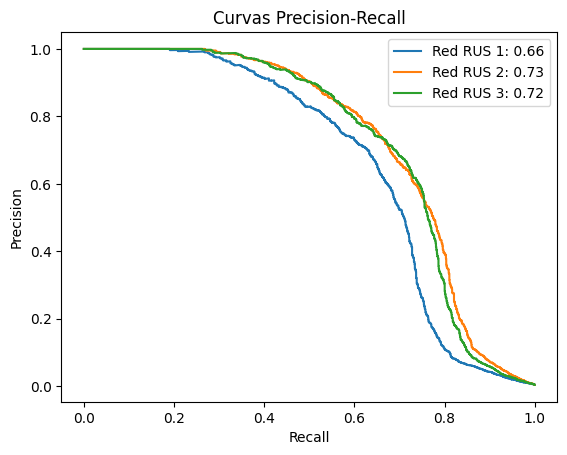

In [ ]:
models = {'Red RUS 1': model1_rus, 'Red RUS 2': model2_rus, 'Red RUS 3': model3_rus}

metrics, pr_curves = evaluate_models(models, x_test_scaled, y_test)

Pasando a analizar la precisión y el recall, se tienen resultados muy parecidos a los del apartado anterior.

In [ ]:
metrics

,Model,Precision,Recall,F1 Score
0,Red RUS 1,0.78125,0.550964,0.646204
1,Red RUS 2,0.69830,0.679063,0.688547
2,Red RUS 3,0.76500,0.632231,0.692308


#### 8.3.2. Random Oversampling

Habiendo probado a reducir la clase mayoritaria, ahora vamos a probar a aumentar los casos de fraude. De nuevo, se ha probado con distintas proporciones y la que mejores resultados ha dado es la que se utiliza ahora.

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42, sampling_strategy=0.01)

x_train_ros, y_train_ros = ros.fit_resample(x_train_scaled, y_train)

In [ ]:
model1_ros = Sequential([
    Dense(128, activation='relu', input_shape=(x_train_ros.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model1_ros.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model1_ros.fit(x_train_ros, y_train_ros, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
5698/5698 [==============================] - 7s 1ms/step - loss: 0.0318 - f1_score_custom: 0.3278
Epoch 2/20
5698/5698 [==============================] - 7s 1ms/step - loss: 0.0236 - f1_score_custom: 0.4876
Epoch 3/20
5698/5698 [==============================] - 7s 1ms/step - loss: 0.0208 - f1_score_custom: 0.5485
Epoch 4/20
5698/5698 [==============================] - 7s 1ms/step - loss: 0.0195 - f1_score_custom: 0.5908
Epoch 5/20
5698/5698 [==============================] - 7s 1ms/step - loss: 0.0187 - f1_score_custom: 0.6050
Epoch 6/20
5698/5698 [==============================] - 7s 1ms/step - loss: 0.0180 - f1_score_custom: 0.6178
Epoch 7/20
5698/5698 [==============================] - 7s 1ms/step - loss: 0.0171 - f1_score_custom: 0.6302
Epoch 8/20
5698/5698 [==============================] - 7s 1ms/step - loss: 0.0164 - f1_score_custom: 0.6402
Epoch 9/20
5698/5698 [==============================] - 7s 1ms/step - loss: 0.0158 - f1_score_custom: 0.6456
Epoch 10/20
5698/56

In [ ]:
model1_ros.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model1_ros.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model1_ros = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model1_ros.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


In [ ]:
model2_ros = Sequential([
    Dense(256, activation='relu', input_shape=(x_train_ros.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model2_ros.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model2_ros.fit(x_train_ros, y_train_ros, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
5698/5698 [==============================] - 9s 1ms/step - loss: 0.0303 - f1_score_custom: 0.3726
Epoch 2/20
5698/5698 [==============================] - 8s 1ms/step - loss: 0.0217 - f1_score_custom: 0.5444
Epoch 3/20
5698/5698 [==============================] - 8s 1ms/step - loss: 0.0196 - f1_score_custom: 0.5925
Epoch 4/20
5698/5698 [==============================] - 8s 1ms/step - loss: 0.0182 - f1_score_custom: 0.6103
Epoch 5/20
5698/5698 [==============================] - 8s 1ms/step - loss: 0.0173 - f1_score_custom: 0.6312
Epoch 6/20
5698/5698 [==============================] - 8s 1ms/step - loss: 0.0165 - f1_score_custom: 0.6421
Epoch 7/20
5698/5698 [==============================] - 8s 1ms/step - loss: 0.0158 - f1_score_custom: 0.6548
Epoch 8/20
5698/5698 [==============================] - 8s 1ms/step - loss: 0.0151 - f1_score_custom: 0.6648
Epoch 9/20
5698/5698 [==============================] - 8s 1ms/step - loss: 0.0145 - f1_score_custom: 0.6638
Epoch 10/20
5698/56

In [ ]:
model2_ros.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model2_ros.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model2_ros = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model2_ros.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


In [ ]:
model3_ros = Sequential([
    Dense(512, activation='relu', input_shape=(x_train_ros.shape[1],)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model3_ros.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model3_ros.fit(x_train_ros, y_train_ros, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
5698/5698 [==============================] - 16s 3ms/step - loss: 0.0287 - f1_score_custom: 0.4137
Epoch 2/20
5698/5698 [==============================] - 15s 3ms/step - loss: 0.0212 - f1_score_custom: 0.5615
Epoch 3/20
5698/5698 [==============================] - 15s 3ms/step - loss: 0.0191 - f1_score_custom: 0.6013
Epoch 4/20
5698/5698 [==============================] - 16s 3ms/step - loss: 0.0173 - f1_score_custom: 0.6292
Epoch 5/20
5698/5698 [==============================] - 16s 3ms/step - loss: 0.0163 - f1_score_custom: 0.6380
Epoch 6/20
5698/5698 [==============================] - 16s 3ms/step - loss: 0.0156 - f1_score_custom: 0.6561
Epoch 7/20
5698/5698 [==============================] - 16s 3ms/step - loss: 0.0150 - f1_score_custom: 0.6613
Epoch 8/20
5698/5698 [==============================] - 15s 3ms/step - loss: 0.0147 - f1_score_custom: 0.6723
Epoch 9/20
5698/5698 [==============================] - 16s 3ms/step - loss: 0.0142 - f1_score_custom: 0.6772
Epoch 10/2

In [ ]:
model3_ros.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_ros.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model3_ros = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_ros.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


Se aprecia una mejoría con respecto a los casos anteriores, especialmente en el modelo más complejo, donde ya se está cerca del valor de 0.8 en el área bajo la curva precision-recall.

12501/12501 [==============================] - 11s 851us/step


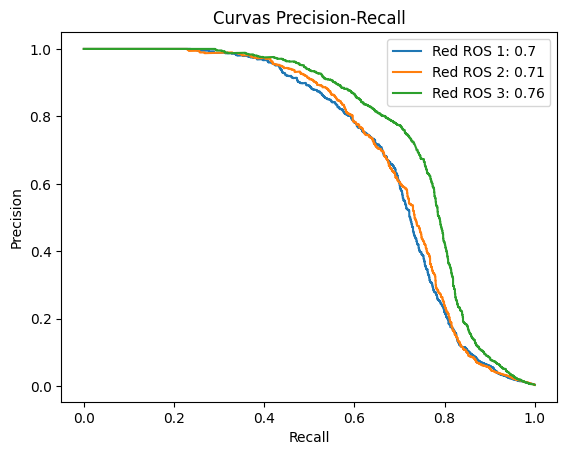

In [ ]:
models = {'Red ROS 1': model1_ros, 'Red ROS 2': model2_ros, 'Red ROS 3': model3_ros}

metrics, pr_curves = evaluate_models(models, x_test_scaled, y_test)

También al observar en mayor profundidad las métricas, se observa para la última red que se tiene un modelo bastante equilibrado.

In [ ]:
metrics

,Model,Precision,Recall,F1 Score
0,Red ROS 1,0.671939,0.672865,0.672402
1,Red ROS 2,0.626642,0.690083,0.656834
2,Red ROS 3,0.763569,0.707300,0.734358


#### 8.3.3. SMOTE

Debido a los buenos resultados en el caso del Random Oversampling, hemos decidido probar con SMOTE, una técnica de sobremuestreo más compleja que la ya mencionada. En este caso, en lugar de tomar simplemente muestras repetidas de la clase minoritaria, SMOTE genera nuevas instancias sintéticas.

Esta técnica utiliza la interpolación entre muestras reales de la clase minoritaria, seleccionando pares de puntos cercanos en el espacio de características y creando puntos adicionales en línea recta entre ellos. El resultado es un conjunto de datos más balanceado, con una distribución más realista que el duplicado aleatorio simple, lo que puede ayudar a nuestras redes neuronales a generalizar mejor y evitar el sobreajuste.

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, sampling_strategy=0.01, k_neighbors=3)

x_train_smote, y_train_smote = smote.fit_resample(x_train_scaled, y_train)

In [ ]:
model1_smote = Sequential([
    Dense(128, activation='relu', input_shape=(x_train_smote.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model1_smote.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model1_smote.fit(x_train_smote, y_train_smote, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
5698/5698 [==============================] - 7s 1ms/step - loss: 0.0322 - f1_score_custom: 0.3148
Epoch 2/20
5698/5698 [==============================] - 7s 1ms/step - loss: 0.0235 - f1_score_custom: 0.4837
Epoch 3/20
5698/5698 [==============================] - 7s 1ms/step - loss: 0.0207 - f1_score_custom: 0.5435
Epoch 4/20
5698/5698 [==============================] - 7s 1ms/step - loss: 0.0194 - f1_score_custom: 0.5881
Epoch 5/20
5698/5698 [==============================] - 7s 1ms/step - loss: 0.0185 - f1_score_custom: 0.6049
Epoch 6/20
5698/5698 [==============================] - 7s 1ms/step - loss: 0.0180 - f1_score_custom: 0.6169
Epoch 7/20
5698/5698 [==============================] - 7s 1ms/step - loss: 0.0175 - f1_score_custom: 0.6256
Epoch 8/20
5698/5698 [==============================] - 7s 1ms/step - loss: 0.0170 - f1_score_custom: 0.6274
Epoch 9/20
5698/5698 [==============================] - 7s 1ms/step - loss: 0.0166 - f1_score_custom: 0.6398
Epoch 10/20
5698/56

In [ ]:
model1_smote.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model1_smote.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model1_smote = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model1_smote.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


In [ ]:
model2_smote = Sequential([
    Dense(256, activation='relu', input_shape=(x_train_smote.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model2_smote.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model2_smote.fit(x_train_smote, y_train_smote, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
5698/5698 [==============================] - 9s 1ms/step - loss: 0.0295 - f1_score_custom: 0.3843
Epoch 2/20
5698/5698 [==============================] - 8s 1ms/step - loss: 0.0212 - f1_score_custom: 0.5473
Epoch 3/20
5698/5698 [==============================] - 9s 2ms/step - loss: 0.0195 - f1_score_custom: 0.5828
Epoch 4/20
5698/5698 [==============================] - 8s 1ms/step - loss: 0.0183 - f1_score_custom: 0.6083
Epoch 5/20
5698/5698 [==============================] - 8s 1ms/step - loss: 0.0176 - f1_score_custom: 0.6195
Epoch 6/20
5698/5698 [==============================] - 8s 1ms/step - loss: 0.0167 - f1_score_custom: 0.6328
Epoch 7/20
5698/5698 [==============================] - 8s 1ms/step - loss: 0.0160 - f1_score_custom: 0.6426
Epoch 8/20
5698/5698 [==============================] - 8s 1ms/step - loss: 0.0155 - f1_score_custom: 0.6491
Epoch 9/20
5698/5698 [==============================] - 8s 1ms/step - loss: 0.0152 - f1_score_custom: 0.6447
Epoch 10/20
5698/56

In [ ]:
model2_smote.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model2_smote.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model2_smote = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model2_smote.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


In [ ]:
model3_smote = Sequential([
    Dense(512, activation='relu', input_shape=(x_train_smote.shape[1],)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model3_smote.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model3_smote.fit(x_train_smote, y_train_smote, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
5698/5698 [==============================] - 16s 3ms/step - loss: 0.0286 - f1_score_custom: 0.4189
Epoch 2/20
5698/5698 [==============================] - 15s 3ms/step - loss: 0.0212 - f1_score_custom: 0.5604
Epoch 3/20
5698/5698 [==============================] - 15s 3ms/step - loss: 0.0189 - f1_score_custom: 0.6056
Epoch 4/20
5698/5698 [==============================] - 15s 3ms/step - loss: 0.0178 - f1_score_custom: 0.6213
Epoch 5/20
5698/5698 [==============================] - 15s 3ms/step - loss: 0.0169 - f1_score_custom: 0.6371
Epoch 6/20
5698/5698 [==============================] - 15s 3ms/step - loss: 0.0162 - f1_score_custom: 0.6403
Epoch 7/20
5698/5698 [==============================] - 15s 3ms/step - loss: 0.0157 - f1_score_custom: 0.6554
Epoch 8/20
5698/5698 [==============================] - 15s 3ms/step - loss: 0.0152 - f1_score_custom: 0.6576
Epoch 9/20
5698/5698 [==============================] - 15s 3ms/step - loss: 0.0149 - f1_score_custom: 0.6658
Epoch 10/2

In [ ]:
model3_smote.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_smote.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model3_smote = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_smote.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


En vista de los resultados mostrados abajo, parece que los resultados obtenidos con SMOTE no mejoran a los que ya teníamos de antes.

12501/12501 [==============================] - 11s 857us/step


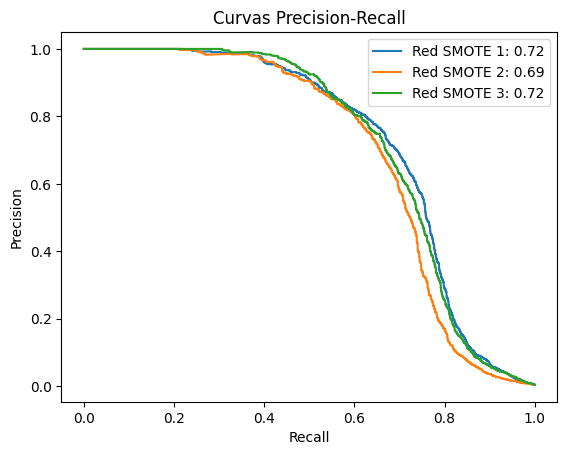

In [ ]:
models = {'Red SMOTE 1': model1_smote, 'Red SMOTE 2': model2_smote, 'Red SMOTE 3': model3_smote}

metrics, pr_curves = evaluate_models(models, x_test_scaled, y_test)

Fijándonos en las métricas de recall y precisión vemos que tampoco se obtienen valores mejores.

In [ ]:
metrics

,Model,Precision,Recall,F1 Score
0,Red SMOTE 1,0.727340,0.674242,0.699786
1,Red SMOTE 2,0.704142,0.655647,0.679030
2,Red SMOTE 3,0.639645,0.695592,0.666447


#### 8.3.4. Métodos de Regularización

Dado que los mejores resultados los hemos obtenido con la red número 3 al utilizar Random Oversampling, vamos a ver si somos capaces de mejorar aún más el modelo utilizando métodos de regularización y probando otras proporciones al sobremuestrear.

Después de cada capa densa, se ha añadido una capa de Dropout con una tasa de 0.3. Esto significa que durante el entrenamiento, el 30% de las neuronas en cada capa se "desconectarán" aleatoriamente, lo que ayuda a evitar el sobreajuste.

También se han añadido algunas capas de BatchNormalization para estabilizar el aprendizaje y acelerar la convergencia. Esto ayuda a que las activaciones de las capas no se desvíen demasiado durante el entrenamiento.

En primer lugar, se prueba a igualar la proporción de fraudes y transacciones legítimas. Después también se van a probar las proporciones de 0.75, 0.5, 0.1, 0.05 y 0.01.

In [ ]:
ros = RandomOverSampler(random_state=42, sampling_strategy='auto')

x_train_ros, y_train_ros = ros.fit_resample(x_train_scaled, y_train)

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

model3_reg_ros_auto = Sequential([
    Dense(512, activation='relu', input_shape=(x_train_smote.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model3_reg_ros_auto.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model3_reg_ros_auto.fit(x_train_ros, y_train_ros, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
11283/11283 [==============================] - 70s 6ms/step - loss: 0.1658 - f1_score_custom: 0.9319
Epoch 2/20
11283/11283 [==============================] - 68s 6ms/step - loss: 0.1063 - f1_score_custom: 0.9578
Epoch 3/20
11283/11283 [==============================] - 68s 6ms/step - loss: 0.0899 - f1_score_custom: 0.9645
Epoch 4/20
11283/11283 [==============================] - 68s 6ms/step - loss: 0.0792 - f1_score_custom: 0.9690
Epoch 5/20
11283/11283 [==============================] - 68s 6ms/step - loss: 0.0711 - f1_score_custom: 0.9726
Epoch 6/20
11283/11283 [==============================] - 68s 6ms/step - loss: 0.0656 - f1_score_custom: 0.9752
Epoch 7/20
11283/11283 [==============================] - 66s 6ms/step - loss: 0.0622 - f1_score_custom: 0.9767
Epoch 8/20
11283/11283 [==============================] - 66s 6ms/step - loss: 0.0585 - f1_score_custom: 0.9785
Epoch 9/20
11283/11283 [==============================] - 66s 6ms/step - loss: 0.0556 - f1_score_custom:

In [ ]:
model3_reg_ros_auto.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_reg_ros_auto.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model3_reg_ros_auto = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_reg_ros_auto.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


In [ ]:
ros = RandomOverSampler(random_state=42, sampling_strategy=0.75)

x_train_ros, y_train_ros = ros.fit_resample(x_train_scaled, y_train)

In [ ]:
model3_reg_ros_75 = Sequential([
    Dense(512, activation='relu', input_shape=(x_train_smote.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model3_reg_ros_75.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model3_reg_ros_75.fit(x_train_ros, y_train_ros, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
9873/9873 [==============================] - 60s 6ms/step - loss: 0.1545 - f1_score_custom: 0.9248
Epoch 2/20
9873/9873 [==============================] - 57s 6ms/step - loss: 0.0917 - f1_score_custom: 0.9568
Epoch 3/20
9873/9873 [==============================] - 58s 6ms/step - loss: 0.0747 - f1_score_custom: 0.9655
Epoch 4/20
9873/9873 [==============================] - 57s 6ms/step - loss: 0.0652 - f1_score_custom: 0.9707
Epoch 5/20
9873/9873 [==============================] - 57s 6ms/step - loss: 0.0580 - f1_score_custom: 0.9745
Epoch 6/20
9873/9873 [==============================] - 57s 6ms/step - loss: 0.0536 - f1_score_custom: 0.9767
Epoch 7/20
9873/9873 [==============================] - 58s 6ms/step - loss: 0.0491 - f1_score_custom: 0.9791
Epoch 8/20
9873/9873 [==============================] - 57s 6ms/step - loss: 0.0466 - f1_score_custom: 0.9804
Epoch 9/20
9873/9873 [==============================] - 57s 6ms/step - loss: 0.0437 - f1_score_custom: 0.9818
Epoch 10/2

In [ ]:
model3_reg_ros_75.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_reg_ros_75.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model3_reg_ros_75 = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_reg_ros_75.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


In [ ]:
ros = RandomOverSampler(random_state=42, sampling_strategy=0.5)

x_train_ros, y_train_ros = ros.fit_resample(x_train_scaled, y_train)

In [ ]:
model3_reg_ros_5 = Sequential([
    Dense(512, activation='relu', input_shape=(x_train_smote.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model3_reg_ros_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model3_reg_ros_5.fit(x_train_ros, y_train_ros, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
8462/8462 [==============================] - 52s 6ms/step - loss: 0.1682 - f1_score_custom: 0.8922
Epoch 2/20
8462/8462 [==============================] - 51s 6ms/step - loss: 0.1080 - f1_score_custom: 0.9345
Epoch 3/20
8462/8462 [==============================] - 51s 6ms/step - loss: 0.0934 - f1_score_custom: 0.9435
Epoch 4/20
8462/8462 [==============================] - 50s 6ms/step - loss: 0.0848 - f1_score_custom: 0.9486
Epoch 5/20
8462/8462 [==============================] - 50s 6ms/step - loss: 0.0786 - f1_score_custom: 0.9521
Epoch 6/20
8462/8462 [==============================] - 50s 6ms/step - loss: 0.0733 - f1_score_custom: 0.9557
Epoch 7/20
8462/8462 [==============================] - 50s 6ms/step - loss: 0.0692 - f1_score_custom: 0.9583
Epoch 8/20
8462/8462 [==============================] - 50s 6ms/step - loss: 0.0655 - f1_score_custom: 0.9605
Epoch 9/20
8462/8462 [==============================] - 50s 6ms/step - loss: 0.0635 - f1_score_custom: 0.9622
Epoch 10/2

In [ ]:
model3_reg_ros_5.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_reg_ros_5.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model3_reg_ros_5 = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_reg_ros_5.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


In [ ]:
ros = RandomOverSampler(random_state=42, sampling_strategy=0.1)

x_train_ros, y_train_ros = ros.fit_resample(x_train_scaled, y_train)

In [ ]:
model3_reg_ros_1 = Sequential([
    Dense(512, activation='relu', input_shape=(x_train_smote.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model3_reg_ros_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model3_reg_ros_1.fit(x_train_ros, y_train_ros, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
6206/6206 [==============================] - 38s 6ms/step - loss: 0.1268 - f1_score_custom: 0.7349
Epoch 2/20
6206/6206 [==============================] - 37s 6ms/step - loss: 0.0736 - f1_score_custom: 0.8448
Epoch 3/20
6206/6206 [==============================] - 36s 6ms/step - loss: 0.0649 - f1_score_custom: 0.8654
Epoch 4/20
6206/6206 [==============================] - 36s 6ms/step - loss: 0.0604 - f1_score_custom: 0.8743
Epoch 5/20
6206/6206 [==============================] - 36s 6ms/step - loss: 0.0574 - f1_score_custom: 0.8800
Epoch 6/20
6206/6206 [==============================] - 36s 6ms/step - loss: 0.0547 - f1_score_custom: 0.8860
Epoch 7/20
6206/6206 [==============================] - 36s 6ms/step - loss: 0.0528 - f1_score_custom: 0.8898
Epoch 8/20
6206/6206 [==============================] - 36s 6ms/step - loss: 0.0515 - f1_score_custom: 0.8918
Epoch 9/20
6206/6206 [==============================] - 36s 6ms/step - loss: 0.0503 - f1_score_custom: 0.8945
Epoch 10/2

In [ ]:
model3_reg_ros_1.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_reg_ros_1.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model3_reg_ros_1 = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_reg_ros_1.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


In [ ]:
ros = RandomOverSampler(random_state=42, sampling_strategy=0.05)

x_train_ros, y_train_ros = ros.fit_resample(x_train_scaled, y_train)

In [ ]:
model3_reg_ros_05 = Sequential([
    Dense(512, activation='relu', input_shape=(x_train_smote.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model3_reg_ros_05.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model3_reg_ros_05.fit(x_train_ros, y_train_ros, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
5924/5924 [==============================] - 36s 6ms/step - loss: 0.0984 - f1_score_custom: 0.6538
Epoch 2/20
5924/5924 [==============================] - 35s 6ms/step - loss: 0.0562 - f1_score_custom: 0.7836
Epoch 3/20
5924/5924 [==============================] - 35s 6ms/step - loss: 0.0492 - f1_score_custom: 0.8133
Epoch 4/20
5924/5924 [==============================] - 35s 6ms/step - loss: 0.0457 - f1_score_custom: 0.8280
Epoch 5/20
5924/5924 [==============================] - 35s 6ms/step - loss: 0.0436 - f1_score_custom: 0.8366
Epoch 6/20
5924/5924 [==============================] - 35s 6ms/step - loss: 0.0418 - f1_score_custom: 0.8437
Epoch 7/20
5924/5924 [==============================] - 34s 6ms/step - loss: 0.0406 - f1_score_custom: 0.8484
Epoch 8/20
5924/5924 [==============================] - 35s 6ms/step - loss: 0.0395 - f1_score_custom: 0.8511
Epoch 9/20
5924/5924 [==============================] - 35s 6ms/step - loss: 0.0385 - f1_score_custom: 0.8563
Epoch 10/2

In [ ]:
model3_reg_ros_05.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_reg_ros_05.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model3_reg_ros_05 = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_reg_ros_05.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


In [ ]:
ros = RandomOverSampler(random_state=42, sampling_strategy=0.01)

x_train_ros, y_train_ros = ros.fit_resample(x_train_scaled, y_train)

In [ ]:
model3_reg_ros_01 = Sequential([
    Dense(512, activation='relu', input_shape=(x_train_smote.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model3_reg_ros_01.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_custom])
model3_reg_ros_01.fit(x_train_ros, y_train_ros, epochs=20, batch_size=256, verbose=1)

Epoch 1/20
5698/5698 [==============================] - 35s 6ms/step - loss: 0.0528 - f1_score_custom: 0.3029
Epoch 2/20
5698/5698 [==============================] - 33s 6ms/step - loss: 0.0238 - f1_score_custom: 0.5091
Epoch 3/20
5698/5698 [==============================] - 34s 6ms/step - loss: 0.0215 - f1_score_custom: 0.5529
Epoch 4/20
5698/5698 [==============================] - 34s 6ms/step - loss: 0.0201 - f1_score_custom: 0.5765
Epoch 5/20
5698/5698 [==============================] - 33s 6ms/step - loss: 0.0191 - f1_score_custom: 0.5935
Epoch 6/20
5698/5698 [==============================] - 34s 6ms/step - loss: 0.0185 - f1_score_custom: 0.6107
Epoch 7/20
5698/5698 [==============================] - 33s 6ms/step - loss: 0.0178 - f1_score_custom: 0.6149
Epoch 8/20
5698/5698 [==============================] - 33s 6ms/step - loss: 0.0175 - f1_score_custom: 0.6174
Epoch 9/20
5698/5698 [==============================] - 34s 6ms/step - loss: 0.0169 - f1_score_custom: 0.6294
Epoch 10/2

In [ ]:
model3_reg_ros_01.save('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_reg_ros_01.keras')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [ ]:
model3_reg_ros_01 = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_reg_ros_01.keras')
print("Se ha cargado el modelo.")

Se ha cargado el modelo.


En vista de la gráfica mostrada abajo y los valores de precisión y recall, queda claro que no se han podido mejorar los resultados previos.

12501/12501 [==============================] - 12s 991us/step


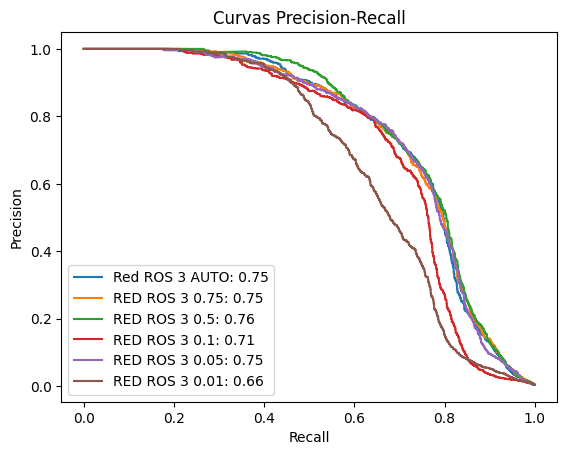

In [ ]:
models = {'Red ROS 3 AUTO': model3_reg_ros_auto, 'RED ROS 3 0.75': model3_reg_ros_75, 'RED ROS 3 0.5': model3_reg_ros_5,
          'RED ROS 3 0.1': model3_reg_ros_1, 'RED ROS 3 0.05': model3_reg_ros_05, 'RED ROS 3 0.01': model3_reg_ros_01}

metrics, pr_curves = evaluate_models(models, x_test_scaled, y_test)

In [ ]:
metrics

,Model,Precision,Recall,F1 Score
0,Red ROS 3 AUTO,0.106048,0.910468,0.189970
1,RED ROS 3 0.75,0.140307,0.898760,0.242723
2,RED ROS 3 0.5,0.105192,0.916667,0.188727
3,RED ROS 3 0.1,0.273540,0.800275,0.407719
4,RED ROS 3 0.05,0.555556,0.778237,0.648308
5,RED ROS 3 0.01,0.672055,0.601240,0.634678


Se muestra a continuación la matriz de confusión asociada a la red número 3 en la primera implementación de Random Oversampling que es la que mejores resultados nos ha dado.

12501/12501 [==============================] - 10s 835us/step


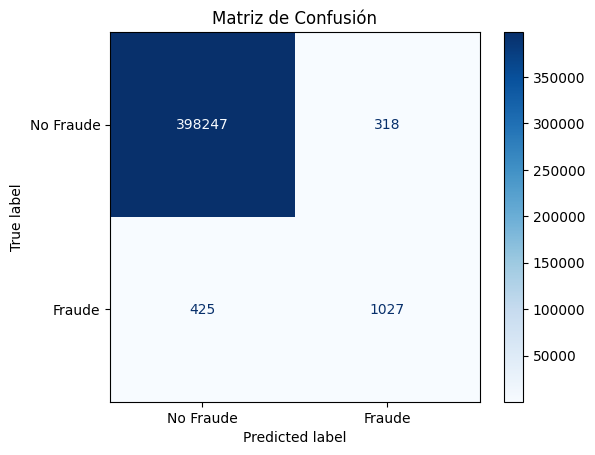

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_probs = model3_ros.predict(x_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraude", "Fraude"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Matriz de Confusión")
plt.show()

Como conclusión de esta parte dedicada a redes neuronales, hemos visto que a pesar de explorar diversas combinaciones de arquitecturas de redes y técnicas de remuestreo y regularización no se han podido alcanzar resultados como los obtenidos con XGBoost y modelos similares.

## 9. Selección de Modelo y Balance Final

Una vez finalizada toda la ronda de entrenamiento de modelos, nos centramos en ver con cuál se obtienen las mejores métricas. Para ello, nos quedamos con la mejor versión de cada uno de los cuatro modelos basados en árboles del apartado 7 y la mejor red neuronal del apartado 8.

Para obtener las métricas de cada uno, en primer lugar nos ocupamos de nombrar de forma diferente los datos escalados con StandardScaler (para modelos de tipo árbol) y con MinMaxScaler (para las redes).

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Dividimos según variables.
x_train = train_df.drop('is_fraud', axis = 1)
y_train = train_df['is_fraud']

x_test = test_df.drop('is_fraud', axis = 1)
y_test = test_df['is_fraud']

# Configurar el escaladores.
std = StandardScaler()
minmax = MinMaxScaler()

# Obtener los datos escalados con Standard Scaler.
x_train_std = std.fit_transform(x_train)
x_test_std = std.transform(x_test)

# Obtener datos escalados con MinMaxScaler.
x_train_minmax = minmax.fit_transform(x_train)
x_test_minmax = minmax.transform(x_test)

Una vez hecho eso, obtenemos las curvas precision-recall de cada uno de los modelos considerados, así como algunas métricas de interés como el F1, calculado sobre los datos de test. De nuevo para ello deberemos tener en cuenta de si se trata de redes neuronales o no dado que los datos utilizados son diferentes.

In [ ]:
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/decision_tree_model_gs.pkl', 'rb') as file:
    model_dt_gs = pickle.load(file)
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/random_forest_model_gs.pkl', 'rb') as file:
    model_rf_gs = pickle.load(file)
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/xgb_model_gs.pkl', 'rb') as file:
    model_xgb_smote = pickle.load(file)
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/brf_model_gs.pkl', 'rb') as file:
    model_brf_gs = pickle.load(file)
with open('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/voting_model.pkl', 'rb') as file:
    voting_model = pickle.load(file)
model3_ros = load_model('/content/drive/Shareddrives/MUCSI-ML/Proyecto/Modelos/model3_ros.keras')


12501/12501 [==============================] - 11s 889us/step


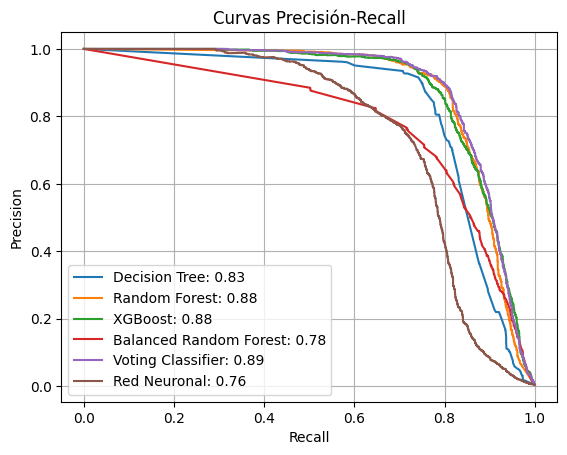

In [ ]:
from sklearn.metrics import precision_recall_curve, classification_report

# Introducimos los mejores modelos de cada tipo que hemos obtenido.
models = {
    "Decision Tree": model_dt_gs,
    "Random Forest": model_rf_gs,
    "XGBoost": model_xgb_smote,
    "Balanced Random Forest": model_brf_gs,
    "Voting Classifier": voting_model,
    "Red Neuronal": model3_ros
}

results = []
for name, model in models.items():
    if name == "Red Neuronal":
        y_pred = (model.predict(x_test_minmax) > 0.5).astype(int)
        y_prob = model.predict(x_test_minmax).ravel()
    else:
        y_pred = model.predict(x_test_scaled)
        y_prob = model.predict_proba(x_test_scaled)[:, 1]

    # Calcular métricas
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1 = f1_score(y_test, y_pred)

    results.append((name, model_precision, model_recall, model_f1))

    # Generar curva precisión-recall
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name}: {round(pr_auc, 2)}')

# Mostrar resultados
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precisión-Recall")
plt.legend()
plt.grid()
plt.show()

# Mostrar métricas en forma de tabla
df_results = pd.DataFrame(results, columns=["Model", "Precision", "Recall", "F1"])

Como podemos ver en la gráfica, todos los modelos muestran buenos resultados, pero destacan el Random Forest, XGBoost y Voting Classifier, entrenados con los resultados de GridSearch y en el caso de XGBoost añadiendo datos con SMOTE. Por otro lado, se ve que el Balanced Ranfom Forest y la red neuronal (la correspondiente a la tercera arquitectura propuesta y usando ROS) son los que peores resultados dan con valores de 0,78 y 0,76 respectivamente.

Fijándonos ahora en las métricas de precisión, recall y F1, en la tabla de abajo se muestran los resultados de cada modelo ordenados de forma descendente en función del F1. De nuevo, vemos que los que destacan son el Voting Classifier junto con el Random Forest con un valor de 0,84 de F1. Con el Random Forest se detectan más del 80% de los casos de fraudes y todo ello con un impacto mínimo en la experiencia de los clientes ya que se tiene una precisión del 88%. Sin embargo, con el Voting Classifier se detectan el 79,47% de casos pero con menor impacto en la experiencia de los clientes con una precisión del 90%.

Por el contrario, destacamos el hecho de que el Balanced Random Forest, a pesar de tener un recall altísimo de prácticamente el 100%, muestra una precisión nefasta de menos del 15%


In [ ]:
df_results.sort_values(by="F1", ascending=False)

,Model,Precision,Recall,F1
4,Voting Classifier,0.901563,0.794766,0.844802
1,Random Forest,0.883686,0.805785,0.842939
2,XGBoost,0.897023,0.767906,0.827458
0,Decision Tree,0.848485,0.771350,0.808081
5,Red Neuronal,0.763569,0.707300,0.734358
3,Balanced Random Forest,0.147053,0.962121,0.255113


Ahora que hemos identificado los dos mejores modelos y lo cercano que están el uno del otro, evaluemos sus impactos potenciales en la práctica. Para empezar, examinemos de nuevo su matriz de confusión. De las 400,000 transacciones del conjunto de prueba, el Random Forest identifica correctamente 1,170 casos de fraude, mientras que no logra detectar 282. Además, el número de falsos positivos es muy bajo, con solo 154 casos.

En resumen, este modelo tendría un impacto mínimo en la experiencia de los clientes, ya que los errores ocurren en aproximadamente 100 transacciones de cada 400,000, lo que representa una tasa de error extremadamente baja.


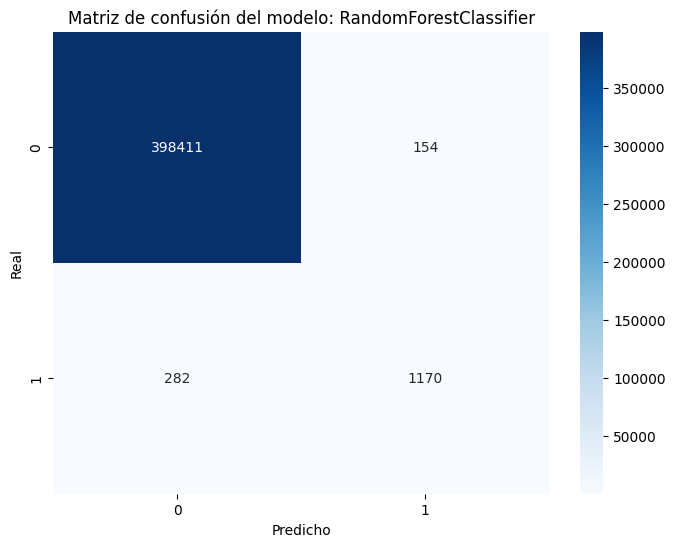

In [ ]:
plot_cm(model_rf_gs, x_test_scaled, y_test)

Por otro lado, el Voting Classifier detecta correctamente 1154 casos de fraude mientras no logra detectar 298. Lo que mejora respecto al anterior modelo es el número de falsos positivos bajando a 126 casos haciendo que la tasa de error sea realmente baja.

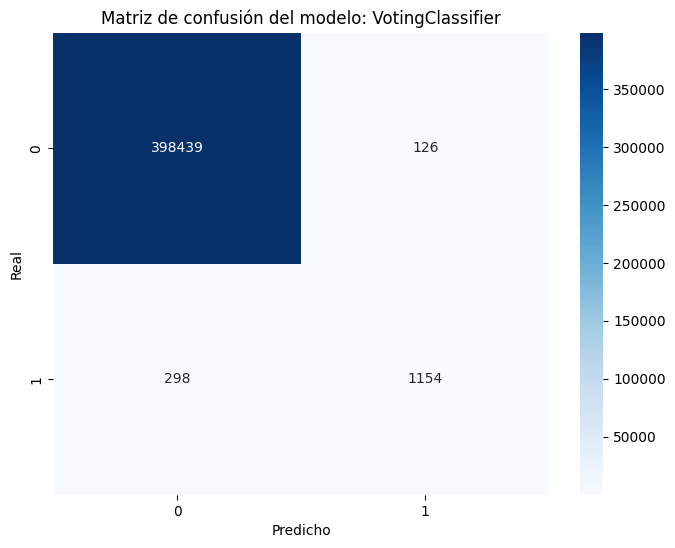

In [ ]:
plot_cm(voting_model, x_test_scaled, y_test)

A continuación, veamos cuál es la cuantía del dinero total defraudado en el conjunto de test, y qué proporción del mismo somos capaces de detectar con el modelo de Random Forest y con el Voting Classifier para llevar estos datos al mundo real.

In [ ]:
# Nos quedamos con los fraudes del dataset.
test_frauds = test_df[test_df['is_fraud'] == 1]

# Obtenemos la suma del dinero defraudado.
dinero_fraudes = test_frauds['amt'].sum()

print(f'El dinero defraudado total es de {dinero_fraudes} dólares.')

El dinero defraudado total es de 786608.23 dólares.


In [ ]:
# Obtenemos las predicciones del modelo.
y_pred = model_rf_gs.predict(std.transform(test_frauds.drop(columns=["is_fraud"])))

# Crear una columna para las predicciones.
test_frauds["predicted_fraud"] = y_pred

# Filtrar las instancias correctamente detectadas como fraude.
correct_fraudes = test_frauds[(test_frauds["is_fraud"] == 1) & (test_frauds["predicted_fraud"] == 1)]

# Obtenemos la suma de dinero de frades que detectamos correctamente.
corrrect_fraudes_amt = correct_fraudes["amt"].sum()

print(f"Se tiene un total de {round(corrrect_fraudes_amt, 2)} dólares en las transacciones correctamente catalogadas como fraude.")

print(f'Esto supone un {round((corrrect_fraudes_amt / dinero_fraudes * 100), 2)}% del total.')

Se tiene un total de 731912.9 dólares en las transacciones correctamente catalogadas como fraude.
Esto supone un 93.05% del total.


In [ ]:
# Obtenemos las predicciones del modelo.
y_pred = voting_model.predict(std.transform(test_frauds.drop(columns=["is_fraud"])))

# Crear una columna para las predicciones.
test_frauds["predicted_fraud"] = y_pred

# Filtrar las instancias correctamente detectadas como fraude.
correct_fraudes = test_frauds[(test_frauds["is_fraud"] == 1) & (test_frauds["predicted_fraud"] == 1)]

# Obtenemos la suma de dinero de frades que detectamos correctamente.
corrrect_fraudes_amt = correct_fraudes["amt"].sum()

print(f"Se tiene un total de {round(corrrect_fraudes_amt, 2)} dólares en las transacciones correctamente catalogadas como fraude.")

print(f'Esto supone un {round((corrrect_fraudes_amt / dinero_fraudes * 100), 2)}% del total.')

Se tiene un total de 718782.46 dólares en las transacciones correctamente catalogadas como fraude.
Esto supone un 91.38% del total.


Observamos que el Voting Classifier es capaz de detectar un 91,38% del total mientras que el Random Forest detecta un 93,05%. En un caso del mundo real, se le presentarían los dos modelos al cliente y este elegiría el que mejor satisfaga sus necesidades. Bajo nuestro punto de vista, elegimos el modelo de Random Forest ya que preferimos detectar la mayor cantidad de fraudes para proteger lo máximo posible a los clientes.

## 10. Conclusiones

En este proyecto se ha llevado a cabo un proceso completo de Machine Learning, que abarca desde el análisis preliminar hasta el entrenamiento de diversos modelos, pasando por la creación de columnas sintéticas y un análisis exploratorio de datos (EDA) para identificar variables clave. El caso de uso se ha centrado en la detección de fraudes en tarjetas de crédito, uno de los problemas más comunes en el ámbito del ML. Para ello, hemos utilizado un conjunto de datos que simula transacciones realizadas en Estados Unidos durante los años 2019 y 2020. Este dataset contiene aproximadamente 2 millones de registros y 23 columnas.

Al comenzar un proyecto como este, es fundamental establecer objetivos claros. En nuestro caso, nos propusimos entrenar un modelo capaz de identificar la mayor cantidad de fraudes posible, minimizando al mismo tiempo el impacto en la experiencia de los clientes. Esto es crucial, ya que si se bloquean transacciones legítimas, los clientes podrían optar por la competencia debido a la mala experiencia. Para lograrlo, es esencial elegir las métricas adecuadas para evaluar el rendimiento de los modelos. En nuestro caso, nos centramos en el F1 score y el área bajo la curva precision-recall. Además, utilizamos la visualización de estas curvas y las correspondientes matrices de confusión para obtener una mejor comprensión de los resultados.

Sin embargo, antes de comenzar a trabajar con los modelos, fue esencial realizar un análisis exhaustivo de los datos disponibles para comprenderlos mejor y tratar de identificar patrones o variables relevantes para nuestras predicciones. En este proceso, nos dimos cuenta de que, dada la gran cantidad de datos y el severo desbalance (solo un 0.5% de las transacciones son fraudulentas), era fundamental asegurar la calidad de los datos utilizados para entrenar los modelos. Por eso, dedicamos una parte significativa del proyecto a estudiar las variables a fondo mediante visualizaciones y a crear nuevas variables de interés, como el historial de fraudes previos de los clientes.

Nuestro enfoque destaca la importancia de partir de buenos datos para obtener resultados de calidad, lo cual es crucial en casos con datasets tan complejos como el nuestro donde los tiempos de entrenamiento son tan elevados.

Una vez que los datos estuvieron listos, se decidió dividir los conjuntos de entrenamiento y prueba según la fecha, con el objetivo de simular de manera realista los resultados que se obtendrían en un entorno de producción, donde nuestros modelos solo tendrían acceso a información de transacciones pasadas. Esta división se realizó asignando un 80% de los datos para el entrenamiento y el 20% restante para la prueba. Esta estrategia es clave, ya que permite obtener resultados lo más cercanos posibles a la realidad, asegurando que el modelo se evalúe en condiciones que reflejan cómo operará una vez implementado en el mundo real.





Como se mencionó anteriormente, éramos conscientes de los largos tiempos de entrenamiento que requerirían nuestros modelos. Por ello, antes de comenzar a trabajar, diseñamos una estrategia clara, adoptando un enfoque incremental en cuanto a la complejidad de los modelos. Esto nos permitió sofisticarlos de acuerdo con las necesidades y puntos de mejora que surgieran a lo largo del proceso. Asimismo, se identificaron algunos modelos que podrían ser efectivos para este tipo de problemas y se agruparon en dos bloques. Por un lado, seleccionamos modelos basados en árboles, que han demostrado ser muy efectivos en situaciones similares, concretamente Decision Tree, Random Forest, Balanced Random Forest y XGBoost. Por otro lado, consideramos la posibilidad de diseñar una serie de redes neuronales con el objetivo de explorar si podrían mejorar los resultados obtenidos por los modelos basados en árboles.

Para los modelos basados en árboles, comenzamos con unas combinaciones estándar de hiperparámetros para establecer una línea de referencia de cuál era nuestro punto de partida. Posteriormente, implementamos diversos GridSearch con validación cruzada para tratar de mejorar el rendimiento obtenido. Para ello, tuvimos presente en todo momento que debíamos escoger los grids de parámetros con cuidado para tratar de seleccionar valores adecuados sin necesidad de demasiadas combinaciones, pues esto elevaría en exceso los tiempos de entrenamiento. Una vez hecho esto, tratamos de aplicar SMOTE (creación de puntos de datos sintéticos de la clase minoritaria para balancear un poco más los datos) en algunos de los modelos. Por último, también exploramos la posibilidad de combinar dos modelos: uno con un alto recall, para maximizar la detección de fraudes, y otro con alta precisión, para reducir los falsos positivos. La esperanza era que esta combinación pudiera mejorar los resultados generales, sin embargo, los experimentos mostraron que la mejora no fue significativa y los resultados obtenidos fueron muy similares a los que ya teníamos con los modelos individuales.

A continuación, pasamos al bloque de redes neuronales, donde decidimos probar tres arquitecturas diferentes, siendo la primera la más sencilla y la tercera la más compleja. Inicialmente, todas las redes consistían únicamente de capas densas con la función de activación ReLU.


Luego, intentamos mejorar el rendimiento asignando pesos diferentes a cada clase mediante la opción class_weight, un método comúnmente utilizado para tratar con datos desbalanceados. Sin embargo, los resultados no fueron del todo satisfactorios. A continuación, probamos varias técnicas de manejo del desbalance para cada una de las tres redes: Random Under Sampling (RUS), Random Over Sampling (ROS) y SMOTE. Finalmente, dado que los mejores resultados se obtuvieron con la tercera red utilizando ROS, decidimos quedarnos con esta arquitectura. A continuación, incorporamos métodos de regularización, concretamente Batch Normalization y Dropout, para evitar el sobreajuste y también experimentamos creando más datos de la clase minoritaria utilizando ROS en diferentes proporciones.



Para concluir, tomamos las mejores versiones de los cuatro modelos basados en árboles y de las redes neuronales, y realizamos una comparación entre todos ellos en base a los valores de F1 y al área bajo la curva precision-recall, tal como se había adelantado. De esta forma, pudimos observar que los mejores resultados se obtenían con los modelos Voting Classifier y Random Forest, utilizando los hiperparámetros obtenidos mediante GridSearch. Comparando sus matrices de confusión decidimos escoger el Random Forest empeorando la experiencia del cliente con mayor probabilidad de detectar falsos positivos con el fin de detectar la mayor cantidad de fraudes. Este modelo mostró un valor de F1 de 0,84 y fue capaz de detectar el 80% de los fraudes con una precisión cercana al 90%. Además, un aspecto clave es que la suma del dinero correspondiente a los casos que clasificamos correctamente como fraude representa más del 93.05% del total de dinero defraudado en el conjunto de test. Esto resalta no solo la efectividad del modelo para detectar fraudes, sino también su capacidad para minimizar las pérdidas económicas asociadas con los fraudes no detectados. Dicho de otra forma, aunque haya bastantes fraudes que pasan desapercibidos, éstos se pueden considerar "residuales" ya que suponen menos del 7% del total del dinero de transacciones fraudulentas.

En resumen, creemos que hemos sido capaces de cumplir los objetivos que nos planteamos al inicio del proyecto. Para ello hemos tenido que establecer una estrategia clara que nos ha permitido hacer frente al problema del tamaño y desbalance de nuestro dataset. El modelo que proponemos permite beneficiar no sólo a nuestra compañía (ya que optimiza la detección de fraudes y minimiza las pérdidas económicas) sino también a nuestros clientes (ya que nuestro modelo no provocará cambios en su experiencia).
